In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['targets']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'basal_seg',
    'balance_data'  : True,
    'exclude'       : ['normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_0_0_0_1_normalized_e_n_e_0_0_e_0_0_basal_seg_data_norm_b25_targets_t1_native_k5_b25_t1_0_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1078212, 1576)
(1078212, 3)
validation
(151755, 1576)
(151755, 3)
test
(135990, 1576)
(135990, 3)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 1576)]            0         


 dense (Dense)               (None, 1024)              1614848   


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 3)                 387       


Total params: 2304259 (8.79 MB)


Trainable params: 2304259 (8.79 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/108 [..............................] - ETA: 2:57 - loss: 1.1419 - STD: 0.0896 - MAE: 0.4452

  3/108 [..............................] - ETA: 3s - loss: 1.1326 - STD: 0.0835 - MAE: 0.4444  

  5/108 [>.............................] - ETA: 29s - loss: 1.1216 - STD: 0.0630 - MAE: 0.4443

  7/108 [>.............................] - ETA: 20s - loss: 1.1179 - STD: 0.0601 - MAE: 0.4442

  9/108 [=>............................] - ETA: 15s - loss: 1.1155 - STD: 0.0565 - MAE: 0.4442

 11/108 [==>...........................] - ETA: 13s - loss: 1.1122 - STD: 0.0494 - MAE: 0.4441

 13/108 [==>...........................] - ETA: 11s - loss: 1.1107 - STD: 0.0482 - MAE: 0.4441

 15/108 [===>..........................] - ETA: 9s - loss: 1.1091 - STD: 0.0455 - MAE: 0.4440 

 17/108 [===>..........................] - ETA: 8s - loss: 1.1074 - STD: 0.0419 - MAE: 0.4440

 19/108 [====>.........................] - ETA: 8s - loss: 1.1062 - STD: 0.0408 - MAE: 0.4438

 21/108 [====>.........................] - ETA: 7s - loss: 1.1048 - STD: 0.0392 - MAE: 0.4437

 23/108 [=====>........................] - ETA: 6s - loss: 1.1033 - STD: 0.0370 - MAE: 0.4435

 25/108 [=====>........................] - ETA: 6s - loss: 1.1016 - STD: 0.0358 - MAE: 0.4433

 27/108 [======>.......................] - ETA: 6s - loss: 1.0998 - STD: 0.0350 - MAE: 0.4430

 29/108 [=======>......................] - ETA: 5s - loss: 1.0974 - STD: 0.0345 - MAE: 0.4425

 31/108 [=======>......................] - ETA: 5s - loss: 1.0945 - STD: 0.0349 - MAE: 0.4419

 33/108 [========>.....................] - ETA: 5s - loss: 1.0909 - STD: 0.0360 - MAE: 0.4410

 35/108 [========>.....................] - ETA: 4s - loss: 1.0866 - STD: 0.0384 - MAE: 0.4399

 37/108 [=========>....................] - ETA: 4s - loss: 1.0819 - STD: 0.0419 - MAE: 0.4384

 39/108 [=========>....................] - ETA: 4s - loss: 1.0771 - STD: 0.0458 - MAE: 0.4368

 41/108 [==========>...................] - ETA: 4s - loss: 1.0720 - STD: 0.0496 - MAE: 0.4351

 43/108 [==========>...................] - ETA: 3s - loss: 1.0666 - STD: 0.0543 - MAE: 0.4330

 45/108 [===========>..................] - ETA: 3s - loss: 1.0618 - STD: 0.0588 - MAE: 0.4311

 47/108 [============>.................] - ETA: 3s - loss: 1.0569 - STD: 0.0633 - MAE: 0.4291

 49/108 [============>.................] - ETA: 3s - loss: 1.0521 - STD: 0.0681 - MAE: 0.4270

 51/108 [=============>................] - ETA: 3s - loss: 1.0476 - STD: 0.0723 - MAE: 0.4251

 53/108 [=============>................] - ETA: 3s - loss: 1.0433 - STD: 0.0763 - MAE: 0.4232

 55/108 [==============>...............] - ETA: 2s - loss: 1.0390 - STD: 0.0802 - MAE: 0.4214

 57/108 [==============>...............] - ETA: 2s - loss: 1.0350 - STD: 0.0837 - MAE: 0.4197

 59/108 [===============>..............] - ETA: 2s - loss: 1.0310 - STD: 0.0873 - MAE: 0.4179

 61/108 [===============>..............] - ETA: 2s - loss: 1.0275 - STD: 0.0905 - MAE: 0.4164

 63/108 [================>.............] - ETA: 2s - loss: 1.0239 - STD: 0.0934 - MAE: 0.4150

 65/108 [=================>............] - ETA: 2s - loss: 1.0206 - STD: 0.0961 - MAE: 0.4136

 67/108 [=================>............] - ETA: 2s - loss: 1.0173 - STD: 0.0985 - MAE: 0.4123

 69/108 [==================>...........] - ETA: 1s - loss: 1.0142 - STD: 0.1009 - MAE: 0.4111

 71/108 [==================>...........] - ETA: 1s - loss: 1.0109 - STD: 0.1032 - MAE: 0.4099

 73/108 [===================>..........] - ETA: 1s - loss: 1.0079 - STD: 0.1053 - MAE: 0.4087

 75/108 [===================>..........] - ETA: 1s - loss: 1.0050 - STD: 0.1076 - MAE: 0.4075

 77/108 [====================>.........] - ETA: 1s - loss: 1.0020 - STD: 0.1096 - MAE: 0.4064

 79/108 [====================>.........] - ETA: 1s - loss: 0.9991 - STD: 0.1117 - MAE: 0.4052

 81/108 [=====================>........] - ETA: 1s - loss: 0.9963 - STD: 0.1138 - MAE: 0.4041

 83/108 [======================>.......] - ETA: 1s - loss: 0.9938 - STD: 0.1160 - MAE: 0.4029

 85/108 [======================>.......] - ETA: 1s - loss: 0.9918 - STD: 0.1182 - MAE: 0.4019

 87/108 [=======================>......] - ETA: 0s - loss: 0.9891 - STD: 0.1200 - MAE: 0.4008

 89/108 [=======================>......] - ETA: 0s - loss: 0.9870 - STD: 0.1219 - MAE: 0.3998

 91/108 [========================>.....] - ETA: 0s - loss: 0.9846 - STD: 0.1237 - MAE: 0.3988

 93/108 [========================>.....] - ETA: 0s - loss: 0.9826 - STD: 0.1254 - MAE: 0.3979

 95/108 [=========================>....] - ETA: 0s - loss: 0.9804 - STD: 0.1269 - MAE: 0.3970

 97/108 [=========================>....] - ETA: 0s - loss: 0.9780 - STD: 0.1285 - MAE: 0.3961

 99/108 [==========================>...] - ETA: 0s - loss: 0.9759 - STD: 0.1300 - MAE: 0.3952

101/108 [===========================>..] - ETA: 0s - loss: 0.9736 - STD: 0.1316 - MAE: 0.3943

103/108 [===========================>..] - ETA: 0s - loss: 0.9716 - STD: 0.1331 - MAE: 0.3934

105/108 [============================>.] - ETA: 0s - loss: 0.9695 - STD: 0.1346 - MAE: 0.3925

107/108 [============================>.] - ETA: 0s - loss: 0.9675 - STD: 0.1361 - MAE: 0.3917

108/108 [==============================] - 8s 56ms/step - loss: 0.9664 - STD: 0.1368 - MAE: 0.3912 - val_loss: 0.8396 - val_STD: 0.2131 - val_MAE: 0.3387


Epoch 2/10000


  1/108 [..............................] - ETA: 8s - loss: 0.8600 - STD: 0.2126 - MAE: 0.3457

  3/108 [..............................] - ETA: 3s - loss: 0.8714 - STD: 0.2187 - MAE: 0.3461

  5/108 [>.............................] - ETA: 3s - loss: 0.8628 - STD: 0.2185 - MAE: 0.3444

  7/108 [>.............................] - ETA: 3s - loss: 0.8594 - STD: 0.2183 - MAE: 0.3437

  9/108 [=>............................] - ETA: 3s - loss: 0.8565 - STD: 0.2179 - MAE: 0.3433

 11/108 [==>...........................] - ETA: 3s - loss: 0.8562 - STD: 0.2176 - MAE: 0.3433

 13/108 [==>...........................] - ETA: 3s - loss: 0.8556 - STD: 0.2190 - MAE: 0.3427

 15/108 [===>..........................] - ETA: 3s - loss: 0.8552 - STD: 0.2199 - MAE: 0.3422

 17/108 [===>..........................] - ETA: 3s - loss: 0.8563 - STD: 0.2207 - MAE: 0.3421

 19/108 [====>.........................] - ETA: 3s - loss: 0.8536 - STD: 0.2208 - MAE: 0.3415

 21/108 [====>.........................] - ETA: 3s - loss: 0.8534 - STD: 0.2218 - MAE: 0.3410

 23/108 [=====>........................] - ETA: 3s - loss: 0.8522 - STD: 0.2224 - MAE: 0.3405

 25/108 [=====>........................] - ETA: 2s - loss: 0.8517 - STD: 0.2227 - MAE: 0.3403

 27/108 [======>.......................] - ETA: 2s - loss: 0.8502 - STD: 0.2228 - MAE: 0.3399

 29/108 [=======>......................] - ETA: 2s - loss: 0.8494 - STD: 0.2230 - MAE: 0.3397

 31/108 [=======>......................] - ETA: 2s - loss: 0.8481 - STD: 0.2234 - MAE: 0.3392

 33/108 [========>.....................] - ETA: 2s - loss: 0.8474 - STD: 0.2238 - MAE: 0.3389

 35/108 [========>.....................] - ETA: 2s - loss: 0.8469 - STD: 0.2243 - MAE: 0.3386

 37/108 [=========>....................] - ETA: 2s - loss: 0.8457 - STD: 0.2246 - MAE: 0.3382

 39/108 [=========>....................] - ETA: 2s - loss: 0.8453 - STD: 0.2250 - MAE: 0.3379

 41/108 [==========>...................] - ETA: 2s - loss: 0.8446 - STD: 0.2256 - MAE: 0.3375

 43/108 [==========>...................] - ETA: 2s - loss: 0.8441 - STD: 0.2262 - MAE: 0.3372

 45/108 [===========>..................] - ETA: 2s - loss: 0.8433 - STD: 0.2266 - MAE: 0.3368

 47/108 [============>.................] - ETA: 2s - loss: 0.8429 - STD: 0.2271 - MAE: 0.3365

 49/108 [============>.................] - ETA: 2s - loss: 0.8428 - STD: 0.2275 - MAE: 0.3363

 51/108 [=============>................] - ETA: 2s - loss: 0.8422 - STD: 0.2278 - MAE: 0.3360

 53/108 [=============>................] - ETA: 1s - loss: 0.8413 - STD: 0.2282 - MAE: 0.3357

 55/108 [==============>...............] - ETA: 1s - loss: 0.8410 - STD: 0.2285 - MAE: 0.3355

 57/108 [==============>...............] - ETA: 1s - loss: 0.8409 - STD: 0.2290 - MAE: 0.3353

 59/108 [===============>..............] - ETA: 1s - loss: 0.8403 - STD: 0.2293 - MAE: 0.3350

 61/108 [===============>..............] - ETA: 1s - loss: 0.8397 - STD: 0.2297 - MAE: 0.3347

 63/108 [================>.............] - ETA: 1s - loss: 0.8390 - STD: 0.2299 - MAE: 0.3345

 65/108 [=================>............] - ETA: 1s - loss: 0.8382 - STD: 0.2301 - MAE: 0.3342

 67/108 [=================>............] - ETA: 1s - loss: 0.8376 - STD: 0.2304 - MAE: 0.3340

 69/108 [==================>...........] - ETA: 1s - loss: 0.8370 - STD: 0.2307 - MAE: 0.3337

 71/108 [==================>...........] - ETA: 1s - loss: 0.8363 - STD: 0.2311 - MAE: 0.3334

 73/108 [===================>..........] - ETA: 1s - loss: 0.8357 - STD: 0.2315 - MAE: 0.3330

 75/108 [===================>..........] - ETA: 1s - loss: 0.8352 - STD: 0.2319 - MAE: 0.3328

 77/108 [====================>.........] - ETA: 1s - loss: 0.8351 - STD: 0.2323 - MAE: 0.3326

 79/108 [====================>.........] - ETA: 1s - loss: 0.8346 - STD: 0.2326 - MAE: 0.3323

 81/108 [=====================>........] - ETA: 0s - loss: 0.8337 - STD: 0.2328 - MAE: 0.3320

 83/108 [======================>.......] - ETA: 0s - loss: 0.8333 - STD: 0.2330 - MAE: 0.3318

 85/108 [======================>.......] - ETA: 0s - loss: 0.8331 - STD: 0.2334 - MAE: 0.3316

 87/108 [=======================>......] - ETA: 0s - loss: 0.8327 - STD: 0.2336 - MAE: 0.3314

 89/108 [=======================>......] - ETA: 0s - loss: 0.8322 - STD: 0.2340 - MAE: 0.3311

 91/108 [========================>.....] - ETA: 0s - loss: 0.8321 - STD: 0.2342 - MAE: 0.3310

 93/108 [========================>.....] - ETA: 0s - loss: 0.8315 - STD: 0.2344 - MAE: 0.3308

 95/108 [=========================>....] - ETA: 0s - loss: 0.8320 - STD: 0.2346 - MAE: 0.3308

 97/108 [=========================>....] - ETA: 0s - loss: 0.8317 - STD: 0.2349 - MAE: 0.3306

 99/108 [==========================>...] - ETA: 0s - loss: 0.8315 - STD: 0.2349 - MAE: 0.3305

101/108 [===========================>..] - ETA: 0s - loss: 0.8316 - STD: 0.2352 - MAE: 0.3305

103/108 [===========================>..] - ETA: 0s - loss: 0.8317 - STD: 0.2354 - MAE: 0.3304

105/108 [============================>.] - ETA: 0s - loss: 0.8315 - STD: 0.2353 - MAE: 0.3304

107/108 [============================>.] - ETA: 0s - loss: 0.8314 - STD: 0.2356 - MAE: 0.3302

108/108 [==============================] - 4s 40ms/step - loss: 0.8313 - STD: 0.2356 - MAE: 0.3302 - val_loss: 0.7609 - val_STD: 0.2425 - val_MAE: 0.3099


Epoch 3/10000


  1/108 [..............................] - ETA: 8s - loss: 0.8174 - STD: 0.2461 - MAE: 0.3220

  3/108 [..............................] - ETA: 3s - loss: 0.8191 - STD: 0.2407 - MAE: 0.3252

  5/108 [>.............................] - ETA: 3s - loss: 0.8181 - STD: 0.2435 - MAE: 0.3236

  7/108 [>.............................] - ETA: 3s - loss: 0.8153 - STD: 0.2419 - MAE: 0.3239

  9/108 [=>............................] - ETA: 3s - loss: 0.8133 - STD: 0.2433 - MAE: 0.3227

 11/108 [==>...........................] - ETA: 3s - loss: 0.8119 - STD: 0.2432 - MAE: 0.3225

 13/108 [==>...........................] - ETA: 3s - loss: 0.8103 - STD: 0.2437 - MAE: 0.3220

 15/108 [===>..........................] - ETA: 3s - loss: 0.8089 - STD: 0.2448 - MAE: 0.3211

 17/108 [===>..........................] - ETA: 3s - loss: 0.8073 - STD: 0.2451 - MAE: 0.3206

 19/108 [====>.........................] - ETA: 3s - loss: 0.8062 - STD: 0.2462 - MAE: 0.3198

 21/108 [====>.........................] - ETA: 3s - loss: 0.8048 - STD: 0.2469 - MAE: 0.3191

 23/108 [=====>........................] - ETA: 3s - loss: 0.8041 - STD: 0.2475 - MAE: 0.3187

 25/108 [=====>........................] - ETA: 2s - loss: 0.8027 - STD: 0.2485 - MAE: 0.3178

 27/108 [======>.......................] - ETA: 2s - loss: 0.8023 - STD: 0.2493 - MAE: 0.3174

 29/108 [=======>......................] - ETA: 2s - loss: 0.8014 - STD: 0.2498 - MAE: 0.3169

 31/108 [=======>......................] - ETA: 2s - loss: 0.8011 - STD: 0.2504 - MAE: 0.3165

 33/108 [========>.....................] - ETA: 2s - loss: 0.8006 - STD: 0.2510 - MAE: 0.3161

 35/108 [========>.....................] - ETA: 2s - loss: 0.8000 - STD: 0.2512 - MAE: 0.3159

 37/108 [=========>....................] - ETA: 2s - loss: 0.7994 - STD: 0.2515 - MAE: 0.3156

 39/108 [=========>....................] - ETA: 2s - loss: 0.7987 - STD: 0.2518 - MAE: 0.3153

 41/108 [==========>...................] - ETA: 2s - loss: 0.7981 - STD: 0.2520 - MAE: 0.3151

 43/108 [==========>...................] - ETA: 2s - loss: 0.7976 - STD: 0.2522 - MAE: 0.3149

 45/108 [===========>..................] - ETA: 2s - loss: 0.7968 - STD: 0.2526 - MAE: 0.3145

 47/108 [============>.................] - ETA: 2s - loss: 0.7961 - STD: 0.2528 - MAE: 0.3143

 49/108 [============>.................] - ETA: 2s - loss: 0.7954 - STD: 0.2530 - MAE: 0.3140

 51/108 [=============>................] - ETA: 2s - loss: 0.7947 - STD: 0.2532 - MAE: 0.3138

 53/108 [=============>................] - ETA: 1s - loss: 0.7943 - STD: 0.2534 - MAE: 0.3136

 55/108 [==============>...............] - ETA: 1s - loss: 0.7937 - STD: 0.2536 - MAE: 0.3134

 57/108 [==============>...............] - ETA: 1s - loss: 0.7934 - STD: 0.2537 - MAE: 0.3132

 59/108 [===============>..............] - ETA: 1s - loss: 0.7928 - STD: 0.2540 - MAE: 0.3130

 61/108 [===============>..............] - ETA: 1s - loss: 0.7923 - STD: 0.2542 - MAE: 0.3127

 63/108 [================>.............] - ETA: 1s - loss: 0.7920 - STD: 0.2544 - MAE: 0.3126

 65/108 [=================>............] - ETA: 1s - loss: 0.7919 - STD: 0.2548 - MAE: 0.3124

 67/108 [=================>............] - ETA: 1s - loss: 0.7919 - STD: 0.2551 - MAE: 0.3122

 69/108 [==================>...........] - ETA: 1s - loss: 0.7918 - STD: 0.2554 - MAE: 0.3121

 71/108 [==================>...........] - ETA: 1s - loss: 0.7915 - STD: 0.2556 - MAE: 0.3119

 73/108 [===================>..........] - ETA: 1s - loss: 0.7914 - STD: 0.2559 - MAE: 0.3117

 75/108 [===================>..........] - ETA: 1s - loss: 0.7922 - STD: 0.2561 - MAE: 0.3117

 77/108 [====================>.........] - ETA: 1s - loss: 0.7926 - STD: 0.2561 - MAE: 0.3119

 79/108 [====================>.........] - ETA: 1s - loss: 0.7929 - STD: 0.2563 - MAE: 0.3119

 81/108 [=====================>........] - ETA: 0s - loss: 0.7929 - STD: 0.2562 - MAE: 0.3119

 83/108 [======================>.......] - ETA: 0s - loss: 0.7931 - STD: 0.2560 - MAE: 0.3120

 85/108 [======================>.......] - ETA: 0s - loss: 0.7931 - STD: 0.2560 - MAE: 0.3120

 87/108 [=======================>......] - ETA: 0s - loss: 0.7929 - STD: 0.2559 - MAE: 0.3121

 89/108 [=======================>......] - ETA: 0s - loss: 0.7929 - STD: 0.2558 - MAE: 0.3121

 91/108 [========================>.....] - ETA: 0s - loss: 0.7929 - STD: 0.2558 - MAE: 0.3121

 93/108 [========================>.....] - ETA: 0s - loss: 0.7926 - STD: 0.2558 - MAE: 0.3121

 95/108 [=========================>....] - ETA: 0s - loss: 0.7924 - STD: 0.2558 - MAE: 0.3120

 97/108 [=========================>....] - ETA: 0s - loss: 0.7924 - STD: 0.2559 - MAE: 0.3119

 99/108 [==========================>...] - ETA: 0s - loss: 0.7920 - STD: 0.2560 - MAE: 0.3118

101/108 [===========================>..] - ETA: 0s - loss: 0.7916 - STD: 0.2562 - MAE: 0.3117

103/108 [===========================>..] - ETA: 0s - loss: 0.7911 - STD: 0.2563 - MAE: 0.3115

105/108 [============================>.] - ETA: 0s - loss: 0.7908 - STD: 0.2564 - MAE: 0.3114

107/108 [============================>.] - ETA: 0s - loss: 0.7902 - STD: 0.2566 - MAE: 0.3112

108/108 [==============================] - 4s 40ms/step - loss: 0.7901 - STD: 0.2567 - MAE: 0.3111 - val_loss: 0.7520 - val_STD: 0.2718 - val_MAE: 0.2945


Epoch 4/10000


  1/108 [..............................] - ETA: 8s - loss: 0.7745 - STD: 0.2724 - MAE: 0.2999

  3/108 [..............................] - ETA: 3s - loss: 0.7721 - STD: 0.2685 - MAE: 0.3011

  5/108 [>.............................] - ETA: 3s - loss: 0.7750 - STD: 0.2669 - MAE: 0.3024

  7/108 [>.............................] - ETA: 3s - loss: 0.7801 - STD: 0.2680 - MAE: 0.3029

  9/108 [=>............................] - ETA: 3s - loss: 0.7793 - STD: 0.2683 - MAE: 0.3027

 11/108 [==>...........................] - ETA: 3s - loss: 0.7790 - STD: 0.2671 - MAE: 0.3033

 13/108 [==>...........................] - ETA: 3s - loss: 0.7801 - STD: 0.2668 - MAE: 0.3037

 15/108 [===>..........................] - ETA: 3s - loss: 0.7789 - STD: 0.2661 - MAE: 0.3039

 17/108 [===>..........................] - ETA: 3s - loss: 0.7775 - STD: 0.2655 - MAE: 0.3039

 19/108 [====>.........................] - ETA: 3s - loss: 0.7777 - STD: 0.2649 - MAE: 0.3043

 21/108 [====>.........................] - ETA: 3s - loss: 0.7772 - STD: 0.2646 - MAE: 0.3043

 23/108 [=====>........................] - ETA: 3s - loss: 0.7763 - STD: 0.2642 - MAE: 0.3043

 25/108 [=====>........................] - ETA: 2s - loss: 0.7757 - STD: 0.2640 - MAE: 0.3043

 27/108 [======>.......................] - ETA: 2s - loss: 0.7753 - STD: 0.2642 - MAE: 0.3041

 29/108 [=======>......................] - ETA: 2s - loss: 0.7741 - STD: 0.2642 - MAE: 0.3039

 31/108 [=======>......................] - ETA: 2s - loss: 0.7738 - STD: 0.2644 - MAE: 0.3037

 33/108 [========>.....................] - ETA: 2s - loss: 0.7735 - STD: 0.2646 - MAE: 0.3036

 35/108 [========>.....................] - ETA: 2s - loss: 0.7731 - STD: 0.2647 - MAE: 0.3034

 37/108 [=========>....................] - ETA: 2s - loss: 0.7730 - STD: 0.2647 - MAE: 0.3034

 39/108 [=========>....................] - ETA: 2s - loss: 0.7730 - STD: 0.2648 - MAE: 0.3033

 41/108 [==========>...................] - ETA: 2s - loss: 0.7726 - STD: 0.2649 - MAE: 0.3032

 43/108 [==========>...................] - ETA: 2s - loss: 0.7720 - STD: 0.2649 - MAE: 0.3030

 45/108 [===========>..................] - ETA: 2s - loss: 0.7717 - STD: 0.2649 - MAE: 0.3030

 47/108 [============>.................] - ETA: 2s - loss: 0.7715 - STD: 0.2650 - MAE: 0.3029

 49/108 [============>.................] - ETA: 2s - loss: 0.7709 - STD: 0.2650 - MAE: 0.3027

 51/108 [=============>................] - ETA: 2s - loss: 0.7704 - STD: 0.2651 - MAE: 0.3026

 53/108 [=============>................] - ETA: 1s - loss: 0.7697 - STD: 0.2652 - MAE: 0.3024

 55/108 [==============>...............] - ETA: 1s - loss: 0.7696 - STD: 0.2654 - MAE: 0.3023

 57/108 [==============>...............] - ETA: 1s - loss: 0.7691 - STD: 0.2655 - MAE: 0.3021

 59/108 [===============>..............] - ETA: 1s - loss: 0.7689 - STD: 0.2656 - MAE: 0.3020

 61/108 [===============>..............] - ETA: 1s - loss: 0.7687 - STD: 0.2659 - MAE: 0.3019

 63/108 [================>.............] - ETA: 1s - loss: 0.7686 - STD: 0.2659 - MAE: 0.3018

 65/108 [=================>............] - ETA: 1s - loss: 0.7683 - STD: 0.2660 - MAE: 0.3017

 67/108 [=================>............] - ETA: 1s - loss: 0.7682 - STD: 0.2660 - MAE: 0.3017

 69/108 [==================>...........] - ETA: 1s - loss: 0.7681 - STD: 0.2663 - MAE: 0.3015

 71/108 [==================>...........] - ETA: 1s - loss: 0.7689 - STD: 0.2665 - MAE: 0.3015

 73/108 [===================>..........] - ETA: 1s - loss: 0.7697 - STD: 0.2666 - MAE: 0.3017

 75/108 [===================>..........] - ETA: 1s - loss: 0.7721 - STD: 0.2673 - MAE: 0.3019

 77/108 [====================>.........] - ETA: 1s - loss: 0.7750 - STD: 0.2677 - MAE: 0.3023

 79/108 [====================>.........] - ETA: 1s - loss: 0.7767 - STD: 0.2676 - MAE: 0.3028

 81/108 [=====================>........] - ETA: 0s - loss: 0.7777 - STD: 0.2675 - MAE: 0.3030

 83/108 [======================>.......] - ETA: 0s - loss: 0.7785 - STD: 0.2667 - MAE: 0.3036

 85/108 [======================>.......] - ETA: 0s - loss: 0.7795 - STD: 0.2660 - MAE: 0.3041

 87/108 [=======================>......] - ETA: 0s - loss: 0.7803 - STD: 0.2654 - MAE: 0.3047

 89/108 [=======================>......] - ETA: 0s - loss: 0.7806 - STD: 0.2647 - MAE: 0.3050

 91/108 [========================>.....] - ETA: 0s - loss: 0.7806 - STD: 0.2642 - MAE: 0.3053

 93/108 [========================>.....] - ETA: 0s - loss: 0.7806 - STD: 0.2638 - MAE: 0.3055

 95/108 [=========================>....] - ETA: 0s - loss: 0.7803 - STD: 0.2637 - MAE: 0.3055

 97/108 [=========================>....] - ETA: 0s - loss: 0.7800 - STD: 0.2636 - MAE: 0.3055

 99/108 [==========================>...] - ETA: 0s - loss: 0.7797 - STD: 0.2637 - MAE: 0.3054

101/108 [===========================>..] - ETA: 0s - loss: 0.7794 - STD: 0.2639 - MAE: 0.3052

103/108 [===========================>..] - ETA: 0s - loss: 0.7791 - STD: 0.2639 - MAE: 0.3051

105/108 [============================>.] - ETA: 0s - loss: 0.7787 - STD: 0.2641 - MAE: 0.3049

107/108 [============================>.] - ETA: 0s - loss: 0.7783 - STD: 0.2642 - MAE: 0.3048

108/108 [==============================] - 4s 40ms/step - loss: 0.7782 - STD: 0.2642 - MAE: 0.3047 - val_loss: 0.7558 - val_STD: 0.2766 - val_MAE: 0.2921


Epoch 5/10000


  1/108 [..............................] - ETA: 8s - loss: 0.7625 - STD: 0.2714 - MAE: 0.2967

  3/108 [..............................] - ETA: 3s - loss: 0.7639 - STD: 0.2713 - MAE: 0.2975

  5/108 [>.............................] - ETA: 3s - loss: 0.7608 - STD: 0.2720 - MAE: 0.2967

  7/108 [>.............................] - ETA: 3s - loss: 0.7595 - STD: 0.2719 - MAE: 0.2965

  9/108 [=>............................] - ETA: 3s - loss: 0.7585 - STD: 0.2717 - MAE: 0.2965

 11/108 [==>...........................] - ETA: 3s - loss: 0.7563 - STD: 0.2719 - MAE: 0.2959

 13/108 [==>...........................] - ETA: 3s - loss: 0.7567 - STD: 0.2715 - MAE: 0.2963

 15/108 [===>..........................] - ETA: 3s - loss: 0.7572 - STD: 0.2714 - MAE: 0.2965

 17/108 [===>..........................] - ETA: 3s - loss: 0.7570 - STD: 0.2711 - MAE: 0.2966

 19/108 [====>.........................] - ETA: 3s - loss: 0.7569 - STD: 0.2706 - MAE: 0.2969

 21/108 [====>.........................] - ETA: 3s - loss: 0.7564 - STD: 0.2703 - MAE: 0.2970

 23/108 [=====>........................] - ETA: 2s - loss: 0.7558 - STD: 0.2700 - MAE: 0.2971

 25/108 [=====>........................] - ETA: 2s - loss: 0.7553 - STD: 0.2697 - MAE: 0.2971

 27/108 [======>.......................] - ETA: 2s - loss: 0.7544 - STD: 0.2698 - MAE: 0.2969

 29/108 [=======>......................] - ETA: 2s - loss: 0.7537 - STD: 0.2698 - MAE: 0.2967

 31/108 [=======>......................] - ETA: 2s - loss: 0.7534 - STD: 0.2699 - MAE: 0.2967

 33/108 [========>.....................] - ETA: 2s - loss: 0.7531 - STD: 0.2700 - MAE: 0.2965

 35/108 [========>.....................] - ETA: 2s - loss: 0.7528 - STD: 0.2701 - MAE: 0.2964

 37/108 [=========>....................] - ETA: 2s - loss: 0.7528 - STD: 0.2702 - MAE: 0.2963

 39/108 [=========>....................] - ETA: 2s - loss: 0.7525 - STD: 0.2704 - MAE: 0.2962

 41/108 [==========>...................] - ETA: 2s - loss: 0.7522 - STD: 0.2705 - MAE: 0.2961

 43/108 [==========>...................] - ETA: 2s - loss: 0.7516 - STD: 0.2706 - MAE: 0.2959

 45/108 [===========>..................] - ETA: 2s - loss: 0.7513 - STD: 0.2707 - MAE: 0.2957

 47/108 [============>.................] - ETA: 2s - loss: 0.7513 - STD: 0.2709 - MAE: 0.2957

 49/108 [============>.................] - ETA: 2s - loss: 0.7513 - STD: 0.2709 - MAE: 0.2956

 51/108 [=============>................] - ETA: 2s - loss: 0.7507 - STD: 0.2711 - MAE: 0.2954

 53/108 [=============>................] - ETA: 1s - loss: 0.7507 - STD: 0.2712 - MAE: 0.2954

 55/108 [==============>...............] - ETA: 1s - loss: 0.7507 - STD: 0.2713 - MAE: 0.2953

 57/108 [==============>...............] - ETA: 1s - loss: 0.7506 - STD: 0.2713 - MAE: 0.2953

 59/108 [===============>..............] - ETA: 1s - loss: 0.7506 - STD: 0.2714 - MAE: 0.2952

 61/108 [===============>..............] - ETA: 1s - loss: 0.7507 - STD: 0.2716 - MAE: 0.2952

 63/108 [================>.............] - ETA: 1s - loss: 0.7504 - STD: 0.2716 - MAE: 0.2951

 65/108 [=================>............] - ETA: 1s - loss: 0.7507 - STD: 0.2717 - MAE: 0.2951

 67/108 [=================>............] - ETA: 1s - loss: 0.7506 - STD: 0.2718 - MAE: 0.2951

 69/108 [==================>...........] - ETA: 1s - loss: 0.7506 - STD: 0.2718 - MAE: 0.2951

 71/108 [==================>...........] - ETA: 1s - loss: 0.7506 - STD: 0.2717 - MAE: 0.2951

 73/108 [===================>..........] - ETA: 1s - loss: 0.7503 - STD: 0.2717 - MAE: 0.2951

 75/108 [===================>..........] - ETA: 1s - loss: 0.7506 - STD: 0.2718 - MAE: 0.2951

 77/108 [====================>.........] - ETA: 1s - loss: 0.7508 - STD: 0.2719 - MAE: 0.2951

 79/108 [====================>.........] - ETA: 1s - loss: 0.7507 - STD: 0.2719 - MAE: 0.2951

 81/108 [=====================>........] - ETA: 0s - loss: 0.7518 - STD: 0.2721 - MAE: 0.2952

 83/108 [======================>.......] - ETA: 0s - loss: 0.7528 - STD: 0.2723 - MAE: 0.2953

 85/108 [======================>.......] - ETA: 0s - loss: 0.7531 - STD: 0.2721 - MAE: 0.2955

 87/108 [=======================>......] - ETA: 0s - loss: 0.7536 - STD: 0.2722 - MAE: 0.2956

 89/108 [=======================>......] - ETA: 0s - loss: 0.7546 - STD: 0.2721 - MAE: 0.2958

 91/108 [========================>.....] - ETA: 0s - loss: 0.7551 - STD: 0.2721 - MAE: 0.2960

 93/108 [========================>.....] - ETA: 0s - loss: 0.7552 - STD: 0.2719 - MAE: 0.2961

 95/108 [=========================>....] - ETA: 0s - loss: 0.7554 - STD: 0.2717 - MAE: 0.2962

 97/108 [=========================>....] - ETA: 0s - loss: 0.7555 - STD: 0.2715 - MAE: 0.2964

 99/108 [==========================>...] - ETA: 0s - loss: 0.7557 - STD: 0.2713 - MAE: 0.2965

101/108 [===========================>..] - ETA: 0s - loss: 0.7556 - STD: 0.2711 - MAE: 0.2966

103/108 [===========================>..] - ETA: 0s - loss: 0.7555 - STD: 0.2710 - MAE: 0.2966

105/108 [============================>.] - ETA: 0s - loss: 0.7556 - STD: 0.2710 - MAE: 0.2967

107/108 [============================>.] - ETA: 0s - loss: 0.7554 - STD: 0.2709 - MAE: 0.2967

108/108 [==============================] - 4s 40ms/step - loss: 0.7553 - STD: 0.2709 - MAE: 0.2967 - val_loss: 0.7439 - val_STD: 0.2838 - val_MAE: 0.2854


Epoch 6/10000


  1/108 [..............................] - ETA: 9s - loss: 0.7551 - STD: 0.2778 - MAE: 0.2936

  3/108 [..............................] - ETA: 3s - loss: 0.7590 - STD: 0.2737 - MAE: 0.2964

  5/108 [>.............................] - ETA: 3s - loss: 0.7503 - STD: 0.2751 - MAE: 0.2937

  7/108 [>.............................] - ETA: 3s - loss: 0.7458 - STD: 0.2742 - MAE: 0.2931

  9/108 [=>............................] - ETA: 3s - loss: 0.7447 - STD: 0.2751 - MAE: 0.2923

 11/108 [==>...........................] - ETA: 3s - loss: 0.7447 - STD: 0.2750 - MAE: 0.2923

 13/108 [==>...........................] - ETA: 3s - loss: 0.7434 - STD: 0.2753 - MAE: 0.2918

 15/108 [===>..........................] - ETA: 3s - loss: 0.7420 - STD: 0.2754 - MAE: 0.2914

 17/108 [===>..........................] - ETA: 3s - loss: 0.7420 - STD: 0.2757 - MAE: 0.2913

 19/108 [====>.........................] - ETA: 3s - loss: 0.7413 - STD: 0.2759 - MAE: 0.2911

 21/108 [====>.........................] - ETA: 3s - loss: 0.7401 - STD: 0.2759 - MAE: 0.2908

 23/108 [=====>........................] - ETA: 2s - loss: 0.7395 - STD: 0.2762 - MAE: 0.2905

 25/108 [=====>........................] - ETA: 2s - loss: 0.7393 - STD: 0.2761 - MAE: 0.2905

 27/108 [======>.......................] - ETA: 2s - loss: 0.7395 - STD: 0.2763 - MAE: 0.2904

 29/108 [=======>......................] - ETA: 2s - loss: 0.7391 - STD: 0.2767 - MAE: 0.2901

 31/108 [=======>......................] - ETA: 2s - loss: 0.7384 - STD: 0.2767 - MAE: 0.2899

 33/108 [========>.....................] - ETA: 2s - loss: 0.7388 - STD: 0.2769 - MAE: 0.2899

 35/108 [========>.....................] - ETA: 2s - loss: 0.7387 - STD: 0.2770 - MAE: 0.2898

 37/108 [=========>....................] - ETA: 2s - loss: 0.7388 - STD: 0.2770 - MAE: 0.2898

 39/108 [=========>....................] - ETA: 2s - loss: 0.7390 - STD: 0.2770 - MAE: 0.2899

 41/108 [==========>...................] - ETA: 2s - loss: 0.7392 - STD: 0.2770 - MAE: 0.2899

 43/108 [==========>...................] - ETA: 2s - loss: 0.7392 - STD: 0.2770 - MAE: 0.2899

 45/108 [===========>..................] - ETA: 2s - loss: 0.7391 - STD: 0.2771 - MAE: 0.2899

 47/108 [============>.................] - ETA: 2s - loss: 0.7389 - STD: 0.2772 - MAE: 0.2898

 49/108 [============>.................] - ETA: 2s - loss: 0.7386 - STD: 0.2772 - MAE: 0.2897

 51/108 [=============>................] - ETA: 2s - loss: 0.7389 - STD: 0.2774 - MAE: 0.2897

 53/108 [=============>................] - ETA: 1s - loss: 0.7389 - STD: 0.2773 - MAE: 0.2897

 55/108 [==============>...............] - ETA: 1s - loss: 0.7389 - STD: 0.2774 - MAE: 0.2897

 57/108 [==============>...............] - ETA: 1s - loss: 0.7390 - STD: 0.2773 - MAE: 0.2898

 59/108 [===============>..............] - ETA: 1s - loss: 0.7394 - STD: 0.2773 - MAE: 0.2899

 61/108 [===============>..............] - ETA: 1s - loss: 0.7398 - STD: 0.2774 - MAE: 0.2899

 63/108 [================>.............] - ETA: 1s - loss: 0.7400 - STD: 0.2772 - MAE: 0.2900

 65/108 [=================>............] - ETA: 1s - loss: 0.7403 - STD: 0.2773 - MAE: 0.2901

 67/108 [=================>............] - ETA: 1s - loss: 0.7402 - STD: 0.2772 - MAE: 0.2901

 69/108 [==================>...........] - ETA: 1s - loss: 0.7401 - STD: 0.2772 - MAE: 0.2901

 71/108 [==================>...........] - ETA: 1s - loss: 0.7399 - STD: 0.2771 - MAE: 0.2901

 73/108 [===================>..........] - ETA: 1s - loss: 0.7398 - STD: 0.2770 - MAE: 0.2902

 75/108 [===================>..........] - ETA: 1s - loss: 0.7399 - STD: 0.2770 - MAE: 0.2901

 77/108 [====================>.........] - ETA: 1s - loss: 0.7398 - STD: 0.2770 - MAE: 0.2902

 79/108 [====================>.........] - ETA: 1s - loss: 0.7397 - STD: 0.2770 - MAE: 0.2901

 81/108 [=====================>........] - ETA: 0s - loss: 0.7397 - STD: 0.2770 - MAE: 0.2901

 83/108 [======================>.......] - ETA: 0s - loss: 0.7396 - STD: 0.2770 - MAE: 0.2901

 85/108 [======================>.......] - ETA: 0s - loss: 0.7394 - STD: 0.2771 - MAE: 0.2900

 87/108 [=======================>......] - ETA: 0s - loss: 0.7393 - STD: 0.2771 - MAE: 0.2900

 89/108 [=======================>......] - ETA: 0s - loss: 0.7393 - STD: 0.2772 - MAE: 0.2899

 91/108 [========================>.....] - ETA: 0s - loss: 0.7392 - STD: 0.2772 - MAE: 0.2899

 93/108 [========================>.....] - ETA: 0s - loss: 0.7392 - STD: 0.2773 - MAE: 0.2899

 95/108 [=========================>....] - ETA: 0s - loss: 0.7390 - STD: 0.2774 - MAE: 0.2898

 97/108 [=========================>....] - ETA: 0s - loss: 0.7387 - STD: 0.2774 - MAE: 0.2897

 99/108 [==========================>...] - ETA: 0s - loss: 0.7385 - STD: 0.2774 - MAE: 0.2896

101/108 [===========================>..] - ETA: 0s - loss: 0.7382 - STD: 0.2775 - MAE: 0.2895

103/108 [===========================>..] - ETA: 0s - loss: 0.7381 - STD: 0.2776 - MAE: 0.2895

105/108 [============================>.] - ETA: 0s - loss: 0.7379 - STD: 0.2776 - MAE: 0.2894

107/108 [============================>.] - ETA: 0s - loss: 0.7377 - STD: 0.2776 - MAE: 0.2893

108/108 [==============================] - 4s 40ms/step - loss: 0.7376 - STD: 0.2777 - MAE: 0.2893 - val_loss: 0.7595 - val_STD: 0.2906 - val_MAE: 0.2854


Epoch 7/10000


  1/108 [..............................] - ETA: 8s - loss: 0.7183 - STD: 0.2808 - MAE: 0.2834

  3/108 [..............................] - ETA: 3s - loss: 0.7275 - STD: 0.2815 - MAE: 0.2852

  5/108 [>.............................] - ETA: 3s - loss: 0.7270 - STD: 0.2818 - MAE: 0.2847

  7/108 [>.............................] - ETA: 3s - loss: 0.7304 - STD: 0.2828 - MAE: 0.2850

  9/108 [=>............................] - ETA: 3s - loss: 0.7367 - STD: 0.2838 - MAE: 0.2857

 11/108 [==>...........................] - ETA: 3s - loss: 0.7353 - STD: 0.2831 - MAE: 0.2857

 13/108 [==>...........................] - ETA: 3s - loss: 0.7356 - STD: 0.2833 - MAE: 0.2857

 15/108 [===>..........................] - ETA: 3s - loss: 0.7341 - STD: 0.2831 - MAE: 0.2856

 17/108 [===>..........................] - ETA: 3s - loss: 0.7333 - STD: 0.2825 - MAE: 0.2857

 19/108 [====>.........................] - ETA: 3s - loss: 0.7327 - STD: 0.2822 - MAE: 0.2858

 21/108 [====>.........................] - ETA: 3s - loss: 0.7324 - STD: 0.2817 - MAE: 0.2860

 23/108 [=====>........................] - ETA: 3s - loss: 0.7314 - STD: 0.2817 - MAE: 0.2858

 25/108 [=====>........................] - ETA: 2s - loss: 0.7310 - STD: 0.2818 - MAE: 0.2856

 27/108 [======>.......................] - ETA: 2s - loss: 0.7305 - STD: 0.2816 - MAE: 0.2856

 29/108 [=======>......................] - ETA: 2s - loss: 0.7310 - STD: 0.2815 - MAE: 0.2858

 31/108 [=======>......................] - ETA: 2s - loss: 0.7306 - STD: 0.2815 - MAE: 0.2857

 33/108 [========>.....................] - ETA: 2s - loss: 0.7305 - STD: 0.2815 - MAE: 0.2856

 35/108 [========>.....................] - ETA: 2s - loss: 0.7310 - STD: 0.2816 - MAE: 0.2857

 37/108 [=========>....................] - ETA: 2s - loss: 0.7312 - STD: 0.2816 - MAE: 0.2857

 39/108 [=========>....................] - ETA: 2s - loss: 0.7314 - STD: 0.2815 - MAE: 0.2858

 41/108 [==========>...................] - ETA: 2s - loss: 0.7311 - STD: 0.2816 - MAE: 0.2857

 43/108 [==========>...................] - ETA: 2s - loss: 0.7306 - STD: 0.2817 - MAE: 0.2855

 45/108 [===========>..................] - ETA: 2s - loss: 0.7307 - STD: 0.2817 - MAE: 0.2855

 47/108 [============>.................] - ETA: 2s - loss: 0.7305 - STD: 0.2818 - MAE: 0.2854

 49/108 [============>.................] - ETA: 2s - loss: 0.7302 - STD: 0.2818 - MAE: 0.2854

 51/108 [=============>................] - ETA: 2s - loss: 0.7302 - STD: 0.2817 - MAE: 0.2854

 53/108 [=============>................] - ETA: 1s - loss: 0.7297 - STD: 0.2816 - MAE: 0.2854

 55/108 [==============>...............] - ETA: 1s - loss: 0.7296 - STD: 0.2817 - MAE: 0.2853

 57/108 [==============>...............] - ETA: 1s - loss: 0.7298 - STD: 0.2818 - MAE: 0.2853

 59/108 [===============>..............] - ETA: 1s - loss: 0.7298 - STD: 0.2817 - MAE: 0.2853

 61/108 [===============>..............] - ETA: 1s - loss: 0.7296 - STD: 0.2818 - MAE: 0.2853

 63/108 [================>.............] - ETA: 1s - loss: 0.7293 - STD: 0.2817 - MAE: 0.2852

 65/108 [=================>............] - ETA: 1s - loss: 0.7291 - STD: 0.2818 - MAE: 0.2852

 67/108 [=================>............] - ETA: 1s - loss: 0.7292 - STD: 0.2818 - MAE: 0.2852

 69/108 [==================>...........] - ETA: 1s - loss: 0.7290 - STD: 0.2818 - MAE: 0.2851

 71/108 [==================>...........] - ETA: 1s - loss: 0.7291 - STD: 0.2819 - MAE: 0.2851

 73/108 [===================>..........] - ETA: 1s - loss: 0.7294 - STD: 0.2820 - MAE: 0.2851

 75/108 [===================>..........] - ETA: 1s - loss: 0.7295 - STD: 0.2820 - MAE: 0.2851

 77/108 [====================>.........] - ETA: 1s - loss: 0.7296 - STD: 0.2821 - MAE: 0.2851

 79/108 [====================>.........] - ETA: 1s - loss: 0.7295 - STD: 0.2821 - MAE: 0.2851

 81/108 [=====================>........] - ETA: 0s - loss: 0.7296 - STD: 0.2821 - MAE: 0.2851

 83/108 [======================>.......] - ETA: 0s - loss: 0.7295 - STD: 0.2822 - MAE: 0.2850

 85/108 [======================>.......] - ETA: 0s - loss: 0.7293 - STD: 0.2821 - MAE: 0.2850

 87/108 [=======================>......] - ETA: 0s - loss: 0.7292 - STD: 0.2821 - MAE: 0.2850

 89/108 [=======================>......] - ETA: 0s - loss: 0.7291 - STD: 0.2822 - MAE: 0.2849

 91/108 [========================>.....] - ETA: 0s - loss: 0.7287 - STD: 0.2822 - MAE: 0.2848

 93/108 [========================>.....] - ETA: 0s - loss: 0.7287 - STD: 0.2823 - MAE: 0.2848

 95/108 [=========================>....] - ETA: 0s - loss: 0.7290 - STD: 0.2823 - MAE: 0.2848

 97/108 [=========================>....] - ETA: 0s - loss: 0.7289 - STD: 0.2823 - MAE: 0.2848

 99/108 [==========================>...] - ETA: 0s - loss: 0.7288 - STD: 0.2824 - MAE: 0.2848

101/108 [===========================>..] - ETA: 0s - loss: 0.7290 - STD: 0.2824 - MAE: 0.2848

103/108 [===========================>..] - ETA: 0s - loss: 0.7296 - STD: 0.2824 - MAE: 0.2849

105/108 [============================>.] - ETA: 0s - loss: 0.7301 - STD: 0.2825 - MAE: 0.2850

107/108 [============================>.] - ETA: 0s - loss: 0.7315 - STD: 0.2825 - MAE: 0.2853

108/108 [==============================] - 4s 40ms/step - loss: 0.7325 - STD: 0.2827 - MAE: 0.2854 - val_loss: 0.8088 - val_STD: 0.3004 - val_MAE: 0.2865


Epoch 8/10000


  1/108 [..............................] - ETA: 8s - loss: 0.7909 - STD: 0.2792 - MAE: 0.2994

  3/108 [..............................] - ETA: 3s - loss: 0.8059 - STD: 0.2792 - MAE: 0.3032

  5/108 [>.............................] - ETA: 3s - loss: 0.7962 - STD: 0.2769 - MAE: 0.3023

  7/108 [>.............................] - ETA: 3s - loss: 0.7880 - STD: 0.2732 - MAE: 0.3025

  9/108 [=>............................] - ETA: 3s - loss: 0.7827 - STD: 0.2731 - MAE: 0.3015

 11/108 [==>...........................] - ETA: 3s - loss: 0.7793 - STD: 0.2700 - MAE: 0.3025

 13/108 [==>...........................] - ETA: 3s - loss: 0.7760 - STD: 0.2702 - MAE: 0.3017

 15/108 [===>..........................] - ETA: 3s - loss: 0.7719 - STD: 0.2686 - MAE: 0.3016

 17/108 [===>..........................] - ETA: 3s - loss: 0.7697 - STD: 0.2690 - MAE: 0.3010

 19/108 [====>.........................] - ETA: 3s - loss: 0.7664 - STD: 0.2687 - MAE: 0.3003

 21/108 [====>.........................] - ETA: 3s - loss: 0.7638 - STD: 0.2697 - MAE: 0.2992

 23/108 [=====>........................] - ETA: 3s - loss: 0.7616 - STD: 0.2702 - MAE: 0.2985

 25/108 [=====>........................] - ETA: 2s - loss: 0.7595 - STD: 0.2711 - MAE: 0.2976

 27/108 [======>.......................] - ETA: 2s - loss: 0.7565 - STD: 0.2721 - MAE: 0.2964

 29/108 [=======>......................] - ETA: 2s - loss: 0.7549 - STD: 0.2725 - MAE: 0.2958

 31/108 [=======>......................] - ETA: 2s - loss: 0.7530 - STD: 0.2732 - MAE: 0.2950

 33/108 [========>.....................] - ETA: 2s - loss: 0.7511 - STD: 0.2735 - MAE: 0.2944

 35/108 [========>.....................] - ETA: 2s - loss: 0.7493 - STD: 0.2740 - MAE: 0.2938

 37/108 [=========>....................] - ETA: 2s - loss: 0.7477 - STD: 0.2742 - MAE: 0.2934

 39/108 [=========>....................] - ETA: 2s - loss: 0.7464 - STD: 0.2747 - MAE: 0.2928

 41/108 [==========>...................] - ETA: 2s - loss: 0.7456 - STD: 0.2749 - MAE: 0.2926

 43/108 [==========>...................] - ETA: 2s - loss: 0.7444 - STD: 0.2754 - MAE: 0.2920

 45/108 [===========>..................] - ETA: 2s - loss: 0.7435 - STD: 0.2756 - MAE: 0.2917

 47/108 [============>.................] - ETA: 2s - loss: 0.7424 - STD: 0.2759 - MAE: 0.2913

 49/108 [============>.................] - ETA: 2s - loss: 0.7417 - STD: 0.2761 - MAE: 0.2911

 51/108 [=============>................] - ETA: 2s - loss: 0.7411 - STD: 0.2764 - MAE: 0.2908

 53/108 [=============>................] - ETA: 1s - loss: 0.7407 - STD: 0.2766 - MAE: 0.2906

 55/108 [==============>...............] - ETA: 1s - loss: 0.7401 - STD: 0.2768 - MAE: 0.2903

 57/108 [==============>...............] - ETA: 1s - loss: 0.7395 - STD: 0.2770 - MAE: 0.2901

 59/108 [===============>..............] - ETA: 1s - loss: 0.7387 - STD: 0.2772 - MAE: 0.2898

 61/108 [===============>..............] - ETA: 1s - loss: 0.7382 - STD: 0.2774 - MAE: 0.2896

 63/108 [================>.............] - ETA: 1s - loss: 0.7377 - STD: 0.2777 - MAE: 0.2893

 65/108 [=================>............] - ETA: 1s - loss: 0.7372 - STD: 0.2779 - MAE: 0.2891

 67/108 [=================>............] - ETA: 1s - loss: 0.7366 - STD: 0.2781 - MAE: 0.2888

 69/108 [==================>...........] - ETA: 1s - loss: 0.7358 - STD: 0.2783 - MAE: 0.2886

 71/108 [==================>...........] - ETA: 1s - loss: 0.7355 - STD: 0.2784 - MAE: 0.2884

 73/108 [===================>..........] - ETA: 1s - loss: 0.7349 - STD: 0.2786 - MAE: 0.2882

 75/108 [===================>..........] - ETA: 1s - loss: 0.7342 - STD: 0.2788 - MAE: 0.2880

 77/108 [====================>.........] - ETA: 1s - loss: 0.7339 - STD: 0.2790 - MAE: 0.2878

 79/108 [====================>.........] - ETA: 1s - loss: 0.7336 - STD: 0.2791 - MAE: 0.2877

 81/108 [=====================>........] - ETA: 0s - loss: 0.7334 - STD: 0.2794 - MAE: 0.2875

 83/108 [======================>.......] - ETA: 0s - loss: 0.7335 - STD: 0.2795 - MAE: 0.2874

 85/108 [======================>.......] - ETA: 0s - loss: 0.7331 - STD: 0.2796 - MAE: 0.2873

 87/108 [=======================>......] - ETA: 0s - loss: 0.7327 - STD: 0.2797 - MAE: 0.2871

 89/108 [=======================>......] - ETA: 0s - loss: 0.7327 - STD: 0.2797 - MAE: 0.2871

 91/108 [========================>.....] - ETA: 0s - loss: 0.7324 - STD: 0.2798 - MAE: 0.2870

 93/108 [========================>.....] - ETA: 0s - loss: 0.7323 - STD: 0.2799 - MAE: 0.2870

 95/108 [=========================>....] - ETA: 0s - loss: 0.7321 - STD: 0.2800 - MAE: 0.2869

 97/108 [=========================>....] - ETA: 0s - loss: 0.7319 - STD: 0.2801 - MAE: 0.2868

 99/108 [==========================>...] - ETA: 0s - loss: 0.7316 - STD: 0.2802 - MAE: 0.2867

101/108 [===========================>..] - ETA: 0s - loss: 0.7314 - STD: 0.2802 - MAE: 0.2866

103/108 [===========================>..] - ETA: 0s - loss: 0.7319 - STD: 0.2804 - MAE: 0.2866

105/108 [============================>.] - ETA: 0s - loss: 0.7318 - STD: 0.2805 - MAE: 0.2865

107/108 [============================>.] - ETA: 0s - loss: 0.7321 - STD: 0.2806 - MAE: 0.2865

108/108 [==============================] - 4s 40ms/step - loss: 0.7321 - STD: 0.2807 - MAE: 0.2865 - val_loss: 0.7842 - val_STD: 0.3057 - val_MAE: 0.2794


Epoch 9/10000


  1/108 [..............................] - ETA: 8s - loss: 0.7331 - STD: 0.2874 - MAE: 0.2826

  3/108 [..............................] - ETA: 3s - loss: 0.7260 - STD: 0.2834 - MAE: 0.2836

  5/108 [>.............................] - ETA: 3s - loss: 0.7202 - STD: 0.2840 - MAE: 0.2821

  7/108 [>.............................] - ETA: 3s - loss: 0.7214 - STD: 0.2830 - MAE: 0.2829

  9/108 [=>............................] - ETA: 3s - loss: 0.7221 - STD: 0.2834 - MAE: 0.2829

 11/108 [==>...........................] - ETA: 3s - loss: 0.7234 - STD: 0.2829 - MAE: 0.2834

 13/108 [==>...........................] - ETA: 3s - loss: 0.7214 - STD: 0.2834 - MAE: 0.2828

 15/108 [===>..........................] - ETA: 3s - loss: 0.7213 - STD: 0.2835 - MAE: 0.2827

 17/108 [===>..........................] - ETA: 3s - loss: 0.7211 - STD: 0.2832 - MAE: 0.2829

 19/108 [====>.........................] - ETA: 3s - loss: 0.7219 - STD: 0.2832 - MAE: 0.2830

 21/108 [====>.........................] - ETA: 3s - loss: 0.7208 - STD: 0.2831 - MAE: 0.2828

 23/108 [=====>........................] - ETA: 3s - loss: 0.7206 - STD: 0.2834 - MAE: 0.2826

 25/108 [=====>........................] - ETA: 2s - loss: 0.7206 - STD: 0.2835 - MAE: 0.2825

 27/108 [======>.......................] - ETA: 2s - loss: 0.7209 - STD: 0.2836 - MAE: 0.2825

 29/108 [=======>......................] - ETA: 2s - loss: 0.7201 - STD: 0.2837 - MAE: 0.2823

 31/108 [=======>......................] - ETA: 2s - loss: 0.7191 - STD: 0.2837 - MAE: 0.2821

 33/108 [========>.....................] - ETA: 2s - loss: 0.7189 - STD: 0.2839 - MAE: 0.2819

 35/108 [========>.....................] - ETA: 2s - loss: 0.7188 - STD: 0.2842 - MAE: 0.2818

 37/108 [=========>....................] - ETA: 2s - loss: 0.7181 - STD: 0.2843 - MAE: 0.2816

 39/108 [=========>....................] - ETA: 2s - loss: 0.7183 - STD: 0.2844 - MAE: 0.2815

 41/108 [==========>...................] - ETA: 2s - loss: 0.7183 - STD: 0.2844 - MAE: 0.2815

 43/108 [==========>...................] - ETA: 2s - loss: 0.7183 - STD: 0.2844 - MAE: 0.2815

 45/108 [===========>..................] - ETA: 2s - loss: 0.7183 - STD: 0.2846 - MAE: 0.2814

 47/108 [============>.................] - ETA: 2s - loss: 0.7182 - STD: 0.2846 - MAE: 0.2814

 49/108 [============>.................] - ETA: 2s - loss: 0.7185 - STD: 0.2847 - MAE: 0.2814

 51/108 [=============>................] - ETA: 2s - loss: 0.7187 - STD: 0.2848 - MAE: 0.2814

 53/108 [=============>................] - ETA: 1s - loss: 0.7185 - STD: 0.2849 - MAE: 0.2813

 55/108 [==============>...............] - ETA: 1s - loss: 0.7185 - STD: 0.2849 - MAE: 0.2812

 57/108 [==============>...............] - ETA: 1s - loss: 0.7183 - STD: 0.2849 - MAE: 0.2812

 59/108 [===============>..............] - ETA: 1s - loss: 0.7182 - STD: 0.2849 - MAE: 0.2812

 61/108 [===============>..............] - ETA: 1s - loss: 0.7181 - STD: 0.2849 - MAE: 0.2812

 63/108 [================>.............] - ETA: 1s - loss: 0.7181 - STD: 0.2849 - MAE: 0.2812

 65/108 [=================>............] - ETA: 1s - loss: 0.7180 - STD: 0.2850 - MAE: 0.2811

 67/108 [=================>............] - ETA: 1s - loss: 0.7179 - STD: 0.2850 - MAE: 0.2811

 69/108 [==================>...........] - ETA: 1s - loss: 0.7178 - STD: 0.2850 - MAE: 0.2811

 71/108 [==================>...........] - ETA: 1s - loss: 0.7177 - STD: 0.2851 - MAE: 0.2810

 73/108 [===================>..........] - ETA: 1s - loss: 0.7175 - STD: 0.2851 - MAE: 0.2809

 75/108 [===================>..........] - ETA: 1s - loss: 0.7173 - STD: 0.2852 - MAE: 0.2809

 77/108 [====================>.........] - ETA: 1s - loss: 0.7170 - STD: 0.2852 - MAE: 0.2808

 79/108 [====================>.........] - ETA: 1s - loss: 0.7169 - STD: 0.2853 - MAE: 0.2807

 81/108 [=====================>........] - ETA: 0s - loss: 0.7168 - STD: 0.2854 - MAE: 0.2807

 83/108 [======================>.......] - ETA: 0s - loss: 0.7167 - STD: 0.2855 - MAE: 0.2806

 85/108 [======================>.......] - ETA: 0s - loss: 0.7169 - STD: 0.2855 - MAE: 0.2806

 87/108 [=======================>......] - ETA: 0s - loss: 0.7171 - STD: 0.2856 - MAE: 0.2806

 89/108 [=======================>......] - ETA: 0s - loss: 0.7173 - STD: 0.2856 - MAE: 0.2806

 91/108 [========================>.....] - ETA: 0s - loss: 0.7176 - STD: 0.2857 - MAE: 0.2806

 93/108 [========================>.....] - ETA: 0s - loss: 0.7175 - STD: 0.2858 - MAE: 0.2806

 95/108 [=========================>....] - ETA: 0s - loss: 0.7174 - STD: 0.2858 - MAE: 0.2805

 97/108 [=========================>....] - ETA: 0s - loss: 0.7173 - STD: 0.2858 - MAE: 0.2805

 99/108 [==========================>...] - ETA: 0s - loss: 0.7175 - STD: 0.2858 - MAE: 0.2806

101/108 [===========================>..] - ETA: 0s - loss: 0.7175 - STD: 0.2857 - MAE: 0.2806

103/108 [===========================>..] - ETA: 0s - loss: 0.7174 - STD: 0.2857 - MAE: 0.2806

105/108 [============================>.] - ETA: 0s - loss: 0.7174 - STD: 0.2857 - MAE: 0.2806

107/108 [============================>.] - ETA: 0s - loss: 0.7173 - STD: 0.2858 - MAE: 0.2805

108/108 [==============================] - 4s 40ms/step - loss: 0.7172 - STD: 0.2858 - MAE: 0.2805 - val_loss: 0.7311 - val_STD: 0.2917 - val_MAE: 0.2795


Epoch 10/10000


  1/108 [..............................] - ETA: 8s - loss: 0.7138 - STD: 0.2844 - MAE: 0.2806

  3/108 [..............................] - ETA: 3s - loss: 0.7141 - STD: 0.2871 - MAE: 0.2792

  5/108 [>.............................] - ETA: 3s - loss: 0.7205 - STD: 0.2880 - MAE: 0.2800

  7/108 [>.............................] - ETA: 3s - loss: 0.7190 - STD: 0.2879 - MAE: 0.2797

  9/108 [=>............................] - ETA: 3s - loss: 0.7249 - STD: 0.2888 - MAE: 0.2804

 11/108 [==>...........................] - ETA: 3s - loss: 0.7247 - STD: 0.2884 - MAE: 0.2806

 13/108 [==>...........................] - ETA: 3s - loss: 0.7306 - STD: 0.2885 - MAE: 0.2819

 15/108 [===>..........................] - ETA: 3s - loss: 0.7338 - STD: 0.2884 - MAE: 0.2827

 17/108 [===>..........................] - ETA: 3s - loss: 0.7364 - STD: 0.2871 - MAE: 0.2840

 19/108 [====>.........................] - ETA: 3s - loss: 0.7362 - STD: 0.2868 - MAE: 0.2842

 21/108 [====>.........................] - ETA: 3s - loss: 0.7356 - STD: 0.2853 - MAE: 0.2849

 23/108 [=====>........................] - ETA: 3s - loss: 0.7355 - STD: 0.2850 - MAE: 0.2850

 25/108 [=====>........................] - ETA: 2s - loss: 0.7362 - STD: 0.2845 - MAE: 0.2854

 27/108 [======>.......................] - ETA: 2s - loss: 0.7352 - STD: 0.2843 - MAE: 0.2853

 29/108 [=======>......................] - ETA: 2s - loss: 0.7344 - STD: 0.2839 - MAE: 0.2854

 31/108 [=======>......................] - ETA: 2s - loss: 0.7340 - STD: 0.2836 - MAE: 0.2854

 33/108 [========>.....................] - ETA: 2s - loss: 0.7333 - STD: 0.2836 - MAE: 0.2853

 35/108 [========>.....................] - ETA: 2s - loss: 0.7325 - STD: 0.2835 - MAE: 0.2851

 37/108 [=========>....................] - ETA: 2s - loss: 0.7313 - STD: 0.2838 - MAE: 0.2847

 39/108 [=========>....................] - ETA: 2s - loss: 0.7307 - STD: 0.2839 - MAE: 0.2845

 41/108 [==========>...................] - ETA: 2s - loss: 0.7299 - STD: 0.2842 - MAE: 0.2842

 43/108 [==========>...................] - ETA: 2s - loss: 0.7290 - STD: 0.2843 - MAE: 0.2840

 45/108 [===========>..................] - ETA: 2s - loss: 0.7284 - STD: 0.2843 - MAE: 0.2838

 47/108 [============>.................] - ETA: 2s - loss: 0.7279 - STD: 0.2843 - MAE: 0.2837

 49/108 [============>.................] - ETA: 2s - loss: 0.7271 - STD: 0.2844 - MAE: 0.2835

 51/108 [=============>................] - ETA: 2s - loss: 0.7262 - STD: 0.2844 - MAE: 0.2833

 53/108 [=============>................] - ETA: 1s - loss: 0.7259 - STD: 0.2845 - MAE: 0.2831

 55/108 [==============>...............] - ETA: 1s - loss: 0.7257 - STD: 0.2846 - MAE: 0.2831

 57/108 [==============>...............] - ETA: 1s - loss: 0.7258 - STD: 0.2846 - MAE: 0.2831

 59/108 [===============>..............] - ETA: 1s - loss: 0.7254 - STD: 0.2847 - MAE: 0.2830

 61/108 [===============>..............] - ETA: 1s - loss: 0.7253 - STD: 0.2847 - MAE: 0.2830

 63/108 [================>.............] - ETA: 1s - loss: 0.7246 - STD: 0.2847 - MAE: 0.2828

 65/108 [=================>............] - ETA: 1s - loss: 0.7240 - STD: 0.2847 - MAE: 0.2827

 67/108 [=================>............] - ETA: 1s - loss: 0.7236 - STD: 0.2847 - MAE: 0.2825

 69/108 [==================>...........] - ETA: 1s - loss: 0.7229 - STD: 0.2849 - MAE: 0.2823

 71/108 [==================>...........] - ETA: 1s - loss: 0.7227 - STD: 0.2849 - MAE: 0.2822

 73/108 [===================>..........] - ETA: 1s - loss: 0.7222 - STD: 0.2851 - MAE: 0.2820

 75/108 [===================>..........] - ETA: 1s - loss: 0.7219 - STD: 0.2852 - MAE: 0.2819

 77/108 [====================>.........] - ETA: 1s - loss: 0.7215 - STD: 0.2853 - MAE: 0.2818

 79/108 [====================>.........] - ETA: 1s - loss: 0.7212 - STD: 0.2854 - MAE: 0.2816

 81/108 [=====================>........] - ETA: 0s - loss: 0.7210 - STD: 0.2855 - MAE: 0.2815

 83/108 [======================>.......] - ETA: 0s - loss: 0.7205 - STD: 0.2855 - MAE: 0.2814

 85/108 [======================>.......] - ETA: 0s - loss: 0.7203 - STD: 0.2856 - MAE: 0.2813

 87/108 [=======================>......] - ETA: 0s - loss: 0.7201 - STD: 0.2857 - MAE: 0.2812

 89/108 [=======================>......] - ETA: 0s - loss: 0.7200 - STD: 0.2858 - MAE: 0.2811

 91/108 [========================>.....] - ETA: 0s - loss: 0.7200 - STD: 0.2859 - MAE: 0.2811

 93/108 [========================>.....] - ETA: 0s - loss: 0.7199 - STD: 0.2859 - MAE: 0.2810

 95/108 [=========================>....] - ETA: 0s - loss: 0.7199 - STD: 0.2859 - MAE: 0.2811

 97/108 [=========================>....] - ETA: 0s - loss: 0.7197 - STD: 0.2861 - MAE: 0.2809

 99/108 [==========================>...] - ETA: 0s - loss: 0.7197 - STD: 0.2861 - MAE: 0.2809

101/108 [===========================>..] - ETA: 0s - loss: 0.7196 - STD: 0.2862 - MAE: 0.2809

103/108 [===========================>..] - ETA: 0s - loss: 0.7197 - STD: 0.2863 - MAE: 0.2808

105/108 [============================>.] - ETA: 0s - loss: 0.7197 - STD: 0.2863 - MAE: 0.2808

107/108 [============================>.] - ETA: 0s - loss: 0.7196 - STD: 0.2864 - MAE: 0.2808

108/108 [==============================] - 4s 40ms/step - loss: 0.7196 - STD: 0.2863 - MAE: 0.2808 - val_loss: 0.7538 - val_STD: 0.2966 - val_MAE: 0.2804


Epoch 11/10000


  1/108 [..............................] - ETA: 8s - loss: 0.7224 - STD: 0.2805 - MAE: 0.2847

  3/108 [..............................] - ETA: 3s - loss: 0.7204 - STD: 0.2860 - MAE: 0.2810

  5/108 [>.............................] - ETA: 3s - loss: 0.7226 - STD: 0.2866 - MAE: 0.2811

  7/108 [>.............................] - ETA: 3s - loss: 0.7211 - STD: 0.2863 - MAE: 0.2809

  9/108 [=>............................] - ETA: 3s - loss: 0.7202 - STD: 0.2867 - MAE: 0.2805

 11/108 [==>...........................] - ETA: 3s - loss: 0.7193 - STD: 0.2859 - MAE: 0.2808

 13/108 [==>...........................] - ETA: 3s - loss: 0.7205 - STD: 0.2861 - MAE: 0.2810

 15/108 [===>..........................] - ETA: 3s - loss: 0.7186 - STD: 0.2858 - MAE: 0.2808

 17/108 [===>..........................] - ETA: 3s - loss: 0.7183 - STD: 0.2858 - MAE: 0.2807

 19/108 [====>.........................] - ETA: 3s - loss: 0.7181 - STD: 0.2860 - MAE: 0.2805

 21/108 [====>.........................] - ETA: 3s - loss: 0.7192 - STD: 0.2864 - MAE: 0.2806

 23/108 [=====>........................] - ETA: 3s - loss: 0.7192 - STD: 0.2865 - MAE: 0.2805

 25/108 [=====>........................] - ETA: 2s - loss: 0.7199 - STD: 0.2863 - MAE: 0.2808

 27/108 [======>.......................] - ETA: 2s - loss: 0.7209 - STD: 0.2865 - MAE: 0.2809

 29/108 [=======>......................] - ETA: 2s - loss: 0.7220 - STD: 0.2867 - MAE: 0.2810

 31/108 [=======>......................] - ETA: 2s - loss: 0.7216 - STD: 0.2867 - MAE: 0.2809

 33/108 [========>.....................] - ETA: 2s - loss: 0.7210 - STD: 0.2866 - MAE: 0.2809

 35/108 [========>.....................] - ETA: 2s - loss: 0.7210 - STD: 0.2864 - MAE: 0.2810

 37/108 [=========>....................] - ETA: 2s - loss: 0.7210 - STD: 0.2862 - MAE: 0.2811

 39/108 [=========>....................] - ETA: 2s - loss: 0.7209 - STD: 0.2860 - MAE: 0.2812

 41/108 [==========>...................] - ETA: 2s - loss: 0.7206 - STD: 0.2862 - MAE: 0.2811

 43/108 [==========>...................] - ETA: 2s - loss: 0.7201 - STD: 0.2860 - MAE: 0.2811

 45/108 [===========>..................] - ETA: 2s - loss: 0.7199 - STD: 0.2862 - MAE: 0.2809

 47/108 [============>.................] - ETA: 2s - loss: 0.7201 - STD: 0.2863 - MAE: 0.2809

 49/108 [============>.................] - ETA: 2s - loss: 0.7198 - STD: 0.2863 - MAE: 0.2808

 51/108 [=============>................] - ETA: 2s - loss: 0.7196 - STD: 0.2863 - MAE: 0.2808

 53/108 [=============>................] - ETA: 1s - loss: 0.7196 - STD: 0.2862 - MAE: 0.2808

 55/108 [==============>...............] - ETA: 1s - loss: 0.7191 - STD: 0.2862 - MAE: 0.2807

 57/108 [==============>...............] - ETA: 1s - loss: 0.7187 - STD: 0.2862 - MAE: 0.2806

 59/108 [===============>..............] - ETA: 1s - loss: 0.7180 - STD: 0.2864 - MAE: 0.2804

 61/108 [===============>..............] - ETA: 1s - loss: 0.7175 - STD: 0.2864 - MAE: 0.2803

 63/108 [================>.............] - ETA: 1s - loss: 0.7174 - STD: 0.2865 - MAE: 0.2802

 65/108 [=================>............] - ETA: 1s - loss: 0.7169 - STD: 0.2865 - MAE: 0.2801

 67/108 [=================>............] - ETA: 1s - loss: 0.7164 - STD: 0.2865 - MAE: 0.2800

 69/108 [==================>...........] - ETA: 1s - loss: 0.7162 - STD: 0.2866 - MAE: 0.2799

 71/108 [==================>...........] - ETA: 1s - loss: 0.7159 - STD: 0.2867 - MAE: 0.2798

 73/108 [===================>..........] - ETA: 1s - loss: 0.7154 - STD: 0.2869 - MAE: 0.2796

 75/108 [===================>..........] - ETA: 1s - loss: 0.7153 - STD: 0.2870 - MAE: 0.2795

 77/108 [====================>.........] - ETA: 1s - loss: 0.7149 - STD: 0.2870 - MAE: 0.2794

 79/108 [====================>.........] - ETA: 1s - loss: 0.7144 - STD: 0.2871 - MAE: 0.2792

 81/108 [=====================>........] - ETA: 0s - loss: 0.7144 - STD: 0.2871 - MAE: 0.2792

 83/108 [======================>.......] - ETA: 0s - loss: 0.7143 - STD: 0.2873 - MAE: 0.2791

 85/108 [======================>.......] - ETA: 0s - loss: 0.7141 - STD: 0.2873 - MAE: 0.2791

 87/108 [=======================>......] - ETA: 0s - loss: 0.7138 - STD: 0.2874 - MAE: 0.2790

 89/108 [=======================>......] - ETA: 0s - loss: 0.7133 - STD: 0.2874 - MAE: 0.2788

 91/108 [========================>.....] - ETA: 0s - loss: 0.7132 - STD: 0.2875 - MAE: 0.2788

 93/108 [========================>.....] - ETA: 0s - loss: 0.7130 - STD: 0.2876 - MAE: 0.2787

 95/108 [=========================>....] - ETA: 0s - loss: 0.7129 - STD: 0.2877 - MAE: 0.2786

 97/108 [=========================>....] - ETA: 0s - loss: 0.7133 - STD: 0.2878 - MAE: 0.2786

 99/108 [==========================>...] - ETA: 0s - loss: 0.7132 - STD: 0.2879 - MAE: 0.2785

101/108 [===========================>..] - ETA: 0s - loss: 0.7135 - STD: 0.2880 - MAE: 0.2785

103/108 [===========================>..] - ETA: 0s - loss: 0.7136 - STD: 0.2880 - MAE: 0.2785

105/108 [============================>.] - ETA: 0s - loss: 0.7140 - STD: 0.2882 - MAE: 0.2785

107/108 [============================>.] - ETA: 0s - loss: 0.7141 - STD: 0.2882 - MAE: 0.2786

108/108 [==============================] - 4s 40ms/step - loss: 0.7142 - STD: 0.2882 - MAE: 0.2786 - val_loss: 0.7423 - val_STD: 0.2893 - val_MAE: 0.2833


Epoch 12/10000


  1/108 [..............................] - ETA: 8s - loss: 0.7156 - STD: 0.2819 - MAE: 0.2829

  3/108 [..............................] - ETA: 3s - loss: 0.7124 - STD: 0.2864 - MAE: 0.2793

  5/108 [>.............................] - ETA: 3s - loss: 0.7118 - STD: 0.2854 - MAE: 0.2796

  7/108 [>.............................] - ETA: 3s - loss: 0.7107 - STD: 0.2858 - MAE: 0.2792

  9/108 [=>............................] - ETA: 3s - loss: 0.7118 - STD: 0.2861 - MAE: 0.2791

 11/108 [==>...........................] - ETA: 3s - loss: 0.7124 - STD: 0.2866 - MAE: 0.2791

 13/108 [==>...........................] - ETA: 3s - loss: 0.7122 - STD: 0.2875 - MAE: 0.2786

 15/108 [===>..........................] - ETA: 3s - loss: 0.7129 - STD: 0.2873 - MAE: 0.2788

 17/108 [===>..........................] - ETA: 3s - loss: 0.7124 - STD: 0.2878 - MAE: 0.2785

 19/108 [====>.........................] - ETA: 3s - loss: 0.7124 - STD: 0.2874 - MAE: 0.2787

 21/108 [====>.........................] - ETA: 3s - loss: 0.7116 - STD: 0.2876 - MAE: 0.2784

 23/108 [=====>........................] - ETA: 3s - loss: 0.7118 - STD: 0.2875 - MAE: 0.2785

 25/108 [=====>........................] - ETA: 2s - loss: 0.7117 - STD: 0.2876 - MAE: 0.2785

 27/108 [======>.......................] - ETA: 2s - loss: 0.7117 - STD: 0.2878 - MAE: 0.2784

 29/108 [=======>......................] - ETA: 2s - loss: 0.7118 - STD: 0.2875 - MAE: 0.2785

 31/108 [=======>......................] - ETA: 2s - loss: 0.7112 - STD: 0.2875 - MAE: 0.2784

 33/108 [========>.....................] - ETA: 2s - loss: 0.7109 - STD: 0.2871 - MAE: 0.2786

 35/108 [========>.....................] - ETA: 2s - loss: 0.7107 - STD: 0.2872 - MAE: 0.2784

 37/108 [=========>....................] - ETA: 2s - loss: 0.7105 - STD: 0.2872 - MAE: 0.2784

 39/108 [=========>....................] - ETA: 2s - loss: 0.7100 - STD: 0.2875 - MAE: 0.2782

 41/108 [==========>...................] - ETA: 2s - loss: 0.7093 - STD: 0.2876 - MAE: 0.2779

 43/108 [==========>...................] - ETA: 2s - loss: 0.7092 - STD: 0.2877 - MAE: 0.2778

 45/108 [===========>..................] - ETA: 2s - loss: 0.7087 - STD: 0.2878 - MAE: 0.2777

 47/108 [============>.................] - ETA: 2s - loss: 0.7085 - STD: 0.2879 - MAE: 0.2776

 49/108 [============>.................] - ETA: 2s - loss: 0.7078 - STD: 0.2882 - MAE: 0.2772

 51/108 [=============>................] - ETA: 2s - loss: 0.7081 - STD: 0.2885 - MAE: 0.2772

 53/108 [=============>................] - ETA: 1s - loss: 0.7081 - STD: 0.2886 - MAE: 0.2771

 55/108 [==============>...............] - ETA: 1s - loss: 0.7082 - STD: 0.2886 - MAE: 0.2771

 57/108 [==============>...............] - ETA: 1s - loss: 0.7078 - STD: 0.2886 - MAE: 0.2770

 59/108 [===============>..............] - ETA: 1s - loss: 0.7082 - STD: 0.2887 - MAE: 0.2771

 61/108 [===============>..............] - ETA: 1s - loss: 0.7081 - STD: 0.2888 - MAE: 0.2770

 63/108 [================>.............] - ETA: 1s - loss: 0.7082 - STD: 0.2889 - MAE: 0.2769

 65/108 [=================>............] - ETA: 1s - loss: 0.7086 - STD: 0.2890 - MAE: 0.2770

 67/108 [=================>............] - ETA: 1s - loss: 0.7082 - STD: 0.2890 - MAE: 0.2769

 69/108 [==================>...........] - ETA: 1s - loss: 0.7082 - STD: 0.2890 - MAE: 0.2769

 71/108 [==================>...........] - ETA: 1s - loss: 0.7078 - STD: 0.2890 - MAE: 0.2768

 73/108 [===================>..........] - ETA: 1s - loss: 0.7077 - STD: 0.2891 - MAE: 0.2767

 75/108 [===================>..........] - ETA: 1s - loss: 0.7073 - STD: 0.2891 - MAE: 0.2766

 77/108 [====================>.........] - ETA: 1s - loss: 0.7071 - STD: 0.2891 - MAE: 0.2766

 79/108 [====================>.........] - ETA: 1s - loss: 0.7069 - STD: 0.2891 - MAE: 0.2765

 81/108 [=====================>........] - ETA: 0s - loss: 0.7069 - STD: 0.2891 - MAE: 0.2765

 83/108 [======================>.......] - ETA: 0s - loss: 0.7069 - STD: 0.2891 - MAE: 0.2765

 85/108 [======================>.......] - ETA: 0s - loss: 0.7068 - STD: 0.2893 - MAE: 0.2764

 87/108 [=======================>......] - ETA: 0s - loss: 0.7069 - STD: 0.2894 - MAE: 0.2764

 89/108 [=======================>......] - ETA: 0s - loss: 0.7073 - STD: 0.2894 - MAE: 0.2764

 91/108 [========================>.....] - ETA: 0s - loss: 0.7074 - STD: 0.2895 - MAE: 0.2764

 93/108 [========================>.....] - ETA: 0s - loss: 0.7074 - STD: 0.2895 - MAE: 0.2764

 95/108 [=========================>....] - ETA: 0s - loss: 0.7074 - STD: 0.2895 - MAE: 0.2764

 97/108 [=========================>....] - ETA: 0s - loss: 0.7072 - STD: 0.2895 - MAE: 0.2763

 99/108 [==========================>...] - ETA: 0s - loss: 0.7069 - STD: 0.2895 - MAE: 0.2763

101/108 [===========================>..] - ETA: 0s - loss: 0.7067 - STD: 0.2895 - MAE: 0.2762

103/108 [===========================>..] - ETA: 0s - loss: 0.7068 - STD: 0.2895 - MAE: 0.2763

105/108 [============================>.] - ETA: 0s - loss: 0.7065 - STD: 0.2895 - MAE: 0.2762

107/108 [============================>.] - ETA: 0s - loss: 0.7064 - STD: 0.2896 - MAE: 0.2761

108/108 [==============================] - 4s 40ms/step - loss: 0.7064 - STD: 0.2896 - MAE: 0.2761 - val_loss: 0.7247 - val_STD: 0.3041 - val_MAE: 0.2694


Epoch 13/10000


  1/108 [..............................] - ETA: 9s - loss: 0.7079 - STD: 0.2918 - MAE: 0.2753

  3/108 [..............................] - ETA: 3s - loss: 0.7008 - STD: 0.2912 - MAE: 0.2741

  5/108 [>.............................] - ETA: 3s - loss: 0.6982 - STD: 0.2909 - MAE: 0.2738

  7/108 [>.............................] - ETA: 3s - loss: 0.7001 - STD: 0.2909 - MAE: 0.2741

  9/108 [=>............................] - ETA: 3s - loss: 0.7017 - STD: 0.2922 - MAE: 0.2737

 11/108 [==>...........................] - ETA: 3s - loss: 0.7040 - STD: 0.2924 - MAE: 0.2740

 13/108 [==>...........................] - ETA: 3s - loss: 0.7033 - STD: 0.2922 - MAE: 0.2740

 15/108 [===>..........................] - ETA: 3s - loss: 0.7053 - STD: 0.2922 - MAE: 0.2744

 17/108 [===>..........................] - ETA: 3s - loss: 0.7060 - STD: 0.2922 - MAE: 0.2746

 19/108 [====>.........................] - ETA: 3s - loss: 0.7046 - STD: 0.2920 - MAE: 0.2744

 21/108 [====>.........................] - ETA: 3s - loss: 0.7051 - STD: 0.2918 - MAE: 0.2746

 23/108 [=====>........................] - ETA: 3s - loss: 0.7045 - STD: 0.2916 - MAE: 0.2746

 25/108 [=====>........................] - ETA: 2s - loss: 0.7042 - STD: 0.2915 - MAE: 0.2746

 27/108 [======>.......................] - ETA: 2s - loss: 0.7043 - STD: 0.2915 - MAE: 0.2746

 29/108 [=======>......................] - ETA: 2s - loss: 0.7039 - STD: 0.2915 - MAE: 0.2745

 31/108 [=======>......................] - ETA: 2s - loss: 0.7034 - STD: 0.2915 - MAE: 0.2744

 33/108 [========>.....................] - ETA: 2s - loss: 0.7036 - STD: 0.2915 - MAE: 0.2744

 35/108 [========>.....................] - ETA: 2s - loss: 0.7038 - STD: 0.2918 - MAE: 0.2743

 37/108 [=========>....................] - ETA: 2s - loss: 0.7041 - STD: 0.2916 - MAE: 0.2745

 39/108 [=========>....................] - ETA: 2s - loss: 0.7042 - STD: 0.2916 - MAE: 0.2745

 41/108 [==========>...................] - ETA: 2s - loss: 0.7043 - STD: 0.2915 - MAE: 0.2745

 43/108 [==========>...................] - ETA: 2s - loss: 0.7051 - STD: 0.2916 - MAE: 0.2747

 45/108 [===========>..................] - ETA: 2s - loss: 0.7053 - STD: 0.2917 - MAE: 0.2746

 47/108 [============>.................] - ETA: 2s - loss: 0.7057 - STD: 0.2915 - MAE: 0.2749

 49/108 [============>.................] - ETA: 2s - loss: 0.7074 - STD: 0.2917 - MAE: 0.2751

 51/108 [=============>................] - ETA: 2s - loss: 0.7103 - STD: 0.2919 - MAE: 0.2757

 53/108 [=============>................] - ETA: 1s - loss: 0.7143 - STD: 0.2921 - MAE: 0.2764

 55/108 [==============>...............] - ETA: 1s - loss: 0.7165 - STD: 0.2923 - MAE: 0.2767

 57/108 [==============>...............] - ETA: 1s - loss: 0.7179 - STD: 0.2917 - MAE: 0.2773

 59/108 [===============>..............] - ETA: 1s - loss: 0.7197 - STD: 0.2918 - MAE: 0.2776

 61/108 [===============>..............] - ETA: 1s - loss: 0.7203 - STD: 0.2910 - MAE: 0.2782

 63/108 [================>.............] - ETA: 1s - loss: 0.7205 - STD: 0.2906 - MAE: 0.2784

 65/108 [=================>............] - ETA: 1s - loss: 0.7203 - STD: 0.2902 - MAE: 0.2786

 67/108 [=================>............] - ETA: 1s - loss: 0.7203 - STD: 0.2898 - MAE: 0.2789

 69/108 [==================>...........] - ETA: 1s - loss: 0.7202 - STD: 0.2896 - MAE: 0.2789

 71/108 [==================>...........] - ETA: 1s - loss: 0.7200 - STD: 0.2893 - MAE: 0.2791

 73/108 [===================>..........] - ETA: 1s - loss: 0.7200 - STD: 0.2893 - MAE: 0.2791

 75/108 [===================>..........] - ETA: 1s - loss: 0.7198 - STD: 0.2890 - MAE: 0.2792

 77/108 [====================>.........] - ETA: 1s - loss: 0.7195 - STD: 0.2888 - MAE: 0.2793

 79/108 [====================>.........] - ETA: 1s - loss: 0.7191 - STD: 0.2887 - MAE: 0.2792

 81/108 [=====================>........] - ETA: 0s - loss: 0.7188 - STD: 0.2886 - MAE: 0.2792

 83/108 [======================>.......] - ETA: 0s - loss: 0.7187 - STD: 0.2885 - MAE: 0.2792

 85/108 [======================>.......] - ETA: 0s - loss: 0.7185 - STD: 0.2884 - MAE: 0.2793

 87/108 [=======================>......] - ETA: 0s - loss: 0.7182 - STD: 0.2884 - MAE: 0.2793

 89/108 [=======================>......] - ETA: 0s - loss: 0.7180 - STD: 0.2882 - MAE: 0.2793

 91/108 [========================>.....] - ETA: 0s - loss: 0.7176 - STD: 0.2882 - MAE: 0.2792

 93/108 [========================>.....] - ETA: 0s - loss: 0.7173 - STD: 0.2882 - MAE: 0.2791

 95/108 [=========================>....] - ETA: 0s - loss: 0.7171 - STD: 0.2882 - MAE: 0.2791

 97/108 [=========================>....] - ETA: 0s - loss: 0.7166 - STD: 0.2882 - MAE: 0.2790

 99/108 [==========================>...] - ETA: 0s - loss: 0.7164 - STD: 0.2883 - MAE: 0.2789

101/108 [===========================>..] - ETA: 0s - loss: 0.7161 - STD: 0.2883 - MAE: 0.2788

103/108 [===========================>..] - ETA: 0s - loss: 0.7158 - STD: 0.2883 - MAE: 0.2788

105/108 [============================>.] - ETA: 0s - loss: 0.7156 - STD: 0.2884 - MAE: 0.2787

107/108 [============================>.] - ETA: 0s - loss: 0.7154 - STD: 0.2884 - MAE: 0.2787

108/108 [==============================] - 4s 41ms/step - loss: 0.7152 - STD: 0.2884 - MAE: 0.2786 - val_loss: 0.7175 - val_STD: 0.2994 - val_MAE: 0.2715


Epoch 14/10000


  1/108 [..............................] - ETA: 8s - loss: 0.7011 - STD: 0.2927 - MAE: 0.2731

  3/108 [..............................] - ETA: 3s - loss: 0.7082 - STD: 0.2935 - MAE: 0.2743

  5/108 [>.............................] - ETA: 3s - loss: 0.7024 - STD: 0.2933 - MAE: 0.2732

  7/108 [>.............................] - ETA: 3s - loss: 0.7016 - STD: 0.2925 - MAE: 0.2735

  9/108 [=>............................] - ETA: 3s - loss: 0.7005 - STD: 0.2920 - MAE: 0.2735

 11/108 [==>...........................] - ETA: 3s - loss: 0.7000 - STD: 0.2917 - MAE: 0.2736

 13/108 [==>...........................] - ETA: 3s - loss: 0.6998 - STD: 0.2917 - MAE: 0.2735

 15/108 [===>..........................] - ETA: 3s - loss: 0.7015 - STD: 0.2919 - MAE: 0.2738

 17/108 [===>..........................] - ETA: 3s - loss: 0.7018 - STD: 0.2921 - MAE: 0.2737

 19/108 [====>.........................] - ETA: 3s - loss: 0.7021 - STD: 0.2922 - MAE: 0.2737

 21/108 [====>.........................] - ETA: 3s - loss: 0.7025 - STD: 0.2924 - MAE: 0.2736

 23/108 [=====>........................] - ETA: 3s - loss: 0.7026 - STD: 0.2922 - MAE: 0.2738

 25/108 [=====>........................] - ETA: 2s - loss: 0.7058 - STD: 0.2923 - MAE: 0.2745

 27/108 [======>.......................] - ETA: 2s - loss: 0.7061 - STD: 0.2923 - MAE: 0.2746

 29/108 [=======>......................] - ETA: 2s - loss: 0.7085 - STD: 0.2920 - MAE: 0.2753

 31/108 [=======>......................] - ETA: 2s - loss: 0.7093 - STD: 0.2920 - MAE: 0.2755

 33/108 [========>.....................] - ETA: 2s - loss: 0.7089 - STD: 0.2916 - MAE: 0.2756

 35/108 [========>.....................] - ETA: 2s - loss: 0.7087 - STD: 0.2913 - MAE: 0.2757

 37/108 [=========>....................] - ETA: 2s - loss: 0.7082 - STD: 0.2910 - MAE: 0.2758

 39/108 [=========>....................] - ETA: 2s - loss: 0.7080 - STD: 0.2909 - MAE: 0.2758

 41/108 [==========>...................] - ETA: 2s - loss: 0.7075 - STD: 0.2908 - MAE: 0.2758

 43/108 [==========>...................] - ETA: 2s - loss: 0.7077 - STD: 0.2909 - MAE: 0.2757

 45/108 [===========>..................] - ETA: 2s - loss: 0.7074 - STD: 0.2909 - MAE: 0.2757

 47/108 [============>.................] - ETA: 2s - loss: 0.7068 - STD: 0.2909 - MAE: 0.2755

 49/108 [============>.................] - ETA: 2s - loss: 0.7073 - STD: 0.2911 - MAE: 0.2755

 51/108 [=============>................] - ETA: 2s - loss: 0.7079 - STD: 0.2912 - MAE: 0.2756

 53/108 [=============>................] - ETA: 1s - loss: 0.7080 - STD: 0.2913 - MAE: 0.2756

 55/108 [==============>...............] - ETA: 1s - loss: 0.7082 - STD: 0.2913 - MAE: 0.2756

 57/108 [==============>...............] - ETA: 1s - loss: 0.7083 - STD: 0.2913 - MAE: 0.2756

 59/108 [===============>..............] - ETA: 1s - loss: 0.7087 - STD: 0.2912 - MAE: 0.2758

 61/108 [===============>..............] - ETA: 1s - loss: 0.7085 - STD: 0.2910 - MAE: 0.2758

 63/108 [================>.............] - ETA: 1s - loss: 0.7081 - STD: 0.2909 - MAE: 0.2758

 65/108 [=================>............] - ETA: 1s - loss: 0.7082 - STD: 0.2907 - MAE: 0.2760

 67/108 [=================>............] - ETA: 1s - loss: 0.7081 - STD: 0.2906 - MAE: 0.2760

 69/108 [==================>...........] - ETA: 1s - loss: 0.7079 - STD: 0.2905 - MAE: 0.2760

 71/108 [==================>...........] - ETA: 1s - loss: 0.7082 - STD: 0.2906 - MAE: 0.2760

 73/108 [===================>..........] - ETA: 1s - loss: 0.7083 - STD: 0.2906 - MAE: 0.2761

 75/108 [===================>..........] - ETA: 1s - loss: 0.7082 - STD: 0.2906 - MAE: 0.2760

 77/108 [====================>.........] - ETA: 1s - loss: 0.7080 - STD: 0.2906 - MAE: 0.2760

 79/108 [====================>.........] - ETA: 1s - loss: 0.7081 - STD: 0.2907 - MAE: 0.2759

 81/108 [=====================>........] - ETA: 0s - loss: 0.7086 - STD: 0.2908 - MAE: 0.2759

 83/108 [======================>.......] - ETA: 0s - loss: 0.7087 - STD: 0.2909 - MAE: 0.2760

 85/108 [======================>.......] - ETA: 0s - loss: 0.7085 - STD: 0.2908 - MAE: 0.2759

 87/108 [=======================>......] - ETA: 0s - loss: 0.7085 - STD: 0.2908 - MAE: 0.2760

 89/108 [=======================>......] - ETA: 0s - loss: 0.7085 - STD: 0.2907 - MAE: 0.2760

 91/108 [========================>.....] - ETA: 0s - loss: 0.7083 - STD: 0.2906 - MAE: 0.2760

 93/108 [========================>.....] - ETA: 0s - loss: 0.7081 - STD: 0.2906 - MAE: 0.2760

 95/108 [=========================>....] - ETA: 0s - loss: 0.7080 - STD: 0.2904 - MAE: 0.2761

 97/108 [=========================>....] - ETA: 0s - loss: 0.7077 - STD: 0.2904 - MAE: 0.2760

 99/108 [==========================>...] - ETA: 0s - loss: 0.7076 - STD: 0.2903 - MAE: 0.2760

101/108 [===========================>..] - ETA: 0s - loss: 0.7073 - STD: 0.2903 - MAE: 0.2760

103/108 [===========================>..] - ETA: 0s - loss: 0.7072 - STD: 0.2903 - MAE: 0.2759

105/108 [============================>.] - ETA: 0s - loss: 0.7070 - STD: 0.2904 - MAE: 0.2759

107/108 [============================>.] - ETA: 0s - loss: 0.7068 - STD: 0.2905 - MAE: 0.2758

108/108 [==============================] - 4s 40ms/step - loss: 0.7067 - STD: 0.2905 - MAE: 0.2757 - val_loss: 0.7412 - val_STD: 0.3015 - val_MAE: 0.2748


Epoch 15/10000


  1/108 [..............................] - ETA: 8s - loss: 0.6915 - STD: 0.2895 - MAE: 0.2731

  3/108 [..............................] - ETA: 3s - loss: 0.6956 - STD: 0.2923 - MAE: 0.2724

  5/108 [>.............................] - ETA: 3s - loss: 0.6951 - STD: 0.2921 - MAE: 0.2721

  7/108 [>.............................] - ETA: 3s - loss: 0.6973 - STD: 0.2935 - MAE: 0.2719

  9/108 [=>............................] - ETA: 3s - loss: 0.6983 - STD: 0.2936 - MAE: 0.2720

 11/108 [==>...........................] - ETA: 3s - loss: 0.7000 - STD: 0.2933 - MAE: 0.2726

 13/108 [==>...........................] - ETA: 3s - loss: 0.7002 - STD: 0.2929 - MAE: 0.2728

 15/108 [===>..........................] - ETA: 3s - loss: 0.7013 - STD: 0.2925 - MAE: 0.2733

 17/108 [===>..........................] - ETA: 3s - loss: 0.7015 - STD: 0.2923 - MAE: 0.2735

 19/108 [====>.........................] - ETA: 3s - loss: 0.7012 - STD: 0.2923 - MAE: 0.2734

 21/108 [====>.........................] - ETA: 3s - loss: 0.7008 - STD: 0.2923 - MAE: 0.2733

 23/108 [=====>........................] - ETA: 3s - loss: 0.6998 - STD: 0.2923 - MAE: 0.2731

 25/108 [=====>........................] - ETA: 2s - loss: 0.6995 - STD: 0.2924 - MAE: 0.2730

 27/108 [======>.......................] - ETA: 2s - loss: 0.6992 - STD: 0.2923 - MAE: 0.2730

 29/108 [=======>......................] - ETA: 2s - loss: 0.6989 - STD: 0.2924 - MAE: 0.2729

 31/108 [=======>......................] - ETA: 2s - loss: 0.6988 - STD: 0.2923 - MAE: 0.2729

 33/108 [========>.....................] - ETA: 2s - loss: 0.6987 - STD: 0.2924 - MAE: 0.2728

 35/108 [========>.....................] - ETA: 2s - loss: 0.6984 - STD: 0.2924 - MAE: 0.2727

 37/108 [=========>....................] - ETA: 2s - loss: 0.6986 - STD: 0.2924 - MAE: 0.2728

 39/108 [=========>....................] - ETA: 2s - loss: 0.6987 - STD: 0.2925 - MAE: 0.2728

 41/108 [==========>...................] - ETA: 2s - loss: 0.6985 - STD: 0.2926 - MAE: 0.2727

 43/108 [==========>...................] - ETA: 2s - loss: 0.6982 - STD: 0.2927 - MAE: 0.2726

 45/108 [===========>..................] - ETA: 2s - loss: 0.6982 - STD: 0.2927 - MAE: 0.2726

 47/108 [============>.................] - ETA: 2s - loss: 0.6982 - STD: 0.2926 - MAE: 0.2726

 49/108 [============>.................] - ETA: 2s - loss: 0.6979 - STD: 0.2927 - MAE: 0.2725

 51/108 [=============>................] - ETA: 2s - loss: 0.6980 - STD: 0.2928 - MAE: 0.2725

 53/108 [=============>................] - ETA: 1s - loss: 0.6984 - STD: 0.2929 - MAE: 0.2725

 55/108 [==============>...............] - ETA: 1s - loss: 0.6984 - STD: 0.2930 - MAE: 0.2725

 57/108 [==============>...............] - ETA: 1s - loss: 0.6985 - STD: 0.2928 - MAE: 0.2726

 59/108 [===============>..............] - ETA: 1s - loss: 0.6990 - STD: 0.2929 - MAE: 0.2727

 61/108 [===============>..............] - ETA: 1s - loss: 0.6991 - STD: 0.2928 - MAE: 0.2727

 63/108 [================>.............] - ETA: 1s - loss: 0.6993 - STD: 0.2929 - MAE: 0.2727

 65/108 [=================>............] - ETA: 1s - loss: 0.6996 - STD: 0.2929 - MAE: 0.2728

 67/108 [=================>............] - ETA: 1s - loss: 0.6999 - STD: 0.2929 - MAE: 0.2728

 69/108 [==================>...........] - ETA: 1s - loss: 0.6999 - STD: 0.2929 - MAE: 0.2728

 71/108 [==================>...........] - ETA: 1s - loss: 0.7000 - STD: 0.2929 - MAE: 0.2729

 73/108 [===================>..........] - ETA: 1s - loss: 0.6996 - STD: 0.2929 - MAE: 0.2728

 75/108 [===================>..........] - ETA: 1s - loss: 0.7000 - STD: 0.2929 - MAE: 0.2729

 77/108 [====================>.........] - ETA: 1s - loss: 0.6998 - STD: 0.2929 - MAE: 0.2728

 79/108 [====================>.........] - ETA: 1s - loss: 0.6999 - STD: 0.2929 - MAE: 0.2729

 81/108 [=====================>........] - ETA: 0s - loss: 0.6998 - STD: 0.2928 - MAE: 0.2729

 83/108 [======================>.......] - ETA: 0s - loss: 0.6998 - STD: 0.2928 - MAE: 0.2729

 85/108 [======================>.......] - ETA: 0s - loss: 0.6999 - STD: 0.2927 - MAE: 0.2729

 87/108 [=======================>......] - ETA: 0s - loss: 0.6998 - STD: 0.2928 - MAE: 0.2729

 89/108 [=======================>......] - ETA: 0s - loss: 0.6998 - STD: 0.2927 - MAE: 0.2730

 91/108 [========================>.....] - ETA: 0s - loss: 0.6998 - STD: 0.2927 - MAE: 0.2729

 93/108 [========================>.....] - ETA: 0s - loss: 0.6996 - STD: 0.2927 - MAE: 0.2729

 95/108 [=========================>....] - ETA: 0s - loss: 0.6994 - STD: 0.2927 - MAE: 0.2729

 97/108 [=========================>....] - ETA: 0s - loss: 0.6995 - STD: 0.2927 - MAE: 0.2729

 99/108 [==========================>...] - ETA: 0s - loss: 0.6998 - STD: 0.2927 - MAE: 0.2730

101/108 [===========================>..] - ETA: 0s - loss: 0.6999 - STD: 0.2927 - MAE: 0.2730

103/108 [===========================>..] - ETA: 0s - loss: 0.6998 - STD: 0.2927 - MAE: 0.2730

105/108 [============================>.] - ETA: 0s - loss: 0.6999 - STD: 0.2927 - MAE: 0.2730

107/108 [============================>.] - ETA: 0s - loss: 0.6999 - STD: 0.2926 - MAE: 0.2730

108/108 [==============================] - 4s 40ms/step - loss: 0.6999 - STD: 0.2926 - MAE: 0.2730 - val_loss: 0.7138 - val_STD: 0.3022 - val_MAE: 0.2682


Epoch 16/10000


  1/108 [..............................] - ETA: 7s - loss: 0.6813 - STD: 0.2919 - MAE: 0.2697

  3/108 [..............................] - ETA: 3s - loss: 0.6943 - STD: 0.2930 - MAE: 0.2717

  5/108 [>.............................] - ETA: 3s - loss: 0.6975 - STD: 0.2943 - MAE: 0.2716

  7/108 [>.............................] - ETA: 3s - loss: 0.6985 - STD: 0.2938 - MAE: 0.2720

  9/108 [=>............................] - ETA: 3s - loss: 0.6968 - STD: 0.2929 - MAE: 0.2722

 11/108 [==>...........................] - ETA: 3s - loss: 0.6964 - STD: 0.2933 - MAE: 0.2718

 13/108 [==>...........................] - ETA: 3s - loss: 0.6971 - STD: 0.2930 - MAE: 0.2721

 15/108 [===>..........................] - ETA: 3s - loss: 0.6974 - STD: 0.2935 - MAE: 0.2719

 17/108 [===>..........................] - ETA: 3s - loss: 0.6965 - STD: 0.2933 - MAE: 0.2719

 19/108 [====>.........................] - ETA: 3s - loss: 0.6968 - STD: 0.2935 - MAE: 0.2718

 21/108 [====>.........................] - ETA: 3s - loss: 0.6965 - STD: 0.2935 - MAE: 0.2717

 23/108 [=====>........................] - ETA: 3s - loss: 0.6970 - STD: 0.2934 - MAE: 0.2719

 25/108 [=====>........................] - ETA: 2s - loss: 0.6962 - STD: 0.2935 - MAE: 0.2717

 27/108 [======>.......................] - ETA: 2s - loss: 0.6958 - STD: 0.2935 - MAE: 0.2717

 29/108 [=======>......................] - ETA: 2s - loss: 0.6953 - STD: 0.2936 - MAE: 0.2714

 31/108 [=======>......................] - ETA: 2s - loss: 0.6957 - STD: 0.2938 - MAE: 0.2714

 33/108 [========>.....................] - ETA: 2s - loss: 0.6974 - STD: 0.2940 - MAE: 0.2716

 35/108 [========>.....................] - ETA: 2s - loss: 0.6977 - STD: 0.2940 - MAE: 0.2717

 37/108 [=========>....................] - ETA: 2s - loss: 0.6997 - STD: 0.2941 - MAE: 0.2721

 39/108 [=========>....................] - ETA: 2s - loss: 0.7001 - STD: 0.2942 - MAE: 0.2721

 41/108 [==========>...................] - ETA: 2s - loss: 0.7013 - STD: 0.2941 - MAE: 0.2725

 43/108 [==========>...................] - ETA: 2s - loss: 0.7018 - STD: 0.2940 - MAE: 0.2726

 45/108 [===========>..................] - ETA: 2s - loss: 0.7024 - STD: 0.2937 - MAE: 0.2729

 47/108 [============>.................] - ETA: 2s - loss: 0.7035 - STD: 0.2936 - MAE: 0.2732

 49/108 [============>.................] - ETA: 2s - loss: 0.7042 - STD: 0.2934 - MAE: 0.2735

 51/108 [=============>................] - ETA: 2s - loss: 0.7051 - STD: 0.2932 - MAE: 0.2738

 53/108 [=============>................] - ETA: 1s - loss: 0.7067 - STD: 0.2933 - MAE: 0.2741

 55/108 [==============>...............] - ETA: 1s - loss: 0.7081 - STD: 0.2931 - MAE: 0.2745

 57/108 [==============>...............] - ETA: 1s - loss: 0.7081 - STD: 0.2927 - MAE: 0.2748

 59/108 [===============>..............] - ETA: 1s - loss: 0.7081 - STD: 0.2925 - MAE: 0.2749

 61/108 [===============>..............] - ETA: 1s - loss: 0.7082 - STD: 0.2922 - MAE: 0.2751

 63/108 [================>.............] - ETA: 1s - loss: 0.7085 - STD: 0.2922 - MAE: 0.2751

 65/108 [=================>............] - ETA: 1s - loss: 0.7086 - STD: 0.2920 - MAE: 0.2753

 67/108 [=================>............] - ETA: 1s - loss: 0.7085 - STD: 0.2918 - MAE: 0.2754

 69/108 [==================>...........] - ETA: 1s - loss: 0.7087 - STD: 0.2916 - MAE: 0.2756

 71/108 [==================>...........] - ETA: 1s - loss: 0.7086 - STD: 0.2914 - MAE: 0.2757

 73/108 [===================>..........] - ETA: 1s - loss: 0.7083 - STD: 0.2914 - MAE: 0.2756

 75/108 [===================>..........] - ETA: 1s - loss: 0.7081 - STD: 0.2914 - MAE: 0.2756

 77/108 [====================>.........] - ETA: 1s - loss: 0.7080 - STD: 0.2913 - MAE: 0.2756

 79/108 [====================>.........] - ETA: 1s - loss: 0.7076 - STD: 0.2913 - MAE: 0.2755

 81/108 [=====================>........] - ETA: 0s - loss: 0.7075 - STD: 0.2912 - MAE: 0.2755

 83/108 [======================>.......] - ETA: 0s - loss: 0.7071 - STD: 0.2912 - MAE: 0.2755

 85/108 [======================>.......] - ETA: 0s - loss: 0.7066 - STD: 0.2912 - MAE: 0.2754

 87/108 [=======================>......] - ETA: 0s - loss: 0.7063 - STD: 0.2912 - MAE: 0.2753

 89/108 [=======================>......] - ETA: 0s - loss: 0.7059 - STD: 0.2912 - MAE: 0.2752

 91/108 [========================>.....] - ETA: 0s - loss: 0.7058 - STD: 0.2911 - MAE: 0.2753

 93/108 [========================>.....] - ETA: 0s - loss: 0.7055 - STD: 0.2912 - MAE: 0.2752

 95/108 [=========================>....] - ETA: 0s - loss: 0.7052 - STD: 0.2912 - MAE: 0.2751

 97/108 [=========================>....] - ETA: 0s - loss: 0.7049 - STD: 0.2912 - MAE: 0.2750

 99/108 [==========================>...] - ETA: 0s - loss: 0.7046 - STD: 0.2912 - MAE: 0.2750

101/108 [===========================>..] - ETA: 0s - loss: 0.7042 - STD: 0.2913 - MAE: 0.2748

103/108 [===========================>..] - ETA: 0s - loss: 0.7039 - STD: 0.2914 - MAE: 0.2747

105/108 [============================>.] - ETA: 0s - loss: 0.7040 - STD: 0.2914 - MAE: 0.2747

107/108 [============================>.] - ETA: 0s - loss: 0.7038 - STD: 0.2915 - MAE: 0.2746

108/108 [==============================] - 4s 40ms/step - loss: 0.7037 - STD: 0.2915 - MAE: 0.2746 - val_loss: 0.7244 - val_STD: 0.3078 - val_MAE: 0.2664


Epoch 17/10000


  1/108 [..............................] - ETA: 8s - loss: 0.6976 - STD: 0.2935 - MAE: 0.2720

  3/108 [..............................] - ETA: 3s - loss: 0.6943 - STD: 0.2960 - MAE: 0.2699

  5/108 [>.............................] - ETA: 3s - loss: 0.6931 - STD: 0.2962 - MAE: 0.2695

  7/108 [>.............................] - ETA: 3s - loss: 0.6957 - STD: 0.2957 - MAE: 0.2702

  9/108 [=>............................] - ETA: 3s - loss: 0.6959 - STD: 0.2957 - MAE: 0.2703

 11/108 [==>...........................] - ETA: 3s - loss: 0.6946 - STD: 0.2948 - MAE: 0.2706

 13/108 [==>...........................] - ETA: 3s - loss: 0.6958 - STD: 0.2951 - MAE: 0.2708

 15/108 [===>..........................] - ETA: 3s - loss: 0.6960 - STD: 0.2951 - MAE: 0.2708

 17/108 [===>..........................] - ETA: 3s - loss: 0.6984 - STD: 0.2952 - MAE: 0.2712

 19/108 [====>.........................] - ETA: 3s - loss: 0.6984 - STD: 0.2950 - MAE: 0.2713

 21/108 [====>.........................] - ETA: 3s - loss: 0.6979 - STD: 0.2947 - MAE: 0.2714

 23/108 [=====>........................] - ETA: 3s - loss: 0.6988 - STD: 0.2951 - MAE: 0.2714

 25/108 [=====>........................] - ETA: 2s - loss: 0.6980 - STD: 0.2948 - MAE: 0.2714

 27/108 [======>.......................] - ETA: 2s - loss: 0.6973 - STD: 0.2948 - MAE: 0.2712

 29/108 [=======>......................] - ETA: 2s - loss: 0.6969 - STD: 0.2945 - MAE: 0.2713

 31/108 [=======>......................] - ETA: 2s - loss: 0.6970 - STD: 0.2944 - MAE: 0.2714

 33/108 [========>.....................] - ETA: 2s - loss: 0.6970 - STD: 0.2943 - MAE: 0.2715

 35/108 [========>.....................] - ETA: 2s - loss: 0.6967 - STD: 0.2942 - MAE: 0.2715

 37/108 [=========>....................] - ETA: 2s - loss: 0.6964 - STD: 0.2944 - MAE: 0.2713

 39/108 [=========>....................] - ETA: 2s - loss: 0.6958 - STD: 0.2944 - MAE: 0.2712

 41/108 [==========>...................] - ETA: 2s - loss: 0.6956 - STD: 0.2944 - MAE: 0.2712

 43/108 [==========>...................] - ETA: 2s - loss: 0.6954 - STD: 0.2943 - MAE: 0.2712

 45/108 [===========>..................] - ETA: 2s - loss: 0.6957 - STD: 0.2941 - MAE: 0.2713

 47/108 [============>.................] - ETA: 2s - loss: 0.6956 - STD: 0.2941 - MAE: 0.2713

 49/108 [============>.................] - ETA: 2s - loss: 0.6955 - STD: 0.2940 - MAE: 0.2713

 51/108 [=============>................] - ETA: 2s - loss: 0.6952 - STD: 0.2941 - MAE: 0.2712

 53/108 [=============>................] - ETA: 1s - loss: 0.6952 - STD: 0.2941 - MAE: 0.2712

 55/108 [==============>...............] - ETA: 1s - loss: 0.6951 - STD: 0.2941 - MAE: 0.2712

 57/108 [==============>...............] - ETA: 1s - loss: 0.6953 - STD: 0.2940 - MAE: 0.2712

 59/108 [===============>..............] - ETA: 1s - loss: 0.6951 - STD: 0.2940 - MAE: 0.2712

 61/108 [===============>..............] - ETA: 1s - loss: 0.6949 - STD: 0.2941 - MAE: 0.2711

 63/108 [================>.............] - ETA: 1s - loss: 0.6948 - STD: 0.2942 - MAE: 0.2710

 65/108 [=================>............] - ETA: 1s - loss: 0.6947 - STD: 0.2942 - MAE: 0.2710

 67/108 [=================>............] - ETA: 1s - loss: 0.6944 - STD: 0.2943 - MAE: 0.2709

 69/108 [==================>...........] - ETA: 1s - loss: 0.6942 - STD: 0.2944 - MAE: 0.2708

 71/108 [==================>...........] - ETA: 1s - loss: 0.6941 - STD: 0.2944 - MAE: 0.2708

 73/108 [===================>..........] - ETA: 1s - loss: 0.6943 - STD: 0.2945 - MAE: 0.2708

 75/108 [===================>..........] - ETA: 1s - loss: 0.6941 - STD: 0.2944 - MAE: 0.2708

 77/108 [====================>.........] - ETA: 1s - loss: 0.6944 - STD: 0.2944 - MAE: 0.2709

 79/108 [====================>.........] - ETA: 1s - loss: 0.6941 - STD: 0.2943 - MAE: 0.2709

 81/108 [=====================>........] - ETA: 0s - loss: 0.6940 - STD: 0.2943 - MAE: 0.2708

 83/108 [======================>.......] - ETA: 0s - loss: 0.6938 - STD: 0.2944 - MAE: 0.2708

 85/108 [======================>.......] - ETA: 0s - loss: 0.6938 - STD: 0.2945 - MAE: 0.2707

 87/108 [=======================>......] - ETA: 0s - loss: 0.6934 - STD: 0.2945 - MAE: 0.2706

 89/108 [=======================>......] - ETA: 0s - loss: 0.6931 - STD: 0.2946 - MAE: 0.2705

 91/108 [========================>.....] - ETA: 0s - loss: 0.6931 - STD: 0.2946 - MAE: 0.2705

 93/108 [========================>.....] - ETA: 0s - loss: 0.6932 - STD: 0.2947 - MAE: 0.2705

 95/108 [=========================>....] - ETA: 0s - loss: 0.6931 - STD: 0.2947 - MAE: 0.2704

 97/108 [=========================>....] - ETA: 0s - loss: 0.6930 - STD: 0.2948 - MAE: 0.2703

 99/108 [==========================>...] - ETA: 0s - loss: 0.6929 - STD: 0.2948 - MAE: 0.2703

101/108 [===========================>..] - ETA: 0s - loss: 0.6929 - STD: 0.2949 - MAE: 0.2703

103/108 [===========================>..] - ETA: 0s - loss: 0.6928 - STD: 0.2949 - MAE: 0.2702

105/108 [============================>.] - ETA: 0s - loss: 0.6929 - STD: 0.2948 - MAE: 0.2703

107/108 [============================>.] - ETA: 0s - loss: 0.6933 - STD: 0.2949 - MAE: 0.2703

108/108 [==============================] - 4s 40ms/step - loss: 0.6933 - STD: 0.2949 - MAE: 0.2704 - val_loss: 0.7084 - val_STD: 0.3053 - val_MAE: 0.2649


Epoch 18/10000


  1/108 [..............................] - ETA: 8s - loss: 0.6916 - STD: 0.2953 - MAE: 0.2698

  3/108 [..............................] - ETA: 3s - loss: 0.6988 - STD: 0.2969 - MAE: 0.2704

  5/108 [>.............................] - ETA: 3s - loss: 0.7021 - STD: 0.2957 - MAE: 0.2718

  7/108 [>.............................] - ETA: 3s - loss: 0.7005 - STD: 0.2952 - MAE: 0.2719

  9/108 [=>............................] - ETA: 3s - loss: 0.6972 - STD: 0.2950 - MAE: 0.2712

 11/108 [==>...........................] - ETA: 3s - loss: 0.6963 - STD: 0.2954 - MAE: 0.2707

 13/108 [==>...........................] - ETA: 3s - loss: 0.6952 - STD: 0.2953 - MAE: 0.2706

 15/108 [===>..........................] - ETA: 3s - loss: 0.6941 - STD: 0.2953 - MAE: 0.2703

 17/108 [===>..........................] - ETA: 3s - loss: 0.6938 - STD: 0.2953 - MAE: 0.2702

 19/108 [====>.........................] - ETA: 3s - loss: 0.6941 - STD: 0.2953 - MAE: 0.2703

 21/108 [====>.........................] - ETA: 3s - loss: 0.6938 - STD: 0.2952 - MAE: 0.2703

 23/108 [=====>........................] - ETA: 3s - loss: 0.6932 - STD: 0.2951 - MAE: 0.2702

 25/108 [=====>........................] - ETA: 2s - loss: 0.6926 - STD: 0.2951 - MAE: 0.2701

 27/108 [======>.......................] - ETA: 2s - loss: 0.6916 - STD: 0.2953 - MAE: 0.2698

 29/108 [=======>......................] - ETA: 2s - loss: 0.6921 - STD: 0.2954 - MAE: 0.2698

 31/108 [=======>......................] - ETA: 2s - loss: 0.6920 - STD: 0.2954 - MAE: 0.2698

 33/108 [========>.....................] - ETA: 2s - loss: 0.6926 - STD: 0.2953 - MAE: 0.2700

 35/108 [========>.....................] - ETA: 2s - loss: 0.6932 - STD: 0.2954 - MAE: 0.2701

 37/108 [=========>....................] - ETA: 2s - loss: 0.6948 - STD: 0.2956 - MAE: 0.2703

 39/108 [=========>....................] - ETA: 2s - loss: 0.6951 - STD: 0.2956 - MAE: 0.2703

 41/108 [==========>...................] - ETA: 2s - loss: 0.6961 - STD: 0.2957 - MAE: 0.2705

 43/108 [==========>...................] - ETA: 2s - loss: 0.6972 - STD: 0.2955 - MAE: 0.2709

 45/108 [===========>..................] - ETA: 2s - loss: 0.6979 - STD: 0.2953 - MAE: 0.2711

 47/108 [============>.................] - ETA: 2s - loss: 0.6985 - STD: 0.2951 - MAE: 0.2714

 49/108 [============>.................] - ETA: 2s - loss: 0.6991 - STD: 0.2950 - MAE: 0.2716

 51/108 [=============>................] - ETA: 2s - loss: 0.6996 - STD: 0.2949 - MAE: 0.2718

 53/108 [=============>................] - ETA: 1s - loss: 0.6994 - STD: 0.2946 - MAE: 0.2719

 55/108 [==============>...............] - ETA: 1s - loss: 0.6991 - STD: 0.2945 - MAE: 0.2719

 57/108 [==============>...............] - ETA: 1s - loss: 0.6990 - STD: 0.2944 - MAE: 0.2720

 59/108 [===============>..............] - ETA: 1s - loss: 0.6989 - STD: 0.2943 - MAE: 0.2720

 61/108 [===============>..............] - ETA: 1s - loss: 0.6988 - STD: 0.2942 - MAE: 0.2720

 63/108 [================>.............] - ETA: 1s - loss: 0.6991 - STD: 0.2941 - MAE: 0.2721

 65/108 [=================>............] - ETA: 1s - loss: 0.6991 - STD: 0.2939 - MAE: 0.2722

 67/108 [=================>............] - ETA: 1s - loss: 0.6989 - STD: 0.2939 - MAE: 0.2722

 69/108 [==================>...........] - ETA: 1s - loss: 0.6986 - STD: 0.2939 - MAE: 0.2722

 71/108 [==================>...........] - ETA: 1s - loss: 0.6985 - STD: 0.2940 - MAE: 0.2721

 73/108 [===================>..........] - ETA: 1s - loss: 0.6984 - STD: 0.2940 - MAE: 0.2721

 75/108 [===================>..........] - ETA: 1s - loss: 0.6982 - STD: 0.2939 - MAE: 0.2721

 77/108 [====================>.........] - ETA: 1s - loss: 0.6983 - STD: 0.2938 - MAE: 0.2722

 79/108 [====================>.........] - ETA: 1s - loss: 0.6981 - STD: 0.2938 - MAE: 0.2721

 81/108 [=====================>........] - ETA: 0s - loss: 0.6981 - STD: 0.2937 - MAE: 0.2722

 83/108 [======================>.......] - ETA: 0s - loss: 0.6980 - STD: 0.2938 - MAE: 0.2721

 85/108 [======================>.......] - ETA: 0s - loss: 0.6980 - STD: 0.2938 - MAE: 0.2721

 87/108 [=======================>......] - ETA: 0s - loss: 0.6979 - STD: 0.2938 - MAE: 0.2721

 89/108 [=======================>......] - ETA: 0s - loss: 0.6981 - STD: 0.2937 - MAE: 0.2722

 91/108 [========================>.....] - ETA: 0s - loss: 0.6981 - STD: 0.2938 - MAE: 0.2721

 93/108 [========================>.....] - ETA: 0s - loss: 0.6980 - STD: 0.2939 - MAE: 0.2721

 95/108 [=========================>....] - ETA: 0s - loss: 0.6979 - STD: 0.2939 - MAE: 0.2720

 97/108 [=========================>....] - ETA: 0s - loss: 0.6977 - STD: 0.2939 - MAE: 0.2720

 99/108 [==========================>...] - ETA: 0s - loss: 0.6974 - STD: 0.2939 - MAE: 0.2719

101/108 [===========================>..] - ETA: 0s - loss: 0.6973 - STD: 0.2939 - MAE: 0.2719

103/108 [===========================>..] - ETA: 0s - loss: 0.6971 - STD: 0.2940 - MAE: 0.2717

105/108 [============================>.] - ETA: 0s - loss: 0.6969 - STD: 0.2940 - MAE: 0.2717

107/108 [============================>.] - ETA: 0s - loss: 0.6967 - STD: 0.2940 - MAE: 0.2717

108/108 [==============================] - 4s 40ms/step - loss: 0.6965 - STD: 0.2940 - MAE: 0.2716 - val_loss: 0.7104 - val_STD: 0.3070 - val_MAE: 0.2635


Epoch 19/10000


  1/108 [..............................] - ETA: 9s - loss: 0.6823 - STD: 0.2962 - MAE: 0.2677

  3/108 [..............................] - ETA: 3s - loss: 0.6846 - STD: 0.2933 - MAE: 0.2697

  5/108 [>.............................] - ETA: 3s - loss: 0.6834 - STD: 0.2937 - MAE: 0.2690

  7/108 [>.............................] - ETA: 3s - loss: 0.6835 - STD: 0.2950 - MAE: 0.2683

  9/108 [=>............................] - ETA: 3s - loss: 0.6844 - STD: 0.2951 - MAE: 0.2683

 11/108 [==>...........................] - ETA: 3s - loss: 0.6831 - STD: 0.2950 - MAE: 0.2681

 13/108 [==>...........................] - ETA: 3s - loss: 0.6828 - STD: 0.2947 - MAE: 0.2682

 15/108 [===>..........................] - ETA: 3s - loss: 0.6813 - STD: 0.2953 - MAE: 0.2675

 17/108 [===>..........................] - ETA: 3s - loss: 0.6823 - STD: 0.2961 - MAE: 0.2673

 19/108 [====>.........................] - ETA: 3s - loss: 0.6825 - STD: 0.2961 - MAE: 0.2673

 21/108 [====>.........................] - ETA: 3s - loss: 0.6832 - STD: 0.2960 - MAE: 0.2675

 23/108 [=====>........................] - ETA: 3s - loss: 0.6846 - STD: 0.2962 - MAE: 0.2677

 25/108 [=====>........................] - ETA: 2s - loss: 0.6847 - STD: 0.2967 - MAE: 0.2674

 27/108 [======>.......................] - ETA: 2s - loss: 0.6855 - STD: 0.2969 - MAE: 0.2674

 29/108 [=======>......................] - ETA: 2s - loss: 0.6859 - STD: 0.2970 - MAE: 0.2674

 31/108 [=======>......................] - ETA: 2s - loss: 0.6866 - STD: 0.2967 - MAE: 0.2678

 33/108 [========>.....................] - ETA: 2s - loss: 0.6885 - STD: 0.2964 - MAE: 0.2684

 35/108 [========>.....................] - ETA: 2s - loss: 0.6891 - STD: 0.2964 - MAE: 0.2686

 37/108 [=========>....................] - ETA: 2s - loss: 0.6894 - STD: 0.2963 - MAE: 0.2686

 39/108 [=========>....................] - ETA: 2s - loss: 0.6902 - STD: 0.2963 - MAE: 0.2688

 41/108 [==========>...................] - ETA: 2s - loss: 0.6902 - STD: 0.2962 - MAE: 0.2690

 43/108 [==========>...................] - ETA: 2s - loss: 0.6900 - STD: 0.2959 - MAE: 0.2690

 45/108 [===========>..................] - ETA: 2s - loss: 0.6904 - STD: 0.2961 - MAE: 0.2691

 47/108 [============>.................] - ETA: 2s - loss: 0.6911 - STD: 0.2962 - MAE: 0.2692

 49/108 [============>.................] - ETA: 2s - loss: 0.6914 - STD: 0.2960 - MAE: 0.2693

 51/108 [=============>................] - ETA: 2s - loss: 0.6921 - STD: 0.2959 - MAE: 0.2696

 53/108 [=============>................] - ETA: 1s - loss: 0.6923 - STD: 0.2958 - MAE: 0.2697

 55/108 [==============>...............] - ETA: 1s - loss: 0.6924 - STD: 0.2957 - MAE: 0.2698

 57/108 [==============>...............] - ETA: 1s - loss: 0.6921 - STD: 0.2958 - MAE: 0.2697

 59/108 [===============>..............] - ETA: 1s - loss: 0.6922 - STD: 0.2957 - MAE: 0.2697

 61/108 [===============>..............] - ETA: 1s - loss: 0.6921 - STD: 0.2955 - MAE: 0.2698

 63/108 [================>.............] - ETA: 1s - loss: 0.6919 - STD: 0.2954 - MAE: 0.2698

 65/108 [=================>............] - ETA: 1s - loss: 0.6919 - STD: 0.2954 - MAE: 0.2698

 67/108 [=================>............] - ETA: 1s - loss: 0.6915 - STD: 0.2954 - MAE: 0.2697

 69/108 [==================>...........] - ETA: 1s - loss: 0.6913 - STD: 0.2955 - MAE: 0.2696

 71/108 [==================>...........] - ETA: 1s - loss: 0.6910 - STD: 0.2955 - MAE: 0.2696

 73/108 [===================>..........] - ETA: 1s - loss: 0.6908 - STD: 0.2954 - MAE: 0.2696

 75/108 [===================>..........] - ETA: 1s - loss: 0.6906 - STD: 0.2954 - MAE: 0.2695

 77/108 [====================>.........] - ETA: 1s - loss: 0.6907 - STD: 0.2954 - MAE: 0.2696

 79/108 [====================>.........] - ETA: 1s - loss: 0.6906 - STD: 0.2955 - MAE: 0.2695

 81/108 [=====================>........] - ETA: 0s - loss: 0.6905 - STD: 0.2955 - MAE: 0.2694

 83/108 [======================>.......] - ETA: 0s - loss: 0.6905 - STD: 0.2955 - MAE: 0.2694

 85/108 [======================>.......] - ETA: 0s - loss: 0.6903 - STD: 0.2955 - MAE: 0.2694

 87/108 [=======================>......] - ETA: 0s - loss: 0.6903 - STD: 0.2956 - MAE: 0.2693

 89/108 [=======================>......] - ETA: 0s - loss: 0.6902 - STD: 0.2956 - MAE: 0.2693

 91/108 [========================>.....] - ETA: 0s - loss: 0.6901 - STD: 0.2956 - MAE: 0.2693

 93/108 [========================>.....] - ETA: 0s - loss: 0.6902 - STD: 0.2956 - MAE: 0.2693

 95/108 [=========================>....] - ETA: 0s - loss: 0.6902 - STD: 0.2956 - MAE: 0.2693

 97/108 [=========================>....] - ETA: 0s - loss: 0.6903 - STD: 0.2956 - MAE: 0.2693

 99/108 [==========================>...] - ETA: 0s - loss: 0.6902 - STD: 0.2957 - MAE: 0.2692

101/108 [===========================>..] - ETA: 0s - loss: 0.6905 - STD: 0.2958 - MAE: 0.2692

103/108 [===========================>..] - ETA: 0s - loss: 0.6905 - STD: 0.2958 - MAE: 0.2692

105/108 [============================>.] - ETA: 0s - loss: 0.6907 - STD: 0.2958 - MAE: 0.2693

107/108 [============================>.] - ETA: 0s - loss: 0.6907 - STD: 0.2958 - MAE: 0.2693

108/108 [==============================] - 4s 40ms/step - loss: 0.6907 - STD: 0.2958 - MAE: 0.2693 - val_loss: 0.7135 - val_STD: 0.3083 - val_MAE: 0.2632


Epoch 20/10000


  1/108 [..............................] - ETA: 9s - loss: 0.6767 - STD: 0.2988 - MAE: 0.2647

  3/108 [..............................] - ETA: 3s - loss: 0.6873 - STD: 0.2956 - MAE: 0.2689

  5/108 [>.............................] - ETA: 3s - loss: 0.6875 - STD: 0.2958 - MAE: 0.2686

  7/108 [>.............................] - ETA: 3s - loss: 0.6942 - STD: 0.2962 - MAE: 0.2697

  9/108 [=>............................] - ETA: 3s - loss: 0.6965 - STD: 0.2958 - MAE: 0.2703

 11/108 [==>...........................] - ETA: 3s - loss: 0.6969 - STD: 0.2971 - MAE: 0.2696

 13/108 [==>...........................] - ETA: 3s - loss: 0.7002 - STD: 0.2970 - MAE: 0.2705

 15/108 [===>..........................] - ETA: 3s - loss: 0.7011 - STD: 0.2964 - MAE: 0.2710

 17/108 [===>..........................] - ETA: 3s - loss: 0.7002 - STD: 0.2962 - MAE: 0.2710

 19/108 [====>.........................] - ETA: 3s - loss: 0.6985 - STD: 0.2954 - MAE: 0.2711

 21/108 [====>.........................] - ETA: 3s - loss: 0.6982 - STD: 0.2955 - MAE: 0.2710

 23/108 [=====>........................] - ETA: 3s - loss: 0.6966 - STD: 0.2951 - MAE: 0.2709

 25/108 [=====>........................] - ETA: 2s - loss: 0.6959 - STD: 0.2952 - MAE: 0.2707

 27/108 [======>.......................] - ETA: 2s - loss: 0.6959 - STD: 0.2950 - MAE: 0.2708

 29/108 [=======>......................] - ETA: 2s - loss: 0.6956 - STD: 0.2949 - MAE: 0.2708

 31/108 [=======>......................] - ETA: 2s - loss: 0.6950 - STD: 0.2949 - MAE: 0.2706

 33/108 [========>.....................] - ETA: 2s - loss: 0.6948 - STD: 0.2946 - MAE: 0.2708

 35/108 [========>.....................] - ETA: 2s - loss: 0.6945 - STD: 0.2947 - MAE: 0.2707

 37/108 [=========>....................] - ETA: 2s - loss: 0.6942 - STD: 0.2948 - MAE: 0.2706

 39/108 [=========>....................] - ETA: 2s - loss: 0.6939 - STD: 0.2948 - MAE: 0.2705

 41/108 [==========>...................] - ETA: 2s - loss: 0.6937 - STD: 0.2947 - MAE: 0.2705

 43/108 [==========>...................] - ETA: 2s - loss: 0.6933 - STD: 0.2947 - MAE: 0.2704

 45/108 [===========>..................] - ETA: 2s - loss: 0.6933 - STD: 0.2947 - MAE: 0.2705

 47/108 [============>.................] - ETA: 2s - loss: 0.6935 - STD: 0.2947 - MAE: 0.2704

 49/108 [============>.................] - ETA: 2s - loss: 0.6930 - STD: 0.2948 - MAE: 0.2703

 51/108 [=============>................] - ETA: 2s - loss: 0.6931 - STD: 0.2949 - MAE: 0.2703

 53/108 [=============>................] - ETA: 1s - loss: 0.6930 - STD: 0.2952 - MAE: 0.2701

 55/108 [==============>...............] - ETA: 1s - loss: 0.6936 - STD: 0.2952 - MAE: 0.2702

 57/108 [==============>...............] - ETA: 1s - loss: 0.6944 - STD: 0.2951 - MAE: 0.2704

 59/108 [===============>..............] - ETA: 1s - loss: 0.6956 - STD: 0.2951 - MAE: 0.2708

 61/108 [===============>..............] - ETA: 1s - loss: 0.6971 - STD: 0.2948 - MAE: 0.2713

 63/108 [================>.............] - ETA: 1s - loss: 0.6976 - STD: 0.2949 - MAE: 0.2713

 65/108 [=================>............] - ETA: 1s - loss: 0.6974 - STD: 0.2946 - MAE: 0.2715

 67/108 [=================>............] - ETA: 1s - loss: 0.6975 - STD: 0.2947 - MAE: 0.2714

 69/108 [==================>...........] - ETA: 1s - loss: 0.6979 - STD: 0.2946 - MAE: 0.2716

 71/108 [==================>...........] - ETA: 1s - loss: 0.6981 - STD: 0.2946 - MAE: 0.2716

 73/108 [===================>..........] - ETA: 1s - loss: 0.6981 - STD: 0.2944 - MAE: 0.2717

 75/108 [===================>..........] - ETA: 1s - loss: 0.6981 - STD: 0.2945 - MAE: 0.2717

 77/108 [====================>.........] - ETA: 1s - loss: 0.6982 - STD: 0.2945 - MAE: 0.2717

 79/108 [====================>.........] - ETA: 1s - loss: 0.6982 - STD: 0.2944 - MAE: 0.2717

 81/108 [=====================>........] - ETA: 0s - loss: 0.6981 - STD: 0.2944 - MAE: 0.2717

 83/108 [======================>.......] - ETA: 0s - loss: 0.6980 - STD: 0.2942 - MAE: 0.2718

 85/108 [======================>.......] - ETA: 0s - loss: 0.6977 - STD: 0.2942 - MAE: 0.2718

 87/108 [=======================>......] - ETA: 0s - loss: 0.6974 - STD: 0.2941 - MAE: 0.2717

 89/108 [=======================>......] - ETA: 0s - loss: 0.6973 - STD: 0.2942 - MAE: 0.2717

 91/108 [========================>.....] - ETA: 0s - loss: 0.6971 - STD: 0.2941 - MAE: 0.2717

 93/108 [========================>.....] - ETA: 0s - loss: 0.6968 - STD: 0.2941 - MAE: 0.2716

 95/108 [=========================>....] - ETA: 0s - loss: 0.6964 - STD: 0.2942 - MAE: 0.2715

 97/108 [=========================>....] - ETA: 0s - loss: 0.6961 - STD: 0.2942 - MAE: 0.2714

 99/108 [==========================>...] - ETA: 0s - loss: 0.6958 - STD: 0.2943 - MAE: 0.2713

101/108 [===========================>..] - ETA: 0s - loss: 0.6956 - STD: 0.2943 - MAE: 0.2713

103/108 [===========================>..] - ETA: 0s - loss: 0.6955 - STD: 0.2943 - MAE: 0.2712

105/108 [============================>.] - ETA: 0s - loss: 0.6952 - STD: 0.2944 - MAE: 0.2711

107/108 [============================>.] - ETA: 0s - loss: 0.6949 - STD: 0.2945 - MAE: 0.2710

108/108 [==============================] - 4s 40ms/step - loss: 0.6948 - STD: 0.2945 - MAE: 0.2710 - val_loss: 0.7347 - val_STD: 0.3118 - val_MAE: 0.2658


Epoch 21/10000


  1/108 [..............................] - ETA: 8s - loss: 0.6804 - STD: 0.2977 - MAE: 0.2658

  3/108 [..............................] - ETA: 3s - loss: 0.6812 - STD: 0.2976 - MAE: 0.2660

  5/108 [>.............................] - ETA: 3s - loss: 0.6824 - STD: 0.2974 - MAE: 0.2665

  7/108 [>.............................] - ETA: 3s - loss: 0.6823 - STD: 0.2975 - MAE: 0.2664

  9/108 [=>............................] - ETA: 3s - loss: 0.6832 - STD: 0.2977 - MAE: 0.2665

 11/108 [==>...........................] - ETA: 3s - loss: 0.6828 - STD: 0.2977 - MAE: 0.2664

 13/108 [==>...........................] - ETA: 3s - loss: 0.6831 - STD: 0.2976 - MAE: 0.2666

 15/108 [===>..........................] - ETA: 3s - loss: 0.6833 - STD: 0.2979 - MAE: 0.2664

 17/108 [===>..........................] - ETA: 3s - loss: 0.6855 - STD: 0.2978 - MAE: 0.2669

 19/108 [====>.........................] - ETA: 3s - loss: 0.6845 - STD: 0.2980 - MAE: 0.2666

 21/108 [====>.........................] - ETA: 3s - loss: 0.6852 - STD: 0.2982 - MAE: 0.2667

 23/108 [=====>........................] - ETA: 3s - loss: 0.6868 - STD: 0.2982 - MAE: 0.2670

 25/108 [=====>........................] - ETA: 2s - loss: 0.6864 - STD: 0.2979 - MAE: 0.2672

 27/108 [======>.......................] - ETA: 2s - loss: 0.6872 - STD: 0.2975 - MAE: 0.2676

 29/108 [=======>......................] - ETA: 2s - loss: 0.6880 - STD: 0.2973 - MAE: 0.2679

 31/108 [=======>......................] - ETA: 2s - loss: 0.6879 - STD: 0.2972 - MAE: 0.2679

 33/108 [========>.....................] - ETA: 2s - loss: 0.6876 - STD: 0.2970 - MAE: 0.2680

 35/108 [========>.....................] - ETA: 2s - loss: 0.6874 - STD: 0.2971 - MAE: 0.2679

 37/108 [=========>....................] - ETA: 2s - loss: 0.6881 - STD: 0.2971 - MAE: 0.2680

 39/108 [=========>....................] - ETA: 2s - loss: 0.6880 - STD: 0.2971 - MAE: 0.2680

 41/108 [==========>...................] - ETA: 2s - loss: 0.6884 - STD: 0.2972 - MAE: 0.2681

 43/108 [==========>...................] - ETA: 2s - loss: 0.6884 - STD: 0.2973 - MAE: 0.2680

 45/108 [===========>..................] - ETA: 2s - loss: 0.6885 - STD: 0.2972 - MAE: 0.2681

 47/108 [============>.................] - ETA: 2s - loss: 0.6881 - STD: 0.2971 - MAE: 0.2681

 49/108 [============>.................] - ETA: 2s - loss: 0.6878 - STD: 0.2969 - MAE: 0.2681

 51/108 [=============>................] - ETA: 2s - loss: 0.6873 - STD: 0.2968 - MAE: 0.2681

 53/108 [=============>................] - ETA: 1s - loss: 0.6870 - STD: 0.2969 - MAE: 0.2680

 55/108 [==============>...............] - ETA: 1s - loss: 0.6871 - STD: 0.2970 - MAE: 0.2679

 57/108 [==============>...............] - ETA: 1s - loss: 0.6873 - STD: 0.2970 - MAE: 0.2679

 59/108 [===============>..............] - ETA: 1s - loss: 0.6873 - STD: 0.2970 - MAE: 0.2680

 61/108 [===============>..............] - ETA: 1s - loss: 0.6870 - STD: 0.2971 - MAE: 0.2678

 63/108 [================>.............] - ETA: 1s - loss: 0.6872 - STD: 0.2972 - MAE: 0.2678

 65/108 [=================>............] - ETA: 1s - loss: 0.6872 - STD: 0.2972 - MAE: 0.2678

 67/108 [=================>............] - ETA: 1s - loss: 0.6871 - STD: 0.2971 - MAE: 0.2678

 69/108 [==================>...........] - ETA: 1s - loss: 0.6868 - STD: 0.2971 - MAE: 0.2678

 71/108 [==================>...........] - ETA: 1s - loss: 0.6865 - STD: 0.2972 - MAE: 0.2677

 73/108 [===================>..........] - ETA: 1s - loss: 0.6866 - STD: 0.2972 - MAE: 0.2677

 75/108 [===================>..........] - ETA: 1s - loss: 0.6865 - STD: 0.2971 - MAE: 0.2678

 77/108 [====================>.........] - ETA: 1s - loss: 0.6866 - STD: 0.2970 - MAE: 0.2678

 79/108 [====================>.........] - ETA: 1s - loss: 0.6866 - STD: 0.2970 - MAE: 0.2678

 81/108 [=====================>........] - ETA: 0s - loss: 0.6864 - STD: 0.2970 - MAE: 0.2677

 83/108 [======================>.......] - ETA: 0s - loss: 0.6863 - STD: 0.2970 - MAE: 0.2677

 85/108 [======================>.......] - ETA: 0s - loss: 0.6860 - STD: 0.2970 - MAE: 0.2677

 87/108 [=======================>......] - ETA: 0s - loss: 0.6859 - STD: 0.2970 - MAE: 0.2676

 89/108 [=======================>......] - ETA: 0s - loss: 0.6856 - STD: 0.2971 - MAE: 0.2675

 91/108 [========================>.....] - ETA: 0s - loss: 0.6855 - STD: 0.2972 - MAE: 0.2674

 93/108 [========================>.....] - ETA: 0s - loss: 0.6853 - STD: 0.2972 - MAE: 0.2674

 95/108 [=========================>....] - ETA: 0s - loss: 0.6851 - STD: 0.2972 - MAE: 0.2674

 97/108 [=========================>....] - ETA: 0s - loss: 0.6849 - STD: 0.2973 - MAE: 0.2673

 99/108 [==========================>...] - ETA: 0s - loss: 0.6849 - STD: 0.2973 - MAE: 0.2673

101/108 [===========================>..] - ETA: 0s - loss: 0.6847 - STD: 0.2974 - MAE: 0.2672

103/108 [===========================>..] - ETA: 0s - loss: 0.6846 - STD: 0.2974 - MAE: 0.2671

105/108 [============================>.] - ETA: 0s - loss: 0.6845 - STD: 0.2974 - MAE: 0.2671

107/108 [============================>.] - ETA: 0s - loss: 0.6845 - STD: 0.2974 - MAE: 0.2671

108/108 [==============================] - 4s 41ms/step - loss: 0.6844 - STD: 0.2974 - MAE: 0.2671 - val_loss: 0.6977 - val_STD: 0.3091 - val_MAE: 0.2606


Epoch 22/10000


  1/108 [..............................] - ETA: 8s - loss: 0.6848 - STD: 0.2991 - MAE: 0.2659

  3/108 [..............................] - ETA: 3s - loss: 0.6989 - STD: 0.3019 - MAE: 0.2675

  5/108 [>.............................] - ETA: 3s - loss: 0.6890 - STD: 0.3012 - MAE: 0.2656

  7/108 [>.............................] - ETA: 3s - loss: 0.6894 - STD: 0.3012 - MAE: 0.2657

  9/108 [=>............................] - ETA: 3s - loss: 0.6887 - STD: 0.2999 - MAE: 0.2664

 11/108 [==>...........................] - ETA: 3s - loss: 0.6874 - STD: 0.2996 - MAE: 0.2664

 13/108 [==>...........................] - ETA: 3s - loss: 0.6865 - STD: 0.2989 - MAE: 0.2666

 15/108 [===>..........................] - ETA: 3s - loss: 0.6868 - STD: 0.2990 - MAE: 0.2667

 17/108 [===>..........................] - ETA: 3s - loss: 0.6863 - STD: 0.2992 - MAE: 0.2665

 19/108 [====>.........................] - ETA: 3s - loss: 0.6880 - STD: 0.2987 - MAE: 0.2670

 21/108 [====>.........................] - ETA: 3s - loss: 0.6880 - STD: 0.2986 - MAE: 0.2671

 23/108 [=====>........................] - ETA: 3s - loss: 0.6876 - STD: 0.2984 - MAE: 0.2672

 25/108 [=====>........................] - ETA: 2s - loss: 0.6878 - STD: 0.2981 - MAE: 0.2674

 27/108 [======>.......................] - ETA: 2s - loss: 0.6876 - STD: 0.2982 - MAE: 0.2673

 29/108 [=======>......................] - ETA: 2s - loss: 0.6870 - STD: 0.2980 - MAE: 0.2673

 31/108 [=======>......................] - ETA: 2s - loss: 0.6872 - STD: 0.2978 - MAE: 0.2674

 33/108 [========>.....................] - ETA: 2s - loss: 0.6875 - STD: 0.2977 - MAE: 0.2675

 35/108 [========>.....................] - ETA: 2s - loss: 0.6875 - STD: 0.2976 - MAE: 0.2676

 37/108 [=========>....................] - ETA: 2s - loss: 0.6883 - STD: 0.2978 - MAE: 0.2676

 39/108 [=========>....................] - ETA: 2s - loss: 0.6888 - STD: 0.2978 - MAE: 0.2678

 41/108 [==========>...................] - ETA: 2s - loss: 0.6898 - STD: 0.2975 - MAE: 0.2682

 43/108 [==========>...................] - ETA: 2s - loss: 0.6903 - STD: 0.2975 - MAE: 0.2683

 45/108 [===========>..................] - ETA: 2s - loss: 0.6911 - STD: 0.2974 - MAE: 0.2685

 47/108 [============>.................] - ETA: 2s - loss: 0.6916 - STD: 0.2973 - MAE: 0.2687

 49/108 [============>.................] - ETA: 2s - loss: 0.6913 - STD: 0.2974 - MAE: 0.2686

 51/108 [=============>................] - ETA: 2s - loss: 0.6910 - STD: 0.2972 - MAE: 0.2686

 53/108 [=============>................] - ETA: 1s - loss: 0.6911 - STD: 0.2973 - MAE: 0.2686

 55/108 [==============>...............] - ETA: 1s - loss: 0.6909 - STD: 0.2972 - MAE: 0.2686

 57/108 [==============>...............] - ETA: 1s - loss: 0.6909 - STD: 0.2972 - MAE: 0.2686

 59/108 [===============>..............] - ETA: 1s - loss: 0.6908 - STD: 0.2969 - MAE: 0.2687

 61/108 [===============>..............] - ETA: 1s - loss: 0.6910 - STD: 0.2968 - MAE: 0.2689

 63/108 [================>.............] - ETA: 1s - loss: 0.6906 - STD: 0.2969 - MAE: 0.2687

 65/108 [=================>............] - ETA: 1s - loss: 0.6903 - STD: 0.2968 - MAE: 0.2687

 67/108 [=================>............] - ETA: 1s - loss: 0.6898 - STD: 0.2969 - MAE: 0.2686

 69/108 [==================>...........] - ETA: 1s - loss: 0.6894 - STD: 0.2968 - MAE: 0.2685

 71/108 [==================>...........] - ETA: 1s - loss: 0.6892 - STD: 0.2967 - MAE: 0.2685

 73/108 [===================>..........] - ETA: 1s - loss: 0.6890 - STD: 0.2968 - MAE: 0.2684

 75/108 [===================>..........] - ETA: 1s - loss: 0.6889 - STD: 0.2969 - MAE: 0.2684

 77/108 [====================>.........] - ETA: 1s - loss: 0.6885 - STD: 0.2970 - MAE: 0.2682

 79/108 [====================>.........] - ETA: 1s - loss: 0.6882 - STD: 0.2969 - MAE: 0.2682

 81/108 [=====================>........] - ETA: 0s - loss: 0.6881 - STD: 0.2969 - MAE: 0.2682

 83/108 [======================>.......] - ETA: 0s - loss: 0.6881 - STD: 0.2968 - MAE: 0.2682

 85/108 [======================>.......] - ETA: 0s - loss: 0.6882 - STD: 0.2969 - MAE: 0.2682

 87/108 [=======================>......] - ETA: 0s - loss: 0.6882 - STD: 0.2970 - MAE: 0.2681

 89/108 [=======================>......] - ETA: 0s - loss: 0.6883 - STD: 0.2970 - MAE: 0.2682

 91/108 [========================>.....] - ETA: 0s - loss: 0.6884 - STD: 0.2970 - MAE: 0.2682

 93/108 [========================>.....] - ETA: 0s - loss: 0.6885 - STD: 0.2969 - MAE: 0.2683

 95/108 [=========================>....] - ETA: 0s - loss: 0.6884 - STD: 0.2968 - MAE: 0.2683

 97/108 [=========================>....] - ETA: 0s - loss: 0.6884 - STD: 0.2969 - MAE: 0.2682

 99/108 [==========================>...] - ETA: 0s - loss: 0.6882 - STD: 0.2969 - MAE: 0.2682

101/108 [===========================>..] - ETA: 0s - loss: 0.6880 - STD: 0.2969 - MAE: 0.2681

103/108 [===========================>..] - ETA: 0s - loss: 0.6879 - STD: 0.2969 - MAE: 0.2681

105/108 [============================>.] - ETA: 0s - loss: 0.6877 - STD: 0.2970 - MAE: 0.2681

107/108 [============================>.] - ETA: 0s - loss: 0.6876 - STD: 0.2971 - MAE: 0.2680

108/108 [==============================] - 4s 40ms/step - loss: 0.6875 - STD: 0.2971 - MAE: 0.2680 - val_loss: 0.7253 - val_STD: 0.3070 - val_MAE: 0.2680


Epoch 23/10000


  1/108 [..............................] - ETA: 8s - loss: 0.6802 - STD: 0.2945 - MAE: 0.2684

  3/108 [..............................] - ETA: 3s - loss: 0.6850 - STD: 0.2979 - MAE: 0.2672

  5/108 [>.............................] - ETA: 3s - loss: 0.6860 - STD: 0.2978 - MAE: 0.2671

  7/108 [>.............................] - ETA: 3s - loss: 0.6866 - STD: 0.2969 - MAE: 0.2678

  9/108 [=>............................] - ETA: 3s - loss: 0.6886 - STD: 0.2982 - MAE: 0.2675

 11/108 [==>...........................] - ETA: 3s - loss: 0.6908 - STD: 0.2975 - MAE: 0.2685

 13/108 [==>...........................] - ETA: 3s - loss: 0.6922 - STD: 0.2974 - MAE: 0.2688

 15/108 [===>..........................] - ETA: 3s - loss: 0.6946 - STD: 0.2973 - MAE: 0.2694

 17/108 [===>..........................] - ETA: 3s - loss: 0.6947 - STD: 0.2979 - MAE: 0.2690

 19/108 [====>.........................] - ETA: 3s - loss: 0.6949 - STD: 0.2981 - MAE: 0.2689

 21/108 [====>.........................] - ETA: 3s - loss: 0.6933 - STD: 0.2976 - MAE: 0.2689

 23/108 [=====>........................] - ETA: 3s - loss: 0.6926 - STD: 0.2970 - MAE: 0.2691

 25/108 [=====>........................] - ETA: 2s - loss: 0.6920 - STD: 0.2968 - MAE: 0.2690

 27/108 [======>.......................] - ETA: 2s - loss: 0.6907 - STD: 0.2974 - MAE: 0.2684

 29/108 [=======>......................] - ETA: 2s - loss: 0.6913 - STD: 0.2976 - MAE: 0.2685

 31/108 [=======>......................] - ETA: 2s - loss: 0.6907 - STD: 0.2972 - MAE: 0.2686

 33/108 [========>.....................] - ETA: 2s - loss: 0.6900 - STD: 0.2965 - MAE: 0.2688

 35/108 [========>.....................] - ETA: 2s - loss: 0.6898 - STD: 0.2964 - MAE: 0.2688

 37/108 [=========>....................] - ETA: 2s - loss: 0.6896 - STD: 0.2966 - MAE: 0.2687

 39/108 [=========>....................] - ETA: 2s - loss: 0.6891 - STD: 0.2968 - MAE: 0.2684

 41/108 [==========>...................] - ETA: 2s - loss: 0.6884 - STD: 0.2970 - MAE: 0.2682

 43/108 [==========>...................] - ETA: 2s - loss: 0.6882 - STD: 0.2970 - MAE: 0.2682

 45/108 [===========>..................] - ETA: 2s - loss: 0.6882 - STD: 0.2971 - MAE: 0.2681

 47/108 [============>.................] - ETA: 2s - loss: 0.6876 - STD: 0.2972 - MAE: 0.2679

 49/108 [============>.................] - ETA: 2s - loss: 0.6877 - STD: 0.2973 - MAE: 0.2678

 51/108 [=============>................] - ETA: 2s - loss: 0.6873 - STD: 0.2973 - MAE: 0.2677

 53/108 [=============>................] - ETA: 1s - loss: 0.6873 - STD: 0.2972 - MAE: 0.2678

 55/108 [==============>...............] - ETA: 1s - loss: 0.6869 - STD: 0.2971 - MAE: 0.2678

 57/108 [==============>...............] - ETA: 1s - loss: 0.6863 - STD: 0.2970 - MAE: 0.2677

 59/108 [===============>..............] - ETA: 1s - loss: 0.6857 - STD: 0.2972 - MAE: 0.2675

 61/108 [===============>..............] - ETA: 1s - loss: 0.6853 - STD: 0.2974 - MAE: 0.2673

 63/108 [================>.............] - ETA: 1s - loss: 0.6853 - STD: 0.2975 - MAE: 0.2672

 65/108 [=================>............] - ETA: 1s - loss: 0.6851 - STD: 0.2975 - MAE: 0.2672

 67/108 [=================>............] - ETA: 1s - loss: 0.6849 - STD: 0.2975 - MAE: 0.2671

 69/108 [==================>...........] - ETA: 1s - loss: 0.6844 - STD: 0.2975 - MAE: 0.2670

 71/108 [==================>...........] - ETA: 1s - loss: 0.6841 - STD: 0.2976 - MAE: 0.2669

 73/108 [===================>..........] - ETA: 1s - loss: 0.6841 - STD: 0.2977 - MAE: 0.2668

 75/108 [===================>..........] - ETA: 1s - loss: 0.6838 - STD: 0.2978 - MAE: 0.2667

 77/108 [====================>.........] - ETA: 1s - loss: 0.6839 - STD: 0.2979 - MAE: 0.2667

 79/108 [====================>.........] - ETA: 1s - loss: 0.6839 - STD: 0.2979 - MAE: 0.2666

 81/108 [=====================>........] - ETA: 0s - loss: 0.6842 - STD: 0.2980 - MAE: 0.2667

 83/108 [======================>.......] - ETA: 0s - loss: 0.6843 - STD: 0.2981 - MAE: 0.2666

 85/108 [======================>.......] - ETA: 0s - loss: 0.6842 - STD: 0.2981 - MAE: 0.2666

 87/108 [=======================>......] - ETA: 0s - loss: 0.6844 - STD: 0.2981 - MAE: 0.2667

 89/108 [=======================>......] - ETA: 0s - loss: 0.6844 - STD: 0.2982 - MAE: 0.2666

 91/108 [========================>.....] - ETA: 0s - loss: 0.6845 - STD: 0.2982 - MAE: 0.2666

 93/108 [========================>.....] - ETA: 0s - loss: 0.6846 - STD: 0.2982 - MAE: 0.2666

 95/108 [=========================>....] - ETA: 0s - loss: 0.6845 - STD: 0.2983 - MAE: 0.2666

 97/108 [=========================>....] - ETA: 0s - loss: 0.6850 - STD: 0.2983 - MAE: 0.2667

 99/108 [==========================>...] - ETA: 0s - loss: 0.6848 - STD: 0.2982 - MAE: 0.2667

101/108 [===========================>..] - ETA: 0s - loss: 0.6850 - STD: 0.2982 - MAE: 0.2668

103/108 [===========================>..] - ETA: 0s - loss: 0.6848 - STD: 0.2981 - MAE: 0.2668

105/108 [============================>.] - ETA: 0s - loss: 0.6847 - STD: 0.2981 - MAE: 0.2668

107/108 [============================>.] - ETA: 0s - loss: 0.6847 - STD: 0.2980 - MAE: 0.2668

108/108 [==============================] - 4s 40ms/step - loss: 0.6845 - STD: 0.2980 - MAE: 0.2668 - val_loss: 0.7223 - val_STD: 0.3115 - val_MAE: 0.2635


Epoch 24/10000


  1/108 [..............................] - ETA: 8s - loss: 0.6654 - STD: 0.2956 - MAE: 0.2643

  3/108 [..............................] - ETA: 3s - loss: 0.6670 - STD: 0.2975 - MAE: 0.2638

  5/108 [>.............................] - ETA: 3s - loss: 0.6683 - STD: 0.3000 - MAE: 0.2626

  7/108 [>.............................] - ETA: 3s - loss: 0.6716 - STD: 0.2994 - MAE: 0.2635

  9/108 [=>............................] - ETA: 3s - loss: 0.6703 - STD: 0.2982 - MAE: 0.2639

 11/108 [==>...........................] - ETA: 3s - loss: 0.6729 - STD: 0.2981 - MAE: 0.2644

 13/108 [==>...........................] - ETA: 3s - loss: 0.6739 - STD: 0.2987 - MAE: 0.2642

 15/108 [===>..........................] - ETA: 3s - loss: 0.6760 - STD: 0.2991 - MAE: 0.2643

 17/108 [===>..........................] - ETA: 3s - loss: 0.6762 - STD: 0.2990 - MAE: 0.2645

 19/108 [====>.........................] - ETA: 3s - loss: 0.6766 - STD: 0.2983 - MAE: 0.2649

 21/108 [====>.........................] - ETA: 3s - loss: 0.6768 - STD: 0.2982 - MAE: 0.2650

 23/108 [=====>........................] - ETA: 2s - loss: 0.6778 - STD: 0.2985 - MAE: 0.2651

 25/108 [=====>........................] - ETA: 2s - loss: 0.6775 - STD: 0.2987 - MAE: 0.2649

 27/108 [======>.......................] - ETA: 2s - loss: 0.6778 - STD: 0.2986 - MAE: 0.2650

 29/108 [=======>......................] - ETA: 2s - loss: 0.6777 - STD: 0.2984 - MAE: 0.2651

 31/108 [=======>......................] - ETA: 2s - loss: 0.6783 - STD: 0.2984 - MAE: 0.2652

 33/108 [========>.....................] - ETA: 2s - loss: 0.6779 - STD: 0.2986 - MAE: 0.2650

 35/108 [========>.....................] - ETA: 2s - loss: 0.6773 - STD: 0.2986 - MAE: 0.2649

 37/108 [=========>....................] - ETA: 2s - loss: 0.6770 - STD: 0.2987 - MAE: 0.2648

 39/108 [=========>....................] - ETA: 2s - loss: 0.6768 - STD: 0.2987 - MAE: 0.2647

 41/108 [==========>...................] - ETA: 2s - loss: 0.6762 - STD: 0.2988 - MAE: 0.2645

 43/108 [==========>...................] - ETA: 2s - loss: 0.6761 - STD: 0.2991 - MAE: 0.2643

 45/108 [===========>..................] - ETA: 2s - loss: 0.6759 - STD: 0.2992 - MAE: 0.2642

 47/108 [============>.................] - ETA: 2s - loss: 0.6770 - STD: 0.2994 - MAE: 0.2643

 49/108 [============>.................] - ETA: 2s - loss: 0.6774 - STD: 0.2993 - MAE: 0.2645

 51/108 [=============>................] - ETA: 2s - loss: 0.6773 - STD: 0.2991 - MAE: 0.2646

 53/108 [=============>................] - ETA: 1s - loss: 0.6774 - STD: 0.2990 - MAE: 0.2646

 55/108 [==============>...............] - ETA: 1s - loss: 0.6772 - STD: 0.2990 - MAE: 0.2646

 57/108 [==============>...............] - ETA: 1s - loss: 0.6772 - STD: 0.2990 - MAE: 0.2646

 59/108 [===============>..............] - ETA: 1s - loss: 0.6775 - STD: 0.2990 - MAE: 0.2647

 61/108 [===============>..............] - ETA: 1s - loss: 0.6777 - STD: 0.2991 - MAE: 0.2647

 63/108 [================>.............] - ETA: 1s - loss: 0.6776 - STD: 0.2994 - MAE: 0.2645

 65/108 [=================>............] - ETA: 1s - loss: 0.6773 - STD: 0.2994 - MAE: 0.2644

 67/108 [=================>............] - ETA: 1s - loss: 0.6772 - STD: 0.2993 - MAE: 0.2645

 69/108 [==================>...........] - ETA: 1s - loss: 0.6772 - STD: 0.2992 - MAE: 0.2645

 71/108 [==================>...........] - ETA: 1s - loss: 0.6771 - STD: 0.2992 - MAE: 0.2645

 73/108 [===================>..........] - ETA: 1s - loss: 0.6767 - STD: 0.2993 - MAE: 0.2644

 75/108 [===================>..........] - ETA: 1s - loss: 0.6767 - STD: 0.2994 - MAE: 0.2643

 77/108 [====================>.........] - ETA: 1s - loss: 0.6767 - STD: 0.2994 - MAE: 0.2643

 79/108 [====================>.........] - ETA: 1s - loss: 0.6765 - STD: 0.2994 - MAE: 0.2643

 81/108 [=====================>........] - ETA: 0s - loss: 0.6765 - STD: 0.2994 - MAE: 0.2643

 83/108 [======================>.......] - ETA: 0s - loss: 0.6765 - STD: 0.2994 - MAE: 0.2643

 85/108 [======================>.......] - ETA: 0s - loss: 0.6765 - STD: 0.2994 - MAE: 0.2643

 87/108 [=======================>......] - ETA: 0s - loss: 0.6766 - STD: 0.2993 - MAE: 0.2643

 89/108 [=======================>......] - ETA: 0s - loss: 0.6764 - STD: 0.2994 - MAE: 0.2642

 91/108 [========================>.....] - ETA: 0s - loss: 0.6765 - STD: 0.2994 - MAE: 0.2642

 93/108 [========================>.....] - ETA: 0s - loss: 0.6764 - STD: 0.2995 - MAE: 0.2642

 95/108 [=========================>....] - ETA: 0s - loss: 0.6763 - STD: 0.2995 - MAE: 0.2641

 97/108 [=========================>....] - ETA: 0s - loss: 0.6764 - STD: 0.2995 - MAE: 0.2641

 99/108 [==========================>...] - ETA: 0s - loss: 0.6764 - STD: 0.2996 - MAE: 0.2641

101/108 [===========================>..] - ETA: 0s - loss: 0.6766 - STD: 0.2997 - MAE: 0.2641

103/108 [===========================>..] - ETA: 0s - loss: 0.6765 - STD: 0.2996 - MAE: 0.2641

105/108 [============================>.] - ETA: 0s - loss: 0.6766 - STD: 0.2996 - MAE: 0.2641

107/108 [============================>.] - ETA: 0s - loss: 0.6766 - STD: 0.2996 - MAE: 0.2641

108/108 [==============================] - 4s 40ms/step - loss: 0.6766 - STD: 0.2996 - MAE: 0.2641 - val_loss: 0.7238 - val_STD: 0.3117 - val_MAE: 0.2644


Epoch 25/10000


  1/108 [..............................] - ETA: 8s - loss: 0.6788 - STD: 0.2996 - MAE: 0.2647

  3/108 [..............................] - ETA: 3s - loss: 0.6781 - STD: 0.2984 - MAE: 0.2653

  5/108 [>.............................] - ETA: 3s - loss: 0.6766 - STD: 0.2976 - MAE: 0.2656

  7/108 [>.............................] - ETA: 3s - loss: 0.6745 - STD: 0.2989 - MAE: 0.2642

  9/108 [=>............................] - ETA: 3s - loss: 0.6755 - STD: 0.2994 - MAE: 0.2641

 11/108 [==>...........................] - ETA: 3s - loss: 0.6767 - STD: 0.2998 - MAE: 0.2641

 13/108 [==>...........................] - ETA: 3s - loss: 0.6778 - STD: 0.2997 - MAE: 0.2646

 15/108 [===>..........................] - ETA: 3s - loss: 0.6766 - STD: 0.2993 - MAE: 0.2645

 17/108 [===>..........................] - ETA: 3s - loss: 0.6764 - STD: 0.2994 - MAE: 0.2644

 19/108 [====>.........................] - ETA: 3s - loss: 0.6764 - STD: 0.2999 - MAE: 0.2641

 21/108 [====>.........................] - ETA: 3s - loss: 0.6763 - STD: 0.3001 - MAE: 0.2640

 23/108 [=====>........................] - ETA: 3s - loss: 0.6761 - STD: 0.2998 - MAE: 0.2641

 25/108 [=====>........................] - ETA: 2s - loss: 0.6759 - STD: 0.2995 - MAE: 0.2642

 27/108 [======>.......................] - ETA: 2s - loss: 0.6765 - STD: 0.2996 - MAE: 0.2642

 29/108 [=======>......................] - ETA: 2s - loss: 0.6765 - STD: 0.2999 - MAE: 0.2641

 31/108 [=======>......................] - ETA: 2s - loss: 0.6770 - STD: 0.3001 - MAE: 0.2640

 33/108 [========>.....................] - ETA: 2s - loss: 0.6770 - STD: 0.3000 - MAE: 0.2641

 35/108 [========>.....................] - ETA: 2s - loss: 0.6775 - STD: 0.3000 - MAE: 0.2642

 37/108 [=========>....................] - ETA: 2s - loss: 0.6782 - STD: 0.2998 - MAE: 0.2645

 39/108 [=========>....................] - ETA: 2s - loss: 0.6787 - STD: 0.2997 - MAE: 0.2646

 41/108 [==========>...................] - ETA: 2s - loss: 0.6791 - STD: 0.2997 - MAE: 0.2648

 43/108 [==========>...................] - ETA: 2s - loss: 0.6799 - STD: 0.2996 - MAE: 0.2650

 45/108 [===========>..................] - ETA: 2s - loss: 0.6801 - STD: 0.2998 - MAE: 0.2649

 47/108 [============>.................] - ETA: 2s - loss: 0.6808 - STD: 0.2997 - MAE: 0.2651

 49/108 [============>.................] - ETA: 2s - loss: 0.6812 - STD: 0.2997 - MAE: 0.2652

 51/108 [=============>................] - ETA: 2s - loss: 0.6817 - STD: 0.2998 - MAE: 0.2653

 53/108 [=============>................] - ETA: 1s - loss: 0.6821 - STD: 0.2996 - MAE: 0.2655

 55/108 [==============>...............] - ETA: 1s - loss: 0.6824 - STD: 0.2994 - MAE: 0.2657

 57/108 [==============>...............] - ETA: 1s - loss: 0.6823 - STD: 0.2991 - MAE: 0.2658

 59/108 [===============>..............] - ETA: 1s - loss: 0.6825 - STD: 0.2991 - MAE: 0.2658

 61/108 [===============>..............] - ETA: 1s - loss: 0.6823 - STD: 0.2992 - MAE: 0.2657

 63/108 [================>.............] - ETA: 1s - loss: 0.6824 - STD: 0.2990 - MAE: 0.2659

 65/108 [=================>............] - ETA: 1s - loss: 0.6823 - STD: 0.2989 - MAE: 0.2659

 67/108 [=================>............] - ETA: 1s - loss: 0.6823 - STD: 0.2988 - MAE: 0.2660

 69/108 [==================>...........] - ETA: 1s - loss: 0.6826 - STD: 0.2988 - MAE: 0.2660

 71/108 [==================>...........] - ETA: 1s - loss: 0.6830 - STD: 0.2988 - MAE: 0.2661

 73/108 [===================>..........] - ETA: 1s - loss: 0.6832 - STD: 0.2987 - MAE: 0.2662

 75/108 [===================>..........] - ETA: 1s - loss: 0.6831 - STD: 0.2988 - MAE: 0.2661

 77/108 [====================>.........] - ETA: 1s - loss: 0.6830 - STD: 0.2987 - MAE: 0.2662

 79/108 [====================>.........] - ETA: 1s - loss: 0.6828 - STD: 0.2988 - MAE: 0.2661

 81/108 [=====================>........] - ETA: 0s - loss: 0.6828 - STD: 0.2987 - MAE: 0.2661

 83/108 [======================>.......] - ETA: 0s - loss: 0.6828 - STD: 0.2988 - MAE: 0.2661

 85/108 [======================>.......] - ETA: 0s - loss: 0.6827 - STD: 0.2987 - MAE: 0.2661

 87/108 [=======================>......] - ETA: 0s - loss: 0.6827 - STD: 0.2986 - MAE: 0.2662

 89/108 [=======================>......] - ETA: 0s - loss: 0.6825 - STD: 0.2986 - MAE: 0.2661

 91/108 [========================>.....] - ETA: 0s - loss: 0.6821 - STD: 0.2987 - MAE: 0.2660

 93/108 [========================>.....] - ETA: 0s - loss: 0.6818 - STD: 0.2987 - MAE: 0.2659

 95/108 [=========================>....] - ETA: 0s - loss: 0.6814 - STD: 0.2987 - MAE: 0.2658

 97/108 [=========================>....] - ETA: 0s - loss: 0.6813 - STD: 0.2987 - MAE: 0.2658

 99/108 [==========================>...] - ETA: 0s - loss: 0.6812 - STD: 0.2987 - MAE: 0.2658

101/108 [===========================>..] - ETA: 0s - loss: 0.6810 - STD: 0.2987 - MAE: 0.2657

103/108 [===========================>..] - ETA: 0s - loss: 0.6811 - STD: 0.2988 - MAE: 0.2657

105/108 [============================>.] - ETA: 0s - loss: 0.6809 - STD: 0.2988 - MAE: 0.2656

107/108 [============================>.] - ETA: 0s - loss: 0.6806 - STD: 0.2988 - MAE: 0.2656

108/108 [==============================] - 4s 40ms/step - loss: 0.6804 - STD: 0.2988 - MAE: 0.2655 - val_loss: 0.6840 - val_STD: 0.3084 - val_MAE: 0.2582


Epoch 26/10000


  1/108 [..............................] - ETA: 8s - loss: 0.6736 - STD: 0.2986 - MAE: 0.2647

  3/108 [..............................] - ETA: 3s - loss: 0.6720 - STD: 0.3014 - MAE: 0.2625

  5/108 [>.............................] - ETA: 3s - loss: 0.6699 - STD: 0.3033 - MAE: 0.2608

  7/108 [>.............................] - ETA: 3s - loss: 0.6712 - STD: 0.3025 - MAE: 0.2615

  9/108 [=>............................] - ETA: 3s - loss: 0.6700 - STD: 0.3016 - MAE: 0.2617

 11/108 [==>...........................] - ETA: 3s - loss: 0.6709 - STD: 0.3015 - MAE: 0.2620

 13/108 [==>...........................] - ETA: 3s - loss: 0.6721 - STD: 0.3014 - MAE: 0.2623

 15/108 [===>..........................] - ETA: 3s - loss: 0.6715 - STD: 0.3017 - MAE: 0.2620

 17/108 [===>..........................] - ETA: 3s - loss: 0.6711 - STD: 0.3020 - MAE: 0.2617

 19/108 [====>.........................] - ETA: 3s - loss: 0.6710 - STD: 0.3020 - MAE: 0.2616

 21/108 [====>.........................] - ETA: 3s - loss: 0.6721 - STD: 0.3023 - MAE: 0.2618

 23/108 [=====>........................] - ETA: 3s - loss: 0.6726 - STD: 0.3018 - MAE: 0.2622

 25/108 [=====>........................] - ETA: 2s - loss: 0.6725 - STD: 0.3015 - MAE: 0.2623

 27/108 [======>.......................] - ETA: 2s - loss: 0.6734 - STD: 0.3015 - MAE: 0.2625

 29/108 [=======>......................] - ETA: 2s - loss: 0.6732 - STD: 0.3016 - MAE: 0.2624

 31/108 [=======>......................] - ETA: 2s - loss: 0.6728 - STD: 0.3016 - MAE: 0.2623

 33/108 [========>.....................] - ETA: 2s - loss: 0.6725 - STD: 0.3013 - MAE: 0.2624

 35/108 [========>.....................] - ETA: 2s - loss: 0.6728 - STD: 0.3014 - MAE: 0.2624

 37/108 [=========>....................] - ETA: 2s - loss: 0.6734 - STD: 0.3013 - MAE: 0.2626

 39/108 [=========>....................] - ETA: 2s - loss: 0.6735 - STD: 0.3014 - MAE: 0.2626

 41/108 [==========>...................] - ETA: 2s - loss: 0.6739 - STD: 0.3012 - MAE: 0.2628

 43/108 [==========>...................] - ETA: 2s - loss: 0.6736 - STD: 0.3011 - MAE: 0.2628

 45/108 [===========>..................] - ETA: 2s - loss: 0.6736 - STD: 0.3013 - MAE: 0.2626

 47/108 [============>.................] - ETA: 2s - loss: 0.6743 - STD: 0.3013 - MAE: 0.2628

 49/108 [============>.................] - ETA: 2s - loss: 0.6746 - STD: 0.3012 - MAE: 0.2629

 51/108 [=============>................] - ETA: 2s - loss: 0.6749 - STD: 0.3008 - MAE: 0.2632

 53/108 [=============>................] - ETA: 1s - loss: 0.6757 - STD: 0.3009 - MAE: 0.2633

 55/108 [==============>...............] - ETA: 1s - loss: 0.6762 - STD: 0.3008 - MAE: 0.2635

 57/108 [==============>...............] - ETA: 1s - loss: 0.6761 - STD: 0.3006 - MAE: 0.2636

 59/108 [===============>..............] - ETA: 1s - loss: 0.6759 - STD: 0.3005 - MAE: 0.2636

 61/108 [===============>..............] - ETA: 1s - loss: 0.6758 - STD: 0.3002 - MAE: 0.2638

 63/108 [================>.............] - ETA: 1s - loss: 0.6762 - STD: 0.3004 - MAE: 0.2638

 65/108 [=================>............] - ETA: 1s - loss: 0.6766 - STD: 0.3004 - MAE: 0.2639

 67/108 [=================>............] - ETA: 1s - loss: 0.6771 - STD: 0.3003 - MAE: 0.2640

 69/108 [==================>...........] - ETA: 1s - loss: 0.6774 - STD: 0.3001 - MAE: 0.2642

 71/108 [==================>...........] - ETA: 1s - loss: 0.6785 - STD: 0.3001 - MAE: 0.2644

 73/108 [===================>..........] - ETA: 1s - loss: 0.6786 - STD: 0.3002 - MAE: 0.2644

 75/108 [===================>..........] - ETA: 1s - loss: 0.6785 - STD: 0.3002 - MAE: 0.2644

 77/108 [====================>.........] - ETA: 1s - loss: 0.6787 - STD: 0.3003 - MAE: 0.2644

 79/108 [====================>.........] - ETA: 1s - loss: 0.6789 - STD: 0.3003 - MAE: 0.2644

 81/108 [=====================>........] - ETA: 0s - loss: 0.6789 - STD: 0.3002 - MAE: 0.2645

 83/108 [======================>.......] - ETA: 0s - loss: 0.6789 - STD: 0.3001 - MAE: 0.2645

 85/108 [======================>.......] - ETA: 0s - loss: 0.6788 - STD: 0.3000 - MAE: 0.2646

 87/108 [=======================>......] - ETA: 0s - loss: 0.6789 - STD: 0.2999 - MAE: 0.2646

 89/108 [=======================>......] - ETA: 0s - loss: 0.6791 - STD: 0.2998 - MAE: 0.2647

 91/108 [========================>.....] - ETA: 0s - loss: 0.6789 - STD: 0.2998 - MAE: 0.2647

 93/108 [========================>.....] - ETA: 0s - loss: 0.6787 - STD: 0.2997 - MAE: 0.2647

 95/108 [=========================>....] - ETA: 0s - loss: 0.6786 - STD: 0.2997 - MAE: 0.2647

 97/108 [=========================>....] - ETA: 0s - loss: 0.6786 - STD: 0.2998 - MAE: 0.2646

 99/108 [==========================>...] - ETA: 0s - loss: 0.6785 - STD: 0.2998 - MAE: 0.2646

101/108 [===========================>..] - ETA: 0s - loss: 0.6783 - STD: 0.2998 - MAE: 0.2646

103/108 [===========================>..] - ETA: 0s - loss: 0.6783 - STD: 0.2997 - MAE: 0.2646

105/108 [============================>.] - ETA: 0s - loss: 0.6780 - STD: 0.2997 - MAE: 0.2645

107/108 [============================>.] - ETA: 0s - loss: 0.6777 - STD: 0.2997 - MAE: 0.2645

108/108 [==============================] - 4s 40ms/step - loss: 0.6778 - STD: 0.2998 - MAE: 0.2645 - val_loss: 0.6949 - val_STD: 0.3096 - val_MAE: 0.2597


Epoch 27/10000


  1/108 [..............................] - ETA: 8s - loss: 0.6662 - STD: 0.2987 - MAE: 0.2623

  3/108 [..............................] - ETA: 3s - loss: 0.6653 - STD: 0.2980 - MAE: 0.2625

  5/108 [>.............................] - ETA: 3s - loss: 0.6648 - STD: 0.2983 - MAE: 0.2622

  7/108 [>.............................] - ETA: 3s - loss: 0.6641 - STD: 0.2997 - MAE: 0.2612

  9/108 [=>............................] - ETA: 3s - loss: 0.6648 - STD: 0.3005 - MAE: 0.2609

 11/108 [==>...........................] - ETA: 3s - loss: 0.6659 - STD: 0.3010 - MAE: 0.2610

 13/108 [==>...........................] - ETA: 3s - loss: 0.6660 - STD: 0.3010 - MAE: 0.2609

 15/108 [===>..........................] - ETA: 3s - loss: 0.6649 - STD: 0.3009 - MAE: 0.2608

 17/108 [===>..........................] - ETA: 3s - loss: 0.6659 - STD: 0.3013 - MAE: 0.2608

 19/108 [====>.........................] - ETA: 3s - loss: 0.6654 - STD: 0.3014 - MAE: 0.2606

 21/108 [====>.........................] - ETA: 3s - loss: 0.6652 - STD: 0.3017 - MAE: 0.2604

 23/108 [=====>........................] - ETA: 2s - loss: 0.6651 - STD: 0.3015 - MAE: 0.2606

 25/108 [=====>........................] - ETA: 2s - loss: 0.6655 - STD: 0.3014 - MAE: 0.2607

 27/108 [======>.......................] - ETA: 2s - loss: 0.6664 - STD: 0.3016 - MAE: 0.2608

 29/108 [=======>......................] - ETA: 2s - loss: 0.6664 - STD: 0.3015 - MAE: 0.2609

 31/108 [=======>......................] - ETA: 2s - loss: 0.6666 - STD: 0.3013 - MAE: 0.2610

 33/108 [========>.....................] - ETA: 2s - loss: 0.6667 - STD: 0.3013 - MAE: 0.2611

 35/108 [========>.....................] - ETA: 2s - loss: 0.6662 - STD: 0.3014 - MAE: 0.2609

 37/108 [=========>....................] - ETA: 2s - loss: 0.6658 - STD: 0.3015 - MAE: 0.2607

 39/108 [=========>....................] - ETA: 2s - loss: 0.6659 - STD: 0.3016 - MAE: 0.2607

 41/108 [==========>...................] - ETA: 2s - loss: 0.6658 - STD: 0.3018 - MAE: 0.2606

 43/108 [==========>...................] - ETA: 2s - loss: 0.6662 - STD: 0.3019 - MAE: 0.2607

 45/108 [===========>..................] - ETA: 2s - loss: 0.6659 - STD: 0.3018 - MAE: 0.2606

 47/108 [============>.................] - ETA: 2s - loss: 0.6664 - STD: 0.3018 - MAE: 0.2607

 49/108 [============>.................] - ETA: 2s - loss: 0.6664 - STD: 0.3019 - MAE: 0.2607

 51/108 [=============>................] - ETA: 2s - loss: 0.6661 - STD: 0.3020 - MAE: 0.2605

 53/108 [=============>................] - ETA: 1s - loss: 0.6664 - STD: 0.3022 - MAE: 0.2605

 55/108 [==============>...............] - ETA: 1s - loss: 0.6665 - STD: 0.3021 - MAE: 0.2606

 57/108 [==============>...............] - ETA: 1s - loss: 0.6667 - STD: 0.3022 - MAE: 0.2606

 59/108 [===============>..............] - ETA: 1s - loss: 0.6666 - STD: 0.3023 - MAE: 0.2605

 61/108 [===============>..............] - ETA: 1s - loss: 0.6668 - STD: 0.3023 - MAE: 0.2605

 63/108 [================>.............] - ETA: 1s - loss: 0.6669 - STD: 0.3022 - MAE: 0.2606

 65/108 [=================>............] - ETA: 1s - loss: 0.6669 - STD: 0.3021 - MAE: 0.2607

 67/108 [=================>............] - ETA: 1s - loss: 0.6670 - STD: 0.3021 - MAE: 0.2607

 69/108 [==================>...........] - ETA: 1s - loss: 0.6666 - STD: 0.3022 - MAE: 0.2606

 71/108 [==================>...........] - ETA: 1s - loss: 0.6666 - STD: 0.3022 - MAE: 0.2606

 73/108 [===================>..........] - ETA: 1s - loss: 0.6669 - STD: 0.3022 - MAE: 0.2606

 75/108 [===================>..........] - ETA: 1s - loss: 0.6669 - STD: 0.3020 - MAE: 0.2608

 77/108 [====================>.........] - ETA: 1s - loss: 0.6671 - STD: 0.3020 - MAE: 0.2608

 79/108 [====================>.........] - ETA: 1s - loss: 0.6668 - STD: 0.3020 - MAE: 0.2608

 81/108 [=====================>........] - ETA: 0s - loss: 0.6670 - STD: 0.3021 - MAE: 0.2607

 83/108 [======================>.......] - ETA: 0s - loss: 0.6669 - STD: 0.3021 - MAE: 0.2608

 85/108 [======================>.......] - ETA: 0s - loss: 0.6669 - STD: 0.3021 - MAE: 0.2608

 87/108 [=======================>......] - ETA: 0s - loss: 0.6670 - STD: 0.3021 - MAE: 0.2608

 89/108 [=======================>......] - ETA: 0s - loss: 0.6668 - STD: 0.3022 - MAE: 0.2607

 91/108 [========================>.....] - ETA: 0s - loss: 0.6668 - STD: 0.3022 - MAE: 0.2606

 93/108 [========================>.....] - ETA: 0s - loss: 0.6668 - STD: 0.3022 - MAE: 0.2607

 95/108 [=========================>....] - ETA: 0s - loss: 0.6668 - STD: 0.3022 - MAE: 0.2607

 97/108 [=========================>....] - ETA: 0s - loss: 0.6669 - STD: 0.3022 - MAE: 0.2607

 99/108 [==========================>...] - ETA: 0s - loss: 0.6670 - STD: 0.3022 - MAE: 0.2607

101/108 [===========================>..] - ETA: 0s - loss: 0.6669 - STD: 0.3022 - MAE: 0.2607

103/108 [===========================>..] - ETA: 0s - loss: 0.6671 - STD: 0.3022 - MAE: 0.2607

105/108 [============================>.] - ETA: 0s - loss: 0.6674 - STD: 0.3022 - MAE: 0.2608

107/108 [============================>.] - ETA: 0s - loss: 0.6676 - STD: 0.3021 - MAE: 0.2609

108/108 [==============================] - 4s 40ms/step - loss: 0.6678 - STD: 0.3021 - MAE: 0.2609 - val_loss: 0.6927 - val_STD: 0.3077 - val_MAE: 0.2605


Epoch 28/10000


  1/108 [..............................] - ETA: 7s - loss: 0.6710 - STD: 0.2924 - MAE: 0.2670

  3/108 [..............................] - ETA: 3s - loss: 0.6719 - STD: 0.3001 - MAE: 0.2628

  5/108 [>.............................] - ETA: 3s - loss: 0.6838 - STD: 0.3028 - MAE: 0.2638

  7/108 [>.............................] - ETA: 3s - loss: 0.6966 - STD: 0.3023 - MAE: 0.2669

  9/108 [=>............................] - ETA: 3s - loss: 0.6972 - STD: 0.2989 - MAE: 0.2690

 11/108 [==>...........................] - ETA: 3s - loss: 0.6966 - STD: 0.2965 - MAE: 0.2704

 13/108 [==>...........................] - ETA: 3s - loss: 0.6970 - STD: 0.2974 - MAE: 0.2699

 15/108 [===>..........................] - ETA: 3s - loss: 0.6931 - STD: 0.2978 - MAE: 0.2688

 17/108 [===>..........................] - ETA: 3s - loss: 0.6907 - STD: 0.2986 - MAE: 0.2678

 19/108 [====>.........................] - ETA: 3s - loss: 0.6888 - STD: 0.2987 - MAE: 0.2673

 21/108 [====>.........................] - ETA: 3s - loss: 0.6876 - STD: 0.2989 - MAE: 0.2670

 23/108 [=====>........................] - ETA: 3s - loss: 0.6864 - STD: 0.2989 - MAE: 0.2668

 25/108 [=====>........................] - ETA: 2s - loss: 0.6851 - STD: 0.2986 - MAE: 0.2667

 27/108 [======>.......................] - ETA: 2s - loss: 0.6840 - STD: 0.2985 - MAE: 0.2664

 29/108 [=======>......................] - ETA: 2s - loss: 0.6834 - STD: 0.2985 - MAE: 0.2663

 31/108 [=======>......................] - ETA: 2s - loss: 0.6821 - STD: 0.2986 - MAE: 0.2660

 33/108 [========>.....................] - ETA: 2s - loss: 0.6810 - STD: 0.2987 - MAE: 0.2657

 35/108 [========>.....................] - ETA: 2s - loss: 0.6798 - STD: 0.2990 - MAE: 0.2653

 37/108 [=========>....................] - ETA: 2s - loss: 0.6788 - STD: 0.2992 - MAE: 0.2650

 39/108 [=========>....................] - ETA: 2s - loss: 0.6779 - STD: 0.2992 - MAE: 0.2648

 41/108 [==========>...................] - ETA: 2s - loss: 0.6769 - STD: 0.2993 - MAE: 0.2645

 43/108 [==========>...................] - ETA: 2s - loss: 0.6762 - STD: 0.2996 - MAE: 0.2642

 45/108 [===========>..................] - ETA: 2s - loss: 0.6757 - STD: 0.2997 - MAE: 0.2640

 47/108 [============>.................] - ETA: 2s - loss: 0.6747 - STD: 0.2999 - MAE: 0.2637

 49/108 [============>.................] - ETA: 2s - loss: 0.6747 - STD: 0.3001 - MAE: 0.2636

 51/108 [=============>................] - ETA: 2s - loss: 0.6750 - STD: 0.3003 - MAE: 0.2635

 53/108 [=============>................] - ETA: 1s - loss: 0.6748 - STD: 0.3004 - MAE: 0.2635

 55/108 [==============>...............] - ETA: 1s - loss: 0.6745 - STD: 0.3003 - MAE: 0.2634

 57/108 [==============>...............] - ETA: 1s - loss: 0.6743 - STD: 0.3005 - MAE: 0.2633

 59/108 [===============>..............] - ETA: 1s - loss: 0.6740 - STD: 0.3007 - MAE: 0.2631

 61/108 [===============>..............] - ETA: 1s - loss: 0.6736 - STD: 0.3008 - MAE: 0.2629

 63/108 [================>.............] - ETA: 1s - loss: 0.6731 - STD: 0.3008 - MAE: 0.2628

 65/108 [=================>............] - ETA: 1s - loss: 0.6731 - STD: 0.3008 - MAE: 0.2628

 67/108 [=================>............] - ETA: 1s - loss: 0.6728 - STD: 0.3010 - MAE: 0.2627

 69/108 [==================>...........] - ETA: 1s - loss: 0.6726 - STD: 0.3009 - MAE: 0.2626

 71/108 [==================>...........] - ETA: 1s - loss: 0.6721 - STD: 0.3009 - MAE: 0.2626

 73/108 [===================>..........] - ETA: 1s - loss: 0.6717 - STD: 0.3009 - MAE: 0.2625

 75/108 [===================>..........] - ETA: 1s - loss: 0.6713 - STD: 0.3012 - MAE: 0.2622

 77/108 [====================>.........] - ETA: 1s - loss: 0.6709 - STD: 0.3012 - MAE: 0.2621

 79/108 [====================>.........] - ETA: 1s - loss: 0.6709 - STD: 0.3012 - MAE: 0.2621

 81/108 [=====================>........] - ETA: 0s - loss: 0.6707 - STD: 0.3013 - MAE: 0.2621

 83/108 [======================>.......] - ETA: 0s - loss: 0.6703 - STD: 0.3013 - MAE: 0.2619

 85/108 [======================>.......] - ETA: 0s - loss: 0.6699 - STD: 0.3014 - MAE: 0.2618

 87/108 [=======================>......] - ETA: 0s - loss: 0.6697 - STD: 0.3015 - MAE: 0.2617

 89/108 [=======================>......] - ETA: 0s - loss: 0.6694 - STD: 0.3015 - MAE: 0.2616

 91/108 [========================>.....] - ETA: 0s - loss: 0.6693 - STD: 0.3016 - MAE: 0.2616

 93/108 [========================>.....] - ETA: 0s - loss: 0.6690 - STD: 0.3017 - MAE: 0.2615

 95/108 [=========================>....] - ETA: 0s - loss: 0.6691 - STD: 0.3018 - MAE: 0.2614

 97/108 [=========================>....] - ETA: 0s - loss: 0.6694 - STD: 0.3018 - MAE: 0.2615

 99/108 [==========================>...] - ETA: 0s - loss: 0.6692 - STD: 0.3017 - MAE: 0.2615

101/108 [===========================>..] - ETA: 0s - loss: 0.6693 - STD: 0.3019 - MAE: 0.2614

103/108 [===========================>..] - ETA: 0s - loss: 0.6693 - STD: 0.3020 - MAE: 0.2614

105/108 [============================>.] - ETA: 0s - loss: 0.6692 - STD: 0.3019 - MAE: 0.2614

107/108 [============================>.] - ETA: 0s - loss: 0.6690 - STD: 0.3019 - MAE: 0.2613

108/108 [==============================] - 4s 40ms/step - loss: 0.6690 - STD: 0.3020 - MAE: 0.2613 - val_loss: 0.6813 - val_STD: 0.3160 - val_MAE: 0.2526


Epoch 29/10000


  1/108 [..............................] - ETA: 8s - loss: 0.6685 - STD: 0.3033 - MAE: 0.2605

  3/108 [..............................] - ETA: 3s - loss: 0.6758 - STD: 0.3021 - MAE: 0.2627

  5/108 [>.............................] - ETA: 3s - loss: 0.6731 - STD: 0.3011 - MAE: 0.2628

  7/108 [>.............................] - ETA: 3s - loss: 0.6700 - STD: 0.3009 - MAE: 0.2622

  9/108 [=>............................] - ETA: 3s - loss: 0.6694 - STD: 0.3015 - MAE: 0.2616

 11/108 [==>...........................] - ETA: 3s - loss: 0.6662 - STD: 0.3021 - MAE: 0.2607

 13/108 [==>...........................] - ETA: 3s - loss: 0.6645 - STD: 0.3021 - MAE: 0.2604

 15/108 [===>..........................] - ETA: 3s - loss: 0.6649 - STD: 0.3024 - MAE: 0.2603

 17/108 [===>..........................] - ETA: 3s - loss: 0.6642 - STD: 0.3025 - MAE: 0.2601

 19/108 [====>.........................] - ETA: 3s - loss: 0.6637 - STD: 0.3021 - MAE: 0.2602

 21/108 [====>.........................] - ETA: 3s - loss: 0.6647 - STD: 0.3024 - MAE: 0.2603

 23/108 [=====>........................] - ETA: 3s - loss: 0.6660 - STD: 0.3021 - MAE: 0.2607

 25/108 [=====>........................] - ETA: 2s - loss: 0.6654 - STD: 0.3019 - MAE: 0.2607

 27/108 [======>.......................] - ETA: 2s - loss: 0.6645 - STD: 0.3022 - MAE: 0.2604

 29/108 [=======>......................] - ETA: 2s - loss: 0.6647 - STD: 0.3026 - MAE: 0.2602

 31/108 [=======>......................] - ETA: 2s - loss: 0.6649 - STD: 0.3026 - MAE: 0.2602

 33/108 [========>.....................] - ETA: 2s - loss: 0.6647 - STD: 0.3023 - MAE: 0.2603

 35/108 [========>.....................] - ETA: 2s - loss: 0.6639 - STD: 0.3026 - MAE: 0.2600

 37/108 [=========>....................] - ETA: 2s - loss: 0.6633 - STD: 0.3030 - MAE: 0.2596

 39/108 [=========>....................] - ETA: 2s - loss: 0.6632 - STD: 0.3029 - MAE: 0.2597

 41/108 [==========>...................] - ETA: 2s - loss: 0.6644 - STD: 0.3026 - MAE: 0.2601

 43/108 [==========>...................] - ETA: 2s - loss: 0.6656 - STD: 0.3027 - MAE: 0.2603

 45/108 [===========>..................] - ETA: 2s - loss: 0.6654 - STD: 0.3027 - MAE: 0.2602

 47/108 [============>.................] - ETA: 2s - loss: 0.6655 - STD: 0.3029 - MAE: 0.2602

 49/108 [============>.................] - ETA: 2s - loss: 0.6656 - STD: 0.3029 - MAE: 0.2602

 51/108 [=============>................] - ETA: 2s - loss: 0.6659 - STD: 0.3030 - MAE: 0.2602

 53/108 [=============>................] - ETA: 1s - loss: 0.6666 - STD: 0.3029 - MAE: 0.2604

 55/108 [==============>...............] - ETA: 1s - loss: 0.6671 - STD: 0.3027 - MAE: 0.2606

 57/108 [==============>...............] - ETA: 1s - loss: 0.6669 - STD: 0.3027 - MAE: 0.2606

 59/108 [===============>..............] - ETA: 1s - loss: 0.6673 - STD: 0.3026 - MAE: 0.2607

 61/108 [===============>..............] - ETA: 1s - loss: 0.6670 - STD: 0.3026 - MAE: 0.2607

 63/108 [================>.............] - ETA: 1s - loss: 0.6671 - STD: 0.3027 - MAE: 0.2607

 65/108 [=================>............] - ETA: 1s - loss: 0.6670 - STD: 0.3027 - MAE: 0.2606

 67/108 [=================>............] - ETA: 1s - loss: 0.6670 - STD: 0.3028 - MAE: 0.2605

 69/108 [==================>...........] - ETA: 1s - loss: 0.6670 - STD: 0.3026 - MAE: 0.2607

 71/108 [==================>...........] - ETA: 1s - loss: 0.6671 - STD: 0.3025 - MAE: 0.2608

 73/108 [===================>..........] - ETA: 1s - loss: 0.6670 - STD: 0.3025 - MAE: 0.2607

 75/108 [===================>..........] - ETA: 1s - loss: 0.6672 - STD: 0.3025 - MAE: 0.2608

 77/108 [====================>.........] - ETA: 1s - loss: 0.6673 - STD: 0.3026 - MAE: 0.2607

 79/108 [====================>.........] - ETA: 1s - loss: 0.6679 - STD: 0.3026 - MAE: 0.2608

 81/108 [=====================>........] - ETA: 0s - loss: 0.6682 - STD: 0.3026 - MAE: 0.2610

 83/108 [======================>.......] - ETA: 0s - loss: 0.6688 - STD: 0.3025 - MAE: 0.2611

 85/108 [======================>.......] - ETA: 0s - loss: 0.6690 - STD: 0.3023 - MAE: 0.2613

 87/108 [=======================>......] - ETA: 0s - loss: 0.6692 - STD: 0.3022 - MAE: 0.2614

 89/108 [=======================>......] - ETA: 0s - loss: 0.6696 - STD: 0.3022 - MAE: 0.2615

 91/108 [========================>.....] - ETA: 0s - loss: 0.6694 - STD: 0.3023 - MAE: 0.2614

 93/108 [========================>.....] - ETA: 0s - loss: 0.6699 - STD: 0.3021 - MAE: 0.2616

 95/108 [=========================>....] - ETA: 0s - loss: 0.6698 - STD: 0.3019 - MAE: 0.2617

 97/108 [=========================>....] - ETA: 0s - loss: 0.6696 - STD: 0.3020 - MAE: 0.2616

 99/108 [==========================>...] - ETA: 0s - loss: 0.6694 - STD: 0.3022 - MAE: 0.2614

101/108 [===========================>..] - ETA: 0s - loss: 0.6692 - STD: 0.3022 - MAE: 0.2614

103/108 [===========================>..] - ETA: 0s - loss: 0.6690 - STD: 0.3020 - MAE: 0.2615

105/108 [============================>.] - ETA: 0s - loss: 0.6689 - STD: 0.3020 - MAE: 0.2615

107/108 [============================>.] - ETA: 0s - loss: 0.6690 - STD: 0.3021 - MAE: 0.2614

108/108 [==============================] - 4s 41ms/step - loss: 0.6688 - STD: 0.3021 - MAE: 0.2614 - val_loss: 0.6690 - val_STD: 0.3079 - val_MAE: 0.2550


Epoch 30/10000


  1/108 [..............................] - ETA: 8s - loss: 0.6679 - STD: 0.2960 - MAE: 0.2654

  3/108 [..............................] - ETA: 3s - loss: 0.6581 - STD: 0.2970 - MAE: 0.2620

  5/108 [>.............................] - ETA: 3s - loss: 0.6656 - STD: 0.3015 - MAE: 0.2611

  7/108 [>.............................] - ETA: 3s - loss: 0.6647 - STD: 0.3012 - MAE: 0.2611

  9/108 [=>............................] - ETA: 3s - loss: 0.6634 - STD: 0.3009 - MAE: 0.2610

 11/108 [==>...........................] - ETA: 3s - loss: 0.6644 - STD: 0.3018 - MAE: 0.2606

 13/108 [==>...........................] - ETA: 3s - loss: 0.6630 - STD: 0.3020 - MAE: 0.2603

 15/108 [===>..........................] - ETA: 3s - loss: 0.6627 - STD: 0.3014 - MAE: 0.2605

 17/108 [===>..........................] - ETA: 3s - loss: 0.6618 - STD: 0.3021 - MAE: 0.2600

 19/108 [====>.........................] - ETA: 3s - loss: 0.6613 - STD: 0.3024 - MAE: 0.2597

 21/108 [====>.........................] - ETA: 3s - loss: 0.6611 - STD: 0.3027 - MAE: 0.2594

 23/108 [=====>........................] - ETA: 3s - loss: 0.6619 - STD: 0.3027 - MAE: 0.2595

 25/108 [=====>........................] - ETA: 2s - loss: 0.6628 - STD: 0.3027 - MAE: 0.2597

 27/108 [======>.......................] - ETA: 2s - loss: 0.6627 - STD: 0.3031 - MAE: 0.2595

 29/108 [=======>......................] - ETA: 2s - loss: 0.6650 - STD: 0.3026 - MAE: 0.2603

 31/108 [=======>......................] - ETA: 2s - loss: 0.6656 - STD: 0.3023 - MAE: 0.2605

 33/108 [========>.....................] - ETA: 2s - loss: 0.6662 - STD: 0.3026 - MAE: 0.2605

 35/108 [========>.....................] - ETA: 2s - loss: 0.6666 - STD: 0.3030 - MAE: 0.2604

 37/108 [=========>....................] - ETA: 2s - loss: 0.6665 - STD: 0.3028 - MAE: 0.2604

 39/108 [=========>....................] - ETA: 2s - loss: 0.6661 - STD: 0.3024 - MAE: 0.2606

 41/108 [==========>...................] - ETA: 2s - loss: 0.6658 - STD: 0.3025 - MAE: 0.2605

 43/108 [==========>...................] - ETA: 2s - loss: 0.6659 - STD: 0.3026 - MAE: 0.2605

 45/108 [===========>..................] - ETA: 2s - loss: 0.6656 - STD: 0.3024 - MAE: 0.2606

 47/108 [============>.................] - ETA: 2s - loss: 0.6652 - STD: 0.3024 - MAE: 0.2604

 49/108 [============>.................] - ETA: 2s - loss: 0.6654 - STD: 0.3027 - MAE: 0.2603

 51/108 [=============>................] - ETA: 2s - loss: 0.6654 - STD: 0.3027 - MAE: 0.2603

 53/108 [=============>................] - ETA: 1s - loss: 0.6653 - STD: 0.3023 - MAE: 0.2605

 55/108 [==============>...............] - ETA: 1s - loss: 0.6651 - STD: 0.3023 - MAE: 0.2605

 57/108 [==============>...............] - ETA: 1s - loss: 0.6652 - STD: 0.3027 - MAE: 0.2603

 59/108 [===============>..............] - ETA: 1s - loss: 0.6651 - STD: 0.3026 - MAE: 0.2603

 61/108 [===============>..............] - ETA: 1s - loss: 0.6651 - STD: 0.3026 - MAE: 0.2603

 63/108 [================>.............] - ETA: 1s - loss: 0.6648 - STD: 0.3026 - MAE: 0.2602

 65/108 [=================>............] - ETA: 1s - loss: 0.6651 - STD: 0.3028 - MAE: 0.2602

 67/108 [=================>............] - ETA: 1s - loss: 0.6651 - STD: 0.3026 - MAE: 0.2603

 69/108 [==================>...........] - ETA: 1s - loss: 0.6648 - STD: 0.3026 - MAE: 0.2603

 71/108 [==================>...........] - ETA: 1s - loss: 0.6647 - STD: 0.3028 - MAE: 0.2602

 73/108 [===================>..........] - ETA: 1s - loss: 0.6646 - STD: 0.3029 - MAE: 0.2601

 75/108 [===================>..........] - ETA: 1s - loss: 0.6645 - STD: 0.3027 - MAE: 0.2602

 77/108 [====================>.........] - ETA: 1s - loss: 0.6645 - STD: 0.3028 - MAE: 0.2601

 79/108 [====================>.........] - ETA: 1s - loss: 0.6640 - STD: 0.3029 - MAE: 0.2599

 81/108 [=====================>........] - ETA: 0s - loss: 0.6636 - STD: 0.3029 - MAE: 0.2599

 83/108 [======================>.......] - ETA: 0s - loss: 0.6634 - STD: 0.3029 - MAE: 0.2598

 85/108 [======================>.......] - ETA: 0s - loss: 0.6631 - STD: 0.3029 - MAE: 0.2598

 87/108 [=======================>......] - ETA: 0s - loss: 0.6631 - STD: 0.3029 - MAE: 0.2597

 89/108 [=======================>......] - ETA: 0s - loss: 0.6629 - STD: 0.3031 - MAE: 0.2596

 91/108 [========================>.....] - ETA: 0s - loss: 0.6628 - STD: 0.3031 - MAE: 0.2596

 93/108 [========================>.....] - ETA: 0s - loss: 0.6627 - STD: 0.3031 - MAE: 0.2596

 95/108 [=========================>....] - ETA: 0s - loss: 0.6627 - STD: 0.3032 - MAE: 0.2595

 97/108 [=========================>....] - ETA: 0s - loss: 0.6625 - STD: 0.3032 - MAE: 0.2595

 99/108 [==========================>...] - ETA: 0s - loss: 0.6624 - STD: 0.3032 - MAE: 0.2595

101/108 [===========================>..] - ETA: 0s - loss: 0.6624 - STD: 0.3031 - MAE: 0.2595

103/108 [===========================>..] - ETA: 0s - loss: 0.6621 - STD: 0.3032 - MAE: 0.2594

105/108 [============================>.] - ETA: 0s - loss: 0.6619 - STD: 0.3033 - MAE: 0.2593

107/108 [============================>.] - ETA: 0s - loss: 0.6620 - STD: 0.3033 - MAE: 0.2593

108/108 [==============================] - 4s 41ms/step - loss: 0.6619 - STD: 0.3033 - MAE: 0.2593 - val_loss: 0.6968 - val_STD: 0.3228 - val_MAE: 0.2511


Epoch 31/10000


  1/108 [..............................] - ETA: 8s - loss: 0.6389 - STD: 0.3057 - MAE: 0.2527

  3/108 [..............................] - ETA: 3s - loss: 0.6462 - STD: 0.3059 - MAE: 0.2542

  5/108 [>.............................] - ETA: 3s - loss: 0.6476 - STD: 0.3073 - MAE: 0.2537

  7/108 [>.............................] - ETA: 3s - loss: 0.6491 - STD: 0.3078 - MAE: 0.2538

  9/108 [=>............................] - ETA: 3s - loss: 0.6543 - STD: 0.3073 - MAE: 0.2552

 11/108 [==>...........................] - ETA: 3s - loss: 0.6559 - STD: 0.3061 - MAE: 0.2564

 13/108 [==>...........................] - ETA: 3s - loss: 0.6603 - STD: 0.3065 - MAE: 0.2570

 15/108 [===>..........................] - ETA: 3s - loss: 0.6623 - STD: 0.3060 - MAE: 0.2577

 17/108 [===>..........................] - ETA: 3s - loss: 0.6641 - STD: 0.3055 - MAE: 0.2585

 19/108 [====>.........................] - ETA: 3s - loss: 0.6637 - STD: 0.3051 - MAE: 0.2588

 21/108 [====>.........................] - ETA: 3s - loss: 0.6646 - STD: 0.3051 - MAE: 0.2589

 23/108 [=====>........................] - ETA: 3s - loss: 0.6651 - STD: 0.3048 - MAE: 0.2592

 25/108 [=====>........................] - ETA: 2s - loss: 0.6651 - STD: 0.3044 - MAE: 0.2595

 27/108 [======>.......................] - ETA: 2s - loss: 0.6660 - STD: 0.3045 - MAE: 0.2596

 29/108 [=======>......................] - ETA: 2s - loss: 0.6652 - STD: 0.3045 - MAE: 0.2594

 31/108 [=======>......................] - ETA: 2s - loss: 0.6653 - STD: 0.3042 - MAE: 0.2597

 33/108 [========>.....................] - ETA: 2s - loss: 0.6653 - STD: 0.3042 - MAE: 0.2597

 35/108 [========>.....................] - ETA: 2s - loss: 0.6645 - STD: 0.3041 - MAE: 0.2596

 37/108 [=========>....................] - ETA: 2s - loss: 0.6648 - STD: 0.3039 - MAE: 0.2598

 39/108 [=========>....................] - ETA: 2s - loss: 0.6639 - STD: 0.3038 - MAE: 0.2597

 41/108 [==========>...................] - ETA: 2s - loss: 0.6633 - STD: 0.3037 - MAE: 0.2596

 43/108 [==========>...................] - ETA: 2s - loss: 0.6626 - STD: 0.3037 - MAE: 0.2594

 45/108 [===========>..................] - ETA: 2s - loss: 0.6616 - STD: 0.3038 - MAE: 0.2591

 47/108 [============>.................] - ETA: 2s - loss: 0.6612 - STD: 0.3039 - MAE: 0.2590

 49/108 [============>.................] - ETA: 2s - loss: 0.6609 - STD: 0.3038 - MAE: 0.2590

 51/108 [=============>................] - ETA: 2s - loss: 0.6607 - STD: 0.3039 - MAE: 0.2589

 53/108 [=============>................] - ETA: 1s - loss: 0.6606 - STD: 0.3038 - MAE: 0.2589

 55/108 [==============>...............] - ETA: 1s - loss: 0.6602 - STD: 0.3038 - MAE: 0.2589

 57/108 [==============>...............] - ETA: 1s - loss: 0.6597 - STD: 0.3038 - MAE: 0.2587

 59/108 [===============>..............] - ETA: 1s - loss: 0.6590 - STD: 0.3039 - MAE: 0.2585

 61/108 [===============>..............] - ETA: 1s - loss: 0.6583 - STD: 0.3041 - MAE: 0.2583

 63/108 [================>.............] - ETA: 1s - loss: 0.6580 - STD: 0.3042 - MAE: 0.2581

 65/108 [=================>............] - ETA: 1s - loss: 0.6576 - STD: 0.3042 - MAE: 0.2581

 67/108 [=================>............] - ETA: 1s - loss: 0.6578 - STD: 0.3043 - MAE: 0.2580

 69/108 [==================>...........] - ETA: 1s - loss: 0.6574 - STD: 0.3045 - MAE: 0.2579

 71/108 [==================>...........] - ETA: 1s - loss: 0.6569 - STD: 0.3045 - MAE: 0.2577

 73/108 [===================>..........] - ETA: 1s - loss: 0.6568 - STD: 0.3046 - MAE: 0.2577

 75/108 [===================>..........] - ETA: 1s - loss: 0.6565 - STD: 0.3045 - MAE: 0.2576

 77/108 [====================>.........] - ETA: 1s - loss: 0.6565 - STD: 0.3046 - MAE: 0.2576

 79/108 [====================>.........] - ETA: 1s - loss: 0.6567 - STD: 0.3046 - MAE: 0.2576

 81/108 [=====================>........] - ETA: 0s - loss: 0.6563 - STD: 0.3047 - MAE: 0.2575

 83/108 [======================>.......] - ETA: 0s - loss: 0.6559 - STD: 0.3048 - MAE: 0.2573

 85/108 [======================>.......] - ETA: 0s - loss: 0.6558 - STD: 0.3049 - MAE: 0.2572

 87/108 [=======================>......] - ETA: 0s - loss: 0.6554 - STD: 0.3049 - MAE: 0.2572

 89/108 [=======================>......] - ETA: 0s - loss: 0.6553 - STD: 0.3050 - MAE: 0.2571

 91/108 [========================>.....] - ETA: 0s - loss: 0.6549 - STD: 0.3050 - MAE: 0.2570

 93/108 [========================>.....] - ETA: 0s - loss: 0.6546 - STD: 0.3052 - MAE: 0.2568

 95/108 [=========================>....] - ETA: 0s - loss: 0.6546 - STD: 0.3053 - MAE: 0.2568

 97/108 [=========================>....] - ETA: 0s - loss: 0.6545 - STD: 0.3051 - MAE: 0.2569

 99/108 [==========================>...] - ETA: 0s - loss: 0.6543 - STD: 0.3052 - MAE: 0.2568

101/108 [===========================>..] - ETA: 0s - loss: 0.6545 - STD: 0.3053 - MAE: 0.2568

103/108 [===========================>..] - ETA: 0s - loss: 0.6546 - STD: 0.3052 - MAE: 0.2568

105/108 [============================>.] - ETA: 0s - loss: 0.6546 - STD: 0.3054 - MAE: 0.2567

107/108 [============================>.] - ETA: 0s - loss: 0.6548 - STD: 0.3054 - MAE: 0.2567

108/108 [==============================] - 4s 40ms/step - loss: 0.6549 - STD: 0.3053 - MAE: 0.2568 - val_loss: 0.6740 - val_STD: 0.3149 - val_MAE: 0.2520


Epoch 32/10000


  1/108 [..............................] - ETA: 8s - loss: 0.6577 - STD: 0.2974 - MAE: 0.2625

  3/108 [..............................] - ETA: 3s - loss: 0.6584 - STD: 0.3060 - MAE: 0.2573

  5/108 [>.............................] - ETA: 3s - loss: 0.6536 - STD: 0.3070 - MAE: 0.2556

  7/108 [>.............................] - ETA: 3s - loss: 0.6497 - STD: 0.3071 - MAE: 0.2547

  9/108 [=>............................] - ETA: 3s - loss: 0.6477 - STD: 0.3078 - MAE: 0.2539

 11/108 [==>...........................] - ETA: 3s - loss: 0.6498 - STD: 0.3079 - MAE: 0.2542

 13/108 [==>...........................] - ETA: 3s - loss: 0.6491 - STD: 0.3070 - MAE: 0.2546

 15/108 [===>..........................] - ETA: 3s - loss: 0.6480 - STD: 0.3070 - MAE: 0.2544

 17/108 [===>..........................] - ETA: 3s - loss: 0.6490 - STD: 0.3073 - MAE: 0.2544

 19/108 [====>.........................] - ETA: 3s - loss: 0.6489 - STD: 0.3064 - MAE: 0.2549

 21/108 [====>.........................] - ETA: 3s - loss: 0.6519 - STD: 0.3071 - MAE: 0.2552

 23/108 [=====>........................] - ETA: 3s - loss: 0.6546 - STD: 0.3065 - MAE: 0.2562

 25/108 [=====>........................] - ETA: 2s - loss: 0.6554 - STD: 0.3061 - MAE: 0.2566

 27/108 [======>.......................] - ETA: 2s - loss: 0.6555 - STD: 0.3067 - MAE: 0.2562

 29/108 [=======>......................] - ETA: 2s - loss: 0.6566 - STD: 0.3062 - MAE: 0.2568

 31/108 [=======>......................] - ETA: 2s - loss: 0.6563 - STD: 0.3053 - MAE: 0.2572

 33/108 [========>.....................] - ETA: 2s - loss: 0.6563 - STD: 0.3060 - MAE: 0.2568

 35/108 [========>.....................] - ETA: 2s - loss: 0.6562 - STD: 0.3066 - MAE: 0.2564

 37/108 [=========>....................] - ETA: 2s - loss: 0.6561 - STD: 0.3061 - MAE: 0.2567

 39/108 [=========>....................] - ETA: 2s - loss: 0.6559 - STD: 0.3062 - MAE: 0.2566

 41/108 [==========>...................] - ETA: 2s - loss: 0.6556 - STD: 0.3063 - MAE: 0.2565

 43/108 [==========>...................] - ETA: 2s - loss: 0.6556 - STD: 0.3061 - MAE: 0.2566

 45/108 [===========>..................] - ETA: 2s - loss: 0.6552 - STD: 0.3058 - MAE: 0.2567

 47/108 [============>.................] - ETA: 2s - loss: 0.6556 - STD: 0.3060 - MAE: 0.2567

 49/108 [============>.................] - ETA: 2s - loss: 0.6552 - STD: 0.3058 - MAE: 0.2567

 51/108 [=============>................] - ETA: 2s - loss: 0.6547 - STD: 0.3057 - MAE: 0.2566

 53/108 [=============>................] - ETA: 1s - loss: 0.6546 - STD: 0.3059 - MAE: 0.2565

 55/108 [==============>...............] - ETA: 1s - loss: 0.6546 - STD: 0.3060 - MAE: 0.2564

 57/108 [==============>...............] - ETA: 1s - loss: 0.6545 - STD: 0.3058 - MAE: 0.2566

 59/108 [===============>..............] - ETA: 1s - loss: 0.6548 - STD: 0.3059 - MAE: 0.2566

 61/108 [===============>..............] - ETA: 1s - loss: 0.6547 - STD: 0.3059 - MAE: 0.2566

 63/108 [================>.............] - ETA: 1s - loss: 0.6547 - STD: 0.3058 - MAE: 0.2566

 65/108 [=================>............] - ETA: 1s - loss: 0.6544 - STD: 0.3060 - MAE: 0.2564

 67/108 [=================>............] - ETA: 1s - loss: 0.6543 - STD: 0.3061 - MAE: 0.2563

 69/108 [==================>...........] - ETA: 1s - loss: 0.6537 - STD: 0.3060 - MAE: 0.2563

 71/108 [==================>...........] - ETA: 1s - loss: 0.6533 - STD: 0.3061 - MAE: 0.2561

 73/108 [===================>..........] - ETA: 1s - loss: 0.6530 - STD: 0.3062 - MAE: 0.2560

 75/108 [===================>..........] - ETA: 1s - loss: 0.6527 - STD: 0.3061 - MAE: 0.2560

 77/108 [====================>.........] - ETA: 1s - loss: 0.6525 - STD: 0.3061 - MAE: 0.2559

 79/108 [====================>.........] - ETA: 1s - loss: 0.6525 - STD: 0.3062 - MAE: 0.2559

 81/108 [=====================>........] - ETA: 0s - loss: 0.6521 - STD: 0.3061 - MAE: 0.2559

 83/108 [======================>.......] - ETA: 0s - loss: 0.6518 - STD: 0.3061 - MAE: 0.2558

 85/108 [======================>.......] - ETA: 0s - loss: 0.6517 - STD: 0.3062 - MAE: 0.2557

 87/108 [=======================>......] - ETA: 0s - loss: 0.6515 - STD: 0.3062 - MAE: 0.2557

 89/108 [=======================>......] - ETA: 0s - loss: 0.6515 - STD: 0.3064 - MAE: 0.2556

 91/108 [========================>.....] - ETA: 0s - loss: 0.6518 - STD: 0.3064 - MAE: 0.2556

 93/108 [========================>.....] - ETA: 0s - loss: 0.6516 - STD: 0.3063 - MAE: 0.2556

 95/108 [=========================>....] - ETA: 0s - loss: 0.6515 - STD: 0.3064 - MAE: 0.2556

 97/108 [=========================>....] - ETA: 0s - loss: 0.6513 - STD: 0.3064 - MAE: 0.2555

 99/108 [==========================>...] - ETA: 0s - loss: 0.6511 - STD: 0.3064 - MAE: 0.2555

101/108 [===========================>..] - ETA: 0s - loss: 0.6512 - STD: 0.3066 - MAE: 0.2554

103/108 [===========================>..] - ETA: 0s - loss: 0.6513 - STD: 0.3066 - MAE: 0.2554

105/108 [============================>.] - ETA: 0s - loss: 0.6515 - STD: 0.3066 - MAE: 0.2555

107/108 [============================>.] - ETA: 0s - loss: 0.6516 - STD: 0.3067 - MAE: 0.2554

108/108 [==============================] - 4s 40ms/step - loss: 0.6514 - STD: 0.3067 - MAE: 0.2554 - val_loss: 0.7212 - val_STD: 0.3120 - val_MAE: 0.2645


Epoch 33/10000


  1/108 [..............................] - ETA: 8s - loss: 0.6491 - STD: 0.3003 - MAE: 0.2590

  3/108 [..............................] - ETA: 3s - loss: 0.6466 - STD: 0.3009 - MAE: 0.2580

  5/108 [>.............................] - ETA: 3s - loss: 0.6458 - STD: 0.3024 - MAE: 0.2568

  7/108 [>.............................] - ETA: 3s - loss: 0.6486 - STD: 0.3032 - MAE: 0.2569

  9/108 [=>............................] - ETA: 3s - loss: 0.6489 - STD: 0.3036 - MAE: 0.2568

 11/108 [==>...........................] - ETA: 3s - loss: 0.6523 - STD: 0.3044 - MAE: 0.2571

 13/108 [==>...........................] - ETA: 3s - loss: 0.6512 - STD: 0.3042 - MAE: 0.2570

 15/108 [===>..........................] - ETA: 3s - loss: 0.6513 - STD: 0.3042 - MAE: 0.2571

 17/108 [===>..........................] - ETA: 3s - loss: 0.6507 - STD: 0.3048 - MAE: 0.2566

 19/108 [====>.........................] - ETA: 3s - loss: 0.6504 - STD: 0.3045 - MAE: 0.2567

 21/108 [====>.........................] - ETA: 3s - loss: 0.6479 - STD: 0.3048 - MAE: 0.2560

 23/108 [=====>........................] - ETA: 3s - loss: 0.6476 - STD: 0.3052 - MAE: 0.2556

 25/108 [=====>........................] - ETA: 2s - loss: 0.6462 - STD: 0.3057 - MAE: 0.2550

 27/108 [======>.......................] - ETA: 2s - loss: 0.6457 - STD: 0.3063 - MAE: 0.2546

 29/108 [=======>......................] - ETA: 2s - loss: 0.6459 - STD: 0.3061 - MAE: 0.2548

 31/108 [=======>......................] - ETA: 2s - loss: 0.6469 - STD: 0.3058 - MAE: 0.2552

 33/108 [========>.....................] - ETA: 2s - loss: 0.6467 - STD: 0.3060 - MAE: 0.2550

 35/108 [========>.....................] - ETA: 2s - loss: 0.6471 - STD: 0.3062 - MAE: 0.2549

 37/108 [=========>....................] - ETA: 2s - loss: 0.6475 - STD: 0.3065 - MAE: 0.2548

 39/108 [=========>....................] - ETA: 2s - loss: 0.6474 - STD: 0.3064 - MAE: 0.2549

 41/108 [==========>...................] - ETA: 2s - loss: 0.6475 - STD: 0.3067 - MAE: 0.2547

 43/108 [==========>...................] - ETA: 2s - loss: 0.6476 - STD: 0.3068 - MAE: 0.2547

 45/108 [===========>..................] - ETA: 2s - loss: 0.6465 - STD: 0.3068 - MAE: 0.2544

 47/108 [============>.................] - ETA: 2s - loss: 0.6461 - STD: 0.3071 - MAE: 0.2541

 49/108 [============>.................] - ETA: 2s - loss: 0.6455 - STD: 0.3070 - MAE: 0.2541

 51/108 [=============>................] - ETA: 2s - loss: 0.6448 - STD: 0.3070 - MAE: 0.2539

 53/108 [=============>................] - ETA: 1s - loss: 0.6446 - STD: 0.3073 - MAE: 0.2537

 55/108 [==============>...............] - ETA: 1s - loss: 0.6443 - STD: 0.3074 - MAE: 0.2536

 57/108 [==============>...............] - ETA: 1s - loss: 0.6443 - STD: 0.3077 - MAE: 0.2534

 59/108 [===============>..............] - ETA: 1s - loss: 0.6443 - STD: 0.3078 - MAE: 0.2533

 61/108 [===============>..............] - ETA: 1s - loss: 0.6439 - STD: 0.3077 - MAE: 0.2533

 63/108 [================>.............] - ETA: 1s - loss: 0.6438 - STD: 0.3078 - MAE: 0.2532

 65/108 [=================>............] - ETA: 1s - loss: 0.6439 - STD: 0.3080 - MAE: 0.2531

 67/108 [=================>............] - ETA: 1s - loss: 0.6438 - STD: 0.3081 - MAE: 0.2530

 69/108 [==================>...........] - ETA: 1s - loss: 0.6456 - STD: 0.3084 - MAE: 0.2533

 71/108 [==================>...........] - ETA: 1s - loss: 0.6466 - STD: 0.3080 - MAE: 0.2536

 73/108 [===================>..........] - ETA: 1s - loss: 0.6484 - STD: 0.3081 - MAE: 0.2540

 75/108 [===================>..........] - ETA: 1s - loss: 0.6491 - STD: 0.3083 - MAE: 0.2540

 77/108 [====================>.........] - ETA: 1s - loss: 0.6498 - STD: 0.3082 - MAE: 0.2542

 79/108 [====================>.........] - ETA: 1s - loss: 0.6503 - STD: 0.3082 - MAE: 0.2543

 81/108 [=====================>........] - ETA: 0s - loss: 0.6506 - STD: 0.3083 - MAE: 0.2543

 83/108 [======================>.......] - ETA: 0s - loss: 0.6509 - STD: 0.3082 - MAE: 0.2544

 85/108 [======================>.......] - ETA: 0s - loss: 0.6508 - STD: 0.3081 - MAE: 0.2545

 87/108 [=======================>......] - ETA: 0s - loss: 0.6506 - STD: 0.3080 - MAE: 0.2545

 89/108 [=======================>......] - ETA: 0s - loss: 0.6505 - STD: 0.3077 - MAE: 0.2546

 91/108 [========================>.....] - ETA: 0s - loss: 0.6503 - STD: 0.3076 - MAE: 0.2547

 93/108 [========================>.....] - ETA: 0s - loss: 0.6502 - STD: 0.3073 - MAE: 0.2548

 95/108 [=========================>....] - ETA: 0s - loss: 0.6501 - STD: 0.3072 - MAE: 0.2548

 97/108 [=========================>....] - ETA: 0s - loss: 0.6499 - STD: 0.3073 - MAE: 0.2548

 99/108 [==========================>...] - ETA: 0s - loss: 0.6498 - STD: 0.3072 - MAE: 0.2548

101/108 [===========================>..] - ETA: 0s - loss: 0.6495 - STD: 0.3072 - MAE: 0.2547

103/108 [===========================>..] - ETA: 0s - loss: 0.6491 - STD: 0.3073 - MAE: 0.2546

105/108 [============================>.] - ETA: 0s - loss: 0.6488 - STD: 0.3072 - MAE: 0.2546

107/108 [============================>.] - ETA: 0s - loss: 0.6485 - STD: 0.3072 - MAE: 0.2545

108/108 [==============================] - 4s 40ms/step - loss: 0.6484 - STD: 0.3073 - MAE: 0.2545 - val_loss: 0.6879 - val_STD: 0.3299 - val_MAE: 0.2449


Epoch 34/10000


  1/108 [..............................] - ETA: 8s - loss: 0.6274 - STD: 0.3130 - MAE: 0.2463

  3/108 [..............................] - ETA: 3s - loss: 0.6314 - STD: 0.3118 - MAE: 0.2480

  5/108 [>.............................] - ETA: 3s - loss: 0.6341 - STD: 0.3122 - MAE: 0.2484

  7/108 [>.............................] - ETA: 3s - loss: 0.6338 - STD: 0.3113 - MAE: 0.2490

  9/108 [=>............................] - ETA: 3s - loss: 0.6355 - STD: 0.3099 - MAE: 0.2503

 11/108 [==>...........................] - ETA: 3s - loss: 0.6356 - STD: 0.3097 - MAE: 0.2504

 13/108 [==>...........................] - ETA: 3s - loss: 0.6344 - STD: 0.3102 - MAE: 0.2499

 15/108 [===>..........................] - ETA: 3s - loss: 0.6354 - STD: 0.3111 - MAE: 0.2496

 17/108 [===>..........................] - ETA: 3s - loss: 0.6383 - STD: 0.3106 - MAE: 0.2504

 19/108 [====>.........................] - ETA: 3s - loss: 0.6379 - STD: 0.3105 - MAE: 0.2503

 21/108 [====>.........................] - ETA: 3s - loss: 0.6387 - STD: 0.3108 - MAE: 0.2504

 23/108 [=====>........................] - ETA: 3s - loss: 0.6398 - STD: 0.3107 - MAE: 0.2507

 25/108 [=====>........................] - ETA: 2s - loss: 0.6419 - STD: 0.3111 - MAE: 0.2508

 27/108 [======>.......................] - ETA: 2s - loss: 0.6427 - STD: 0.3108 - MAE: 0.2512

 29/108 [=======>......................] - ETA: 2s - loss: 0.6442 - STD: 0.3101 - MAE: 0.2519

 31/108 [=======>......................] - ETA: 2s - loss: 0.6442 - STD: 0.3106 - MAE: 0.2516

 33/108 [========>.....................] - ETA: 2s - loss: 0.6455 - STD: 0.3105 - MAE: 0.2520

 35/108 [========>.....................] - ETA: 2s - loss: 0.6454 - STD: 0.3099 - MAE: 0.2523

 37/108 [=========>....................] - ETA: 2s - loss: 0.6470 - STD: 0.3102 - MAE: 0.2524

 39/108 [=========>....................] - ETA: 2s - loss: 0.6465 - STD: 0.3101 - MAE: 0.2524

 41/108 [==========>...................] - ETA: 2s - loss: 0.6460 - STD: 0.3098 - MAE: 0.2525

 43/108 [==========>...................] - ETA: 2s - loss: 0.6457 - STD: 0.3101 - MAE: 0.2523

 45/108 [===========>..................] - ETA: 2s - loss: 0.6448 - STD: 0.3099 - MAE: 0.2522

 47/108 [============>.................] - ETA: 2s - loss: 0.6443 - STD: 0.3097 - MAE: 0.2522

 49/108 [============>.................] - ETA: 2s - loss: 0.6441 - STD: 0.3099 - MAE: 0.2521

 51/108 [=============>................] - ETA: 2s - loss: 0.6435 - STD: 0.3098 - MAE: 0.2520

 53/108 [=============>................] - ETA: 1s - loss: 0.6429 - STD: 0.3099 - MAE: 0.2518

 55/108 [==============>...............] - ETA: 1s - loss: 0.6422 - STD: 0.3099 - MAE: 0.2517

 57/108 [==============>...............] - ETA: 1s - loss: 0.6419 - STD: 0.3099 - MAE: 0.2516

 59/108 [===============>..............] - ETA: 1s - loss: 0.6412 - STD: 0.3099 - MAE: 0.2515

 61/108 [===============>..............] - ETA: 1s - loss: 0.6411 - STD: 0.3100 - MAE: 0.2514

 63/108 [================>.............] - ETA: 1s - loss: 0.6411 - STD: 0.3100 - MAE: 0.2514

 65/108 [=================>............] - ETA: 1s - loss: 0.6410 - STD: 0.3102 - MAE: 0.2513

 67/108 [=================>............] - ETA: 1s - loss: 0.6409 - STD: 0.3102 - MAE: 0.2512

 69/108 [==================>...........] - ETA: 1s - loss: 0.6407 - STD: 0.3100 - MAE: 0.2513

 71/108 [==================>...........] - ETA: 1s - loss: 0.6412 - STD: 0.3102 - MAE: 0.2513

 73/108 [===================>..........] - ETA: 1s - loss: 0.6410 - STD: 0.3101 - MAE: 0.2513

 75/108 [===================>..........] - ETA: 1s - loss: 0.6407 - STD: 0.3101 - MAE: 0.2513

 77/108 [====================>.........] - ETA: 1s - loss: 0.6407 - STD: 0.3102 - MAE: 0.2512

 79/108 [====================>.........] - ETA: 1s - loss: 0.6406 - STD: 0.3102 - MAE: 0.2512

 81/108 [=====================>........] - ETA: 0s - loss: 0.6405 - STD: 0.3103 - MAE: 0.2512

 83/108 [======================>.......] - ETA: 0s - loss: 0.6404 - STD: 0.3104 - MAE: 0.2510

 85/108 [======================>.......] - ETA: 0s - loss: 0.6404 - STD: 0.3103 - MAE: 0.2511

 87/108 [=======================>......] - ETA: 0s - loss: 0.6398 - STD: 0.3103 - MAE: 0.2510

 89/108 [=======================>......] - ETA: 0s - loss: 0.6396 - STD: 0.3103 - MAE: 0.2510

 91/108 [========================>.....] - ETA: 0s - loss: 0.6395 - STD: 0.3102 - MAE: 0.2510

 93/108 [========================>.....] - ETA: 0s - loss: 0.6391 - STD: 0.3104 - MAE: 0.2508

 95/108 [=========================>....] - ETA: 0s - loss: 0.6390 - STD: 0.3105 - MAE: 0.2507

 97/108 [=========================>....] - ETA: 0s - loss: 0.6389 - STD: 0.3104 - MAE: 0.2507

 99/108 [==========================>...] - ETA: 0s - loss: 0.6388 - STD: 0.3105 - MAE: 0.2507

101/108 [===========================>..] - ETA: 0s - loss: 0.6386 - STD: 0.3105 - MAE: 0.2506

103/108 [===========================>..] - ETA: 0s - loss: 0.6386 - STD: 0.3105 - MAE: 0.2506

105/108 [============================>.] - ETA: 0s - loss: 0.6384 - STD: 0.3106 - MAE: 0.2505

107/108 [============================>.] - ETA: 0s - loss: 0.6383 - STD: 0.3106 - MAE: 0.2505

108/108 [==============================] - 4s 40ms/step - loss: 0.6382 - STD: 0.3106 - MAE: 0.2505 - val_loss: 0.7143 - val_STD: 0.3387 - val_MAE: 0.2438


Epoch 35/10000


  1/108 [..............................] - ETA: 9s - loss: 0.6378 - STD: 0.3198 - MAE: 0.2447

  3/108 [..............................] - ETA: 3s - loss: 0.6375 - STD: 0.3181 - MAE: 0.2459

  5/108 [>.............................] - ETA: 3s - loss: 0.6350 - STD: 0.3130 - MAE: 0.2486

  7/108 [>.............................] - ETA: 3s - loss: 0.6345 - STD: 0.3143 - MAE: 0.2477

  9/108 [=>............................] - ETA: 3s - loss: 0.6354 - STD: 0.3134 - MAE: 0.2484

 11/108 [==>...........................] - ETA: 3s - loss: 0.6351 - STD: 0.3123 - MAE: 0.2491

 13/108 [==>...........................] - ETA: 3s - loss: 0.6353 - STD: 0.3129 - MAE: 0.2487

 15/108 [===>..........................] - ETA: 3s - loss: 0.6358 - STD: 0.3127 - MAE: 0.2488

 17/108 [===>..........................] - ETA: 3s - loss: 0.6351 - STD: 0.3125 - MAE: 0.2488

 19/108 [====>.........................] - ETA: 3s - loss: 0.6347 - STD: 0.3131 - MAE: 0.2483

 21/108 [====>.........................] - ETA: 3s - loss: 0.6341 - STD: 0.3126 - MAE: 0.2485

 23/108 [=====>........................] - ETA: 3s - loss: 0.6358 - STD: 0.3125 - MAE: 0.2489

 25/108 [=====>........................] - ETA: 2s - loss: 0.6346 - STD: 0.3126 - MAE: 0.2486

 27/108 [======>.......................] - ETA: 2s - loss: 0.6346 - STD: 0.3127 - MAE: 0.2485

 29/108 [=======>......................] - ETA: 2s - loss: 0.6343 - STD: 0.3124 - MAE: 0.2487

 31/108 [=======>......................] - ETA: 2s - loss: 0.6347 - STD: 0.3127 - MAE: 0.2485

 33/108 [========>.....................] - ETA: 2s - loss: 0.6351 - STD: 0.3126 - MAE: 0.2487

 35/108 [========>.....................] - ETA: 2s - loss: 0.6352 - STD: 0.3124 - MAE: 0.2488

 37/108 [=========>....................] - ETA: 2s - loss: 0.6348 - STD: 0.3124 - MAE: 0.2488

 39/108 [=========>....................] - ETA: 2s - loss: 0.6351 - STD: 0.3122 - MAE: 0.2490

 41/108 [==========>...................] - ETA: 2s - loss: 0.6351 - STD: 0.3124 - MAE: 0.2488

 43/108 [==========>...................] - ETA: 2s - loss: 0.6368 - STD: 0.3126 - MAE: 0.2491

 45/108 [===========>..................] - ETA: 2s - loss: 0.6368 - STD: 0.3120 - MAE: 0.2494

 47/108 [============>.................] - ETA: 2s - loss: 0.6374 - STD: 0.3120 - MAE: 0.2496

 49/108 [============>.................] - ETA: 2s - loss: 0.6374 - STD: 0.3120 - MAE: 0.2496

 51/108 [=============>................] - ETA: 2s - loss: 0.6375 - STD: 0.3118 - MAE: 0.2497

 53/108 [=============>................] - ETA: 1s - loss: 0.6374 - STD: 0.3119 - MAE: 0.2496

 55/108 [==============>...............] - ETA: 1s - loss: 0.6377 - STD: 0.3121 - MAE: 0.2495

 57/108 [==============>...............] - ETA: 1s - loss: 0.6379 - STD: 0.3121 - MAE: 0.2496

 59/108 [===============>..............] - ETA: 1s - loss: 0.6389 - STD: 0.3121 - MAE: 0.2498

 61/108 [===============>..............] - ETA: 1s - loss: 0.6390 - STD: 0.3118 - MAE: 0.2500

 63/108 [================>.............] - ETA: 1s - loss: 0.6393 - STD: 0.3116 - MAE: 0.2502

 65/108 [=================>............] - ETA: 1s - loss: 0.6404 - STD: 0.3115 - MAE: 0.2505

 67/108 [=================>............] - ETA: 1s - loss: 0.6415 - STD: 0.3113 - MAE: 0.2509

 69/108 [==================>...........] - ETA: 1s - loss: 0.6427 - STD: 0.3113 - MAE: 0.2512

 71/108 [==================>...........] - ETA: 1s - loss: 0.6429 - STD: 0.3113 - MAE: 0.2512

 73/108 [===================>..........] - ETA: 1s - loss: 0.6430 - STD: 0.3112 - MAE: 0.2513

 75/108 [===================>..........] - ETA: 1s - loss: 0.6430 - STD: 0.3112 - MAE: 0.2513

 77/108 [====================>.........] - ETA: 1s - loss: 0.6430 - STD: 0.3110 - MAE: 0.2513

 79/108 [====================>.........] - ETA: 1s - loss: 0.6425 - STD: 0.3109 - MAE: 0.2513

 81/108 [=====================>........] - ETA: 0s - loss: 0.6422 - STD: 0.3107 - MAE: 0.2514

 83/108 [======================>.......] - ETA: 0s - loss: 0.6418 - STD: 0.3108 - MAE: 0.2513

 85/108 [======================>.......] - ETA: 0s - loss: 0.6415 - STD: 0.3107 - MAE: 0.2513

 87/108 [=======================>......] - ETA: 0s - loss: 0.6417 - STD: 0.3106 - MAE: 0.2513

 89/108 [=======================>......] - ETA: 0s - loss: 0.6413 - STD: 0.3106 - MAE: 0.2513

 91/108 [========================>.....] - ETA: 0s - loss: 0.6418 - STD: 0.3105 - MAE: 0.2514

 93/108 [========================>.....] - ETA: 0s - loss: 0.6418 - STD: 0.3104 - MAE: 0.2515

 95/108 [=========================>....] - ETA: 0s - loss: 0.6421 - STD: 0.3105 - MAE: 0.2515

 97/108 [=========================>....] - ETA: 0s - loss: 0.6427 - STD: 0.3106 - MAE: 0.2516

 99/108 [==========================>...] - ETA: 0s - loss: 0.6428 - STD: 0.3104 - MAE: 0.2517

101/108 [===========================>..] - ETA: 0s - loss: 0.6433 - STD: 0.3105 - MAE: 0.2518

103/108 [===========================>..] - ETA: 0s - loss: 0.6435 - STD: 0.3106 - MAE: 0.2518

105/108 [============================>.] - ETA: 0s - loss: 0.6436 - STD: 0.3105 - MAE: 0.2519

107/108 [============================>.] - ETA: 0s - loss: 0.6435 - STD: 0.3105 - MAE: 0.2518

108/108 [==============================] - 4s 40ms/step - loss: 0.6436 - STD: 0.3105 - MAE: 0.2518 - val_loss: 0.7389 - val_STD: 0.3347 - val_MAE: 0.2514


Epoch 36/10000


  1/108 [..............................] - ETA: 7s - loss: 0.6441 - STD: 0.3169 - MAE: 0.2479

  3/108 [..............................] - ETA: 3s - loss: 0.6392 - STD: 0.3092 - MAE: 0.2516

  5/108 [>.............................] - ETA: 3s - loss: 0.6388 - STD: 0.3095 - MAE: 0.2513

  7/108 [>.............................] - ETA: 3s - loss: 0.6388 - STD: 0.3093 - MAE: 0.2516

  9/108 [=>............................] - ETA: 3s - loss: 0.6389 - STD: 0.3088 - MAE: 0.2520

 11/108 [==>...........................] - ETA: 3s - loss: 0.6368 - STD: 0.3092 - MAE: 0.2512

 13/108 [==>...........................] - ETA: 3s - loss: 0.6352 - STD: 0.3089 - MAE: 0.2511

 15/108 [===>..........................] - ETA: 3s - loss: 0.6342 - STD: 0.3089 - MAE: 0.2509

 17/108 [===>..........................] - ETA: 3s - loss: 0.6328 - STD: 0.3090 - MAE: 0.2505

 19/108 [====>.........................] - ETA: 3s - loss: 0.6318 - STD: 0.3093 - MAE: 0.2502

 21/108 [====>.........................] - ETA: 3s - loss: 0.6319 - STD: 0.3098 - MAE: 0.2499

 23/108 [=====>........................] - ETA: 3s - loss: 0.6314 - STD: 0.3103 - MAE: 0.2494

 25/108 [=====>........................] - ETA: 2s - loss: 0.6301 - STD: 0.3103 - MAE: 0.2491

 27/108 [======>.......................] - ETA: 2s - loss: 0.6301 - STD: 0.3104 - MAE: 0.2490

 29/108 [=======>......................] - ETA: 2s - loss: 0.6291 - STD: 0.3105 - MAE: 0.2488

 31/108 [=======>......................] - ETA: 2s - loss: 0.6283 - STD: 0.3109 - MAE: 0.2483

 33/108 [========>.....................] - ETA: 2s - loss: 0.6278 - STD: 0.3110 - MAE: 0.2482

 35/108 [========>.....................] - ETA: 2s - loss: 0.6279 - STD: 0.3112 - MAE: 0.2481

 37/108 [=========>....................] - ETA: 2s - loss: 0.6280 - STD: 0.3115 - MAE: 0.2479

 39/108 [=========>....................] - ETA: 2s - loss: 0.6283 - STD: 0.3117 - MAE: 0.2479

 41/108 [==========>...................] - ETA: 2s - loss: 0.6279 - STD: 0.3115 - MAE: 0.2479

 43/108 [==========>...................] - ETA: 2s - loss: 0.6282 - STD: 0.3116 - MAE: 0.2479

 45/108 [===========>..................] - ETA: 2s - loss: 0.6279 - STD: 0.3119 - MAE: 0.2477

 47/108 [============>.................] - ETA: 2s - loss: 0.6276 - STD: 0.3120 - MAE: 0.2475

 49/108 [============>.................] - ETA: 2s - loss: 0.6274 - STD: 0.3121 - MAE: 0.2474

 51/108 [=============>................] - ETA: 2s - loss: 0.6272 - STD: 0.3121 - MAE: 0.2474

 53/108 [=============>................] - ETA: 1s - loss: 0.6268 - STD: 0.3122 - MAE: 0.2473

 55/108 [==============>...............] - ETA: 1s - loss: 0.6267 - STD: 0.3123 - MAE: 0.2472

 57/108 [==============>...............] - ETA: 1s - loss: 0.6265 - STD: 0.3122 - MAE: 0.2472

 59/108 [===============>..............] - ETA: 1s - loss: 0.6263 - STD: 0.3122 - MAE: 0.2472

 61/108 [===============>..............] - ETA: 1s - loss: 0.6261 - STD: 0.3123 - MAE: 0.2471

 63/108 [================>.............] - ETA: 1s - loss: 0.6257 - STD: 0.3125 - MAE: 0.2469

 65/108 [=================>............] - ETA: 1s - loss: 0.6258 - STD: 0.3127 - MAE: 0.2468

 67/108 [=================>............] - ETA: 1s - loss: 0.6260 - STD: 0.3127 - MAE: 0.2468

 69/108 [==================>...........] - ETA: 1s - loss: 0.6260 - STD: 0.3127 - MAE: 0.2468

 71/108 [==================>...........] - ETA: 1s - loss: 0.6261 - STD: 0.3127 - MAE: 0.2468

 73/108 [===================>..........] - ETA: 1s - loss: 0.6261 - STD: 0.3128 - MAE: 0.2468

 75/108 [===================>..........] - ETA: 1s - loss: 0.6265 - STD: 0.3130 - MAE: 0.2467

 77/108 [====================>.........] - ETA: 1s - loss: 0.6265 - STD: 0.3130 - MAE: 0.2467

 79/108 [====================>.........] - ETA: 1s - loss: 0.6265 - STD: 0.3129 - MAE: 0.2467

 81/108 [=====================>........] - ETA: 0s - loss: 0.6265 - STD: 0.3130 - MAE: 0.2467

 83/108 [======================>.......] - ETA: 0s - loss: 0.6263 - STD: 0.3130 - MAE: 0.2466

 85/108 [======================>.......] - ETA: 0s - loss: 0.6263 - STD: 0.3131 - MAE: 0.2466

 87/108 [=======================>......] - ETA: 0s - loss: 0.6261 - STD: 0.3132 - MAE: 0.2465

 89/108 [=======================>......] - ETA: 0s - loss: 0.6261 - STD: 0.3131 - MAE: 0.2466

 91/108 [========================>.....] - ETA: 0s - loss: 0.6261 - STD: 0.3132 - MAE: 0.2465

 93/108 [========================>.....] - ETA: 0s - loss: 0.6259 - STD: 0.3133 - MAE: 0.2464

 95/108 [=========================>....] - ETA: 0s - loss: 0.6259 - STD: 0.3133 - MAE: 0.2464

 97/108 [=========================>....] - ETA: 0s - loss: 0.6258 - STD: 0.3134 - MAE: 0.2463

 99/108 [==========================>...] - ETA: 0s - loss: 0.6257 - STD: 0.3133 - MAE: 0.2463

101/108 [===========================>..] - ETA: 0s - loss: 0.6255 - STD: 0.3134 - MAE: 0.2463

103/108 [===========================>..] - ETA: 0s - loss: 0.6254 - STD: 0.3134 - MAE: 0.2462

105/108 [============================>.] - ETA: 0s - loss: 0.6253 - STD: 0.3134 - MAE: 0.2462

107/108 [============================>.] - ETA: 0s - loss: 0.6256 - STD: 0.3135 - MAE: 0.2462

108/108 [==============================] - 4s 41ms/step - loss: 0.6257 - STD: 0.3135 - MAE: 0.2462 - val_loss: 0.6667 - val_STD: 0.3220 - val_MAE: 0.2469


Epoch 37/10000


  1/108 [..............................] - ETA: 6s - loss: 0.6250 - STD: 0.3081 - MAE: 0.2496

  3/108 [..............................] - ETA: 3s - loss: 0.6348 - STD: 0.3146 - MAE: 0.2473

  5/108 [>.............................] - ETA: 3s - loss: 0.6465 - STD: 0.3142 - MAE: 0.2499

  7/108 [>.............................] - ETA: 3s - loss: 0.6403 - STD: 0.3118 - MAE: 0.2502

  9/108 [=>............................] - ETA: 3s - loss: 0.6391 - STD: 0.3133 - MAE: 0.2490

 11/108 [==>...........................] - ETA: 3s - loss: 0.6373 - STD: 0.3140 - MAE: 0.2482

 13/108 [==>...........................] - ETA: 3s - loss: 0.6355 - STD: 0.3136 - MAE: 0.2481

 15/108 [===>..........................] - ETA: 3s - loss: 0.6359 - STD: 0.3138 - MAE: 0.2481

 17/108 [===>..........................] - ETA: 3s - loss: 0.6340 - STD: 0.3142 - MAE: 0.2474

 19/108 [====>.........................] - ETA: 3s - loss: 0.6343 - STD: 0.3135 - MAE: 0.2480

 21/108 [====>.........................] - ETA: 3s - loss: 0.6329 - STD: 0.3133 - MAE: 0.2479

 23/108 [=====>........................] - ETA: 3s - loss: 0.6322 - STD: 0.3134 - MAE: 0.2476

 25/108 [=====>........................] - ETA: 2s - loss: 0.6315 - STD: 0.3132 - MAE: 0.2476

 27/108 [======>.......................] - ETA: 2s - loss: 0.6306 - STD: 0.3134 - MAE: 0.2474

 29/108 [=======>......................] - ETA: 2s - loss: 0.6298 - STD: 0.3135 - MAE: 0.2471

 31/108 [=======>......................] - ETA: 2s - loss: 0.6288 - STD: 0.3137 - MAE: 0.2468

 33/108 [========>.....................] - ETA: 2s - loss: 0.6283 - STD: 0.3137 - MAE: 0.2467

 35/108 [========>.....................] - ETA: 2s - loss: 0.6280 - STD: 0.3135 - MAE: 0.2467

 37/108 [=========>....................] - ETA: 2s - loss: 0.6276 - STD: 0.3138 - MAE: 0.2465

 39/108 [=========>....................] - ETA: 2s - loss: 0.6274 - STD: 0.3140 - MAE: 0.2463

 41/108 [==========>...................] - ETA: 2s - loss: 0.6275 - STD: 0.3141 - MAE: 0.2463

 43/108 [==========>...................] - ETA: 2s - loss: 0.6270 - STD: 0.3141 - MAE: 0.2462

 45/108 [===========>..................] - ETA: 2s - loss: 0.6269 - STD: 0.3139 - MAE: 0.2462

 47/108 [============>.................] - ETA: 2s - loss: 0.6267 - STD: 0.3142 - MAE: 0.2460

 49/108 [============>.................] - ETA: 2s - loss: 0.6267 - STD: 0.3143 - MAE: 0.2459

 51/108 [=============>................] - ETA: 2s - loss: 0.6264 - STD: 0.3142 - MAE: 0.2460

 53/108 [=============>................] - ETA: 1s - loss: 0.6260 - STD: 0.3143 - MAE: 0.2458

 55/108 [==============>...............] - ETA: 1s - loss: 0.6265 - STD: 0.3143 - MAE: 0.2459

 57/108 [==============>...............] - ETA: 1s - loss: 0.6263 - STD: 0.3143 - MAE: 0.2459

 59/108 [===============>..............] - ETA: 1s - loss: 0.6264 - STD: 0.3143 - MAE: 0.2459

 61/108 [===============>..............] - ETA: 1s - loss: 0.6260 - STD: 0.3142 - MAE: 0.2459

 63/108 [================>.............] - ETA: 1s - loss: 0.6260 - STD: 0.3143 - MAE: 0.2458

 65/108 [=================>............] - ETA: 1s - loss: 0.6256 - STD: 0.3144 - MAE: 0.2457

 67/108 [=================>............] - ETA: 1s - loss: 0.6254 - STD: 0.3145 - MAE: 0.2456

 69/108 [==================>...........] - ETA: 1s - loss: 0.6257 - STD: 0.3145 - MAE: 0.2457

 71/108 [==================>...........] - ETA: 1s - loss: 0.6254 - STD: 0.3145 - MAE: 0.2456

 73/108 [===================>..........] - ETA: 1s - loss: 0.6252 - STD: 0.3146 - MAE: 0.2455

 75/108 [===================>..........] - ETA: 1s - loss: 0.6253 - STD: 0.3146 - MAE: 0.2455

 77/108 [====================>.........] - ETA: 1s - loss: 0.6250 - STD: 0.3147 - MAE: 0.2454

 79/108 [====================>.........] - ETA: 1s - loss: 0.6248 - STD: 0.3148 - MAE: 0.2452

 81/108 [=====================>........] - ETA: 0s - loss: 0.6247 - STD: 0.3148 - MAE: 0.2452

 83/108 [======================>.......] - ETA: 0s - loss: 0.6245 - STD: 0.3149 - MAE: 0.2451

 85/108 [======================>.......] - ETA: 0s - loss: 0.6246 - STD: 0.3150 - MAE: 0.2451

 87/108 [=======================>......] - ETA: 0s - loss: 0.6246 - STD: 0.3149 - MAE: 0.2451

 89/108 [=======================>......] - ETA: 0s - loss: 0.6245 - STD: 0.3150 - MAE: 0.2451

 91/108 [========================>.....] - ETA: 0s - loss: 0.6248 - STD: 0.3150 - MAE: 0.2452

 93/108 [========================>.....] - ETA: 0s - loss: 0.6248 - STD: 0.3149 - MAE: 0.2452

 95/108 [=========================>....] - ETA: 0s - loss: 0.6248 - STD: 0.3150 - MAE: 0.2452

 97/108 [=========================>....] - ETA: 0s - loss: 0.6249 - STD: 0.3148 - MAE: 0.2453

 99/108 [==========================>...] - ETA: 0s - loss: 0.6250 - STD: 0.3148 - MAE: 0.2453

101/108 [===========================>..] - ETA: 0s - loss: 0.6249 - STD: 0.3147 - MAE: 0.2454

103/108 [===========================>..] - ETA: 0s - loss: 0.6247 - STD: 0.3147 - MAE: 0.2453

105/108 [============================>.] - ETA: 0s - loss: 0.6249 - STD: 0.3148 - MAE: 0.2453

107/108 [============================>.] - ETA: 0s - loss: 0.6250 - STD: 0.3147 - MAE: 0.2454

108/108 [==============================] - 4s 41ms/step - loss: 0.6249 - STD: 0.3148 - MAE: 0.2453 - val_loss: 0.6541 - val_STD: 0.3210 - val_MAE: 0.2448


Epoch 38/10000


  1/108 [..............................] - ETA: 8s - loss: 0.6423 - STD: 0.3098 - MAE: 0.2525

  3/108 [..............................] - ETA: 3s - loss: 0.6290 - STD: 0.3140 - MAE: 0.2472

  5/108 [>.............................] - ETA: 3s - loss: 0.6291 - STD: 0.3154 - MAE: 0.2461

  7/108 [>.............................] - ETA: 3s - loss: 0.6275 - STD: 0.3143 - MAE: 0.2463

  9/108 [=>............................] - ETA: 3s - loss: 0.6262 - STD: 0.3138 - MAE: 0.2463

 11/108 [==>...........................] - ETA: 3s - loss: 0.6256 - STD: 0.3153 - MAE: 0.2452

 13/108 [==>...........................] - ETA: 3s - loss: 0.6245 - STD: 0.3152 - MAE: 0.2451

 15/108 [===>..........................] - ETA: 3s - loss: 0.6233 - STD: 0.3155 - MAE: 0.2446

 17/108 [===>..........................] - ETA: 3s - loss: 0.6237 - STD: 0.3155 - MAE: 0.2447

 19/108 [====>.........................] - ETA: 3s - loss: 0.6234 - STD: 0.3154 - MAE: 0.2447

 21/108 [====>.........................] - ETA: 3s - loss: 0.6229 - STD: 0.3154 - MAE: 0.2446

 23/108 [=====>........................] - ETA: 3s - loss: 0.6245 - STD: 0.3152 - MAE: 0.2451

 25/108 [=====>........................] - ETA: 2s - loss: 0.6246 - STD: 0.3154 - MAE: 0.2450

 27/108 [======>.......................] - ETA: 2s - loss: 0.6251 - STD: 0.3156 - MAE: 0.2449

 29/108 [=======>......................] - ETA: 2s - loss: 0.6250 - STD: 0.3154 - MAE: 0.2451

 31/108 [=======>......................] - ETA: 2s - loss: 0.6254 - STD: 0.3155 - MAE: 0.2450

 33/108 [========>.....................] - ETA: 2s - loss: 0.6253 - STD: 0.3155 - MAE: 0.2450

 35/108 [========>.....................] - ETA: 2s - loss: 0.6255 - STD: 0.3156 - MAE: 0.2450

 37/108 [=========>....................] - ETA: 2s - loss: 0.6255 - STD: 0.3154 - MAE: 0.2452

 39/108 [=========>....................] - ETA: 2s - loss: 0.6255 - STD: 0.3152 - MAE: 0.2453

 41/108 [==========>...................] - ETA: 2s - loss: 0.6254 - STD: 0.3154 - MAE: 0.2451

 43/108 [==========>...................] - ETA: 2s - loss: 0.6253 - STD: 0.3153 - MAE: 0.2451

 45/108 [===========>..................] - ETA: 2s - loss: 0.6250 - STD: 0.3154 - MAE: 0.2450

 47/108 [============>.................] - ETA: 2s - loss: 0.6249 - STD: 0.3153 - MAE: 0.2451

 49/108 [============>.................] - ETA: 2s - loss: 0.6251 - STD: 0.3152 - MAE: 0.2452

 51/108 [=============>................] - ETA: 2s - loss: 0.6251 - STD: 0.3154 - MAE: 0.2451

 53/108 [=============>................] - ETA: 1s - loss: 0.6249 - STD: 0.3152 - MAE: 0.2451

 55/108 [==============>...............] - ETA: 1s - loss: 0.6245 - STD: 0.3153 - MAE: 0.2450

 57/108 [==============>...............] - ETA: 1s - loss: 0.6238 - STD: 0.3154 - MAE: 0.2447

 59/108 [===============>..............] - ETA: 1s - loss: 0.6236 - STD: 0.3155 - MAE: 0.2447

 61/108 [===============>..............] - ETA: 1s - loss: 0.6236 - STD: 0.3155 - MAE: 0.2447

 63/108 [================>.............] - ETA: 1s - loss: 0.6232 - STD: 0.3155 - MAE: 0.2446

 65/108 [=================>............] - ETA: 1s - loss: 0.6232 - STD: 0.3154 - MAE: 0.2446

 67/108 [=================>............] - ETA: 1s - loss: 0.6229 - STD: 0.3154 - MAE: 0.2446

 69/108 [==================>...........] - ETA: 1s - loss: 0.6223 - STD: 0.3154 - MAE: 0.2444

 71/108 [==================>...........] - ETA: 1s - loss: 0.6224 - STD: 0.3154 - MAE: 0.2444

 73/108 [===================>..........] - ETA: 1s - loss: 0.6222 - STD: 0.3154 - MAE: 0.2444

 75/108 [===================>..........] - ETA: 1s - loss: 0.6222 - STD: 0.3155 - MAE: 0.2443

 77/108 [====================>.........] - ETA: 1s - loss: 0.6221 - STD: 0.3155 - MAE: 0.2443

 79/108 [====================>.........] - ETA: 1s - loss: 0.6223 - STD: 0.3155 - MAE: 0.2444

 81/108 [=====================>........] - ETA: 0s - loss: 0.6231 - STD: 0.3155 - MAE: 0.2445

 83/108 [======================>.......] - ETA: 0s - loss: 0.6234 - STD: 0.3156 - MAE: 0.2445

 85/108 [======================>.......] - ETA: 0s - loss: 0.6241 - STD: 0.3156 - MAE: 0.2446

 87/108 [=======================>......] - ETA: 0s - loss: 0.6241 - STD: 0.3153 - MAE: 0.2448

 89/108 [=======================>......] - ETA: 0s - loss: 0.6244 - STD: 0.3153 - MAE: 0.2449

 91/108 [========================>.....] - ETA: 0s - loss: 0.6243 - STD: 0.3154 - MAE: 0.2449

 93/108 [========================>.....] - ETA: 0s - loss: 0.6244 - STD: 0.3154 - MAE: 0.2448

 95/108 [=========================>....] - ETA: 0s - loss: 0.6242 - STD: 0.3154 - MAE: 0.2448

 97/108 [=========================>....] - ETA: 0s - loss: 0.6240 - STD: 0.3154 - MAE: 0.2448

 99/108 [==========================>...] - ETA: 0s - loss: 0.6238 - STD: 0.3154 - MAE: 0.2447

101/108 [===========================>..] - ETA: 0s - loss: 0.6237 - STD: 0.3154 - MAE: 0.2447

103/108 [===========================>..] - ETA: 0s - loss: 0.6237 - STD: 0.3154 - MAE: 0.2447

105/108 [============================>.] - ETA: 0s - loss: 0.6235 - STD: 0.3154 - MAE: 0.2447

107/108 [============================>.] - ETA: 0s - loss: 0.6234 - STD: 0.3153 - MAE: 0.2447

108/108 [==============================] - 4s 40ms/step - loss: 0.6233 - STD: 0.3153 - MAE: 0.2447 - val_loss: 0.6910 - val_STD: 0.3333 - val_MAE: 0.2434


Epoch 39/10000


  1/108 [..............................] - ETA: 10s - loss: 0.6046 - STD: 0.3184 - MAE: 0.2388

  3/108 [..............................] - ETA: 3s - loss: 0.6213 - STD: 0.3207 - MAE: 0.2412 

  5/108 [>.............................] - ETA: 3s - loss: 0.6229 - STD: 0.3170 - MAE: 0.2437

  7/108 [>.............................] - ETA: 3s - loss: 0.6197 - STD: 0.3164 - MAE: 0.2434

  9/108 [=>............................] - ETA: 3s - loss: 0.6200 - STD: 0.3162 - MAE: 0.2436

 11/108 [==>...........................] - ETA: 3s - loss: 0.6214 - STD: 0.3176 - MAE: 0.2430

 13/108 [==>...........................] - ETA: 3s - loss: 0.6211 - STD: 0.3171 - MAE: 0.2432

 15/108 [===>..........................] - ETA: 3s - loss: 0.6232 - STD: 0.3165 - MAE: 0.2439

 17/108 [===>..........................] - ETA: 3s - loss: 0.6242 - STD: 0.3163 - MAE: 0.2444

 19/108 [====>.........................] - ETA: 3s - loss: 0.6278 - STD: 0.3161 - MAE: 0.2452

 21/108 [====>.........................] - ETA: 3s - loss: 0.6296 - STD: 0.3166 - MAE: 0.2452

 23/108 [=====>........................] - ETA: 3s - loss: 0.6364 - STD: 0.3169 - MAE: 0.2464

 25/108 [=====>........................] - ETA: 2s - loss: 0.6409 - STD: 0.3164 - MAE: 0.2477

 27/108 [======>.......................] - ETA: 2s - loss: 0.6425 - STD: 0.3168 - MAE: 0.2478

 29/108 [=======>......................] - ETA: 2s - loss: 0.6426 - STD: 0.3160 - MAE: 0.2482

 31/108 [=======>......................] - ETA: 2s - loss: 0.6430 - STD: 0.3158 - MAE: 0.2485

 33/108 [========>.....................] - ETA: 2s - loss: 0.6424 - STD: 0.3148 - MAE: 0.2490

 35/108 [========>.....................] - ETA: 2s - loss: 0.6421 - STD: 0.3144 - MAE: 0.2491

 37/108 [=========>....................] - ETA: 2s - loss: 0.6418 - STD: 0.3137 - MAE: 0.2495

 39/108 [=========>....................] - ETA: 2s - loss: 0.6408 - STD: 0.3135 - MAE: 0.2495

 41/108 [==========>...................] - ETA: 2s - loss: 0.6400 - STD: 0.3132 - MAE: 0.2495

 43/108 [==========>...................] - ETA: 2s - loss: 0.6392 - STD: 0.3128 - MAE: 0.2495

 45/108 [===========>..................] - ETA: 2s - loss: 0.6384 - STD: 0.3127 - MAE: 0.2494

 47/108 [============>.................] - ETA: 2s - loss: 0.6376 - STD: 0.3126 - MAE: 0.2493

 49/108 [============>.................] - ETA: 2s - loss: 0.6367 - STD: 0.3127 - MAE: 0.2491

 51/108 [=============>................] - ETA: 2s - loss: 0.6365 - STD: 0.3125 - MAE: 0.2491

 53/108 [=============>................] - ETA: 1s - loss: 0.6360 - STD: 0.3125 - MAE: 0.2490

 55/108 [==============>...............] - ETA: 1s - loss: 0.6354 - STD: 0.3126 - MAE: 0.2488

 57/108 [==============>...............] - ETA: 1s - loss: 0.6351 - STD: 0.3125 - MAE: 0.2488

 59/108 [===============>..............] - ETA: 1s - loss: 0.6344 - STD: 0.3129 - MAE: 0.2485

 61/108 [===============>..............] - ETA: 1s - loss: 0.6337 - STD: 0.3129 - MAE: 0.2483

 63/108 [================>.............] - ETA: 1s - loss: 0.6333 - STD: 0.3130 - MAE: 0.2482

 65/108 [=================>............] - ETA: 1s - loss: 0.6328 - STD: 0.3131 - MAE: 0.2480

 67/108 [=================>............] - ETA: 1s - loss: 0.6323 - STD: 0.3132 - MAE: 0.2478

 69/108 [==================>...........] - ETA: 1s - loss: 0.6323 - STD: 0.3135 - MAE: 0.2477

 71/108 [==================>...........] - ETA: 1s - loss: 0.6326 - STD: 0.3135 - MAE: 0.2477

 73/108 [===================>..........] - ETA: 1s - loss: 0.6321 - STD: 0.3136 - MAE: 0.2475

 75/108 [===================>..........] - ETA: 1s - loss: 0.6319 - STD: 0.3137 - MAE: 0.2474

 77/108 [====================>.........] - ETA: 1s - loss: 0.6313 - STD: 0.3138 - MAE: 0.2472

 79/108 [====================>.........] - ETA: 1s - loss: 0.6310 - STD: 0.3140 - MAE: 0.2471

 81/108 [=====================>........] - ETA: 0s - loss: 0.6305 - STD: 0.3139 - MAE: 0.2470

 83/108 [======================>.......] - ETA: 0s - loss: 0.6300 - STD: 0.3141 - MAE: 0.2468

 85/108 [======================>.......] - ETA: 0s - loss: 0.6295 - STD: 0.3142 - MAE: 0.2466

 87/108 [=======================>......] - ETA: 0s - loss: 0.6293 - STD: 0.3143 - MAE: 0.2465

 89/108 [=======================>......] - ETA: 0s - loss: 0.6291 - STD: 0.3142 - MAE: 0.2465

 91/108 [========================>.....] - ETA: 0s - loss: 0.6289 - STD: 0.3141 - MAE: 0.2465

 93/108 [========================>.....] - ETA: 0s - loss: 0.6287 - STD: 0.3143 - MAE: 0.2464

 95/108 [=========================>....] - ETA: 0s - loss: 0.6284 - STD: 0.3144 - MAE: 0.2463

 97/108 [=========================>....] - ETA: 0s - loss: 0.6283 - STD: 0.3144 - MAE: 0.2462

 99/108 [==========================>...] - ETA: 0s - loss: 0.6284 - STD: 0.3145 - MAE: 0.2462

101/108 [===========================>..] - ETA: 0s - loss: 0.6284 - STD: 0.3144 - MAE: 0.2463

103/108 [===========================>..] - ETA: 0s - loss: 0.6281 - STD: 0.3146 - MAE: 0.2461

105/108 [============================>.] - ETA: 0s - loss: 0.6278 - STD: 0.3146 - MAE: 0.2460

107/108 [============================>.] - ETA: 0s - loss: 0.6277 - STD: 0.3146 - MAE: 0.2460

108/108 [==============================] - 4s 40ms/step - loss: 0.6276 - STD: 0.3145 - MAE: 0.2460 - val_loss: 0.6771 - val_STD: 0.3384 - val_MAE: 0.2350


Epoch 40/10000


  1/108 [..............................] - ETA: 9s - loss: 0.6297 - STD: 0.3184 - MAE: 0.2441

  3/108 [..............................] - ETA: 3s - loss: 0.6421 - STD: 0.3177 - MAE: 0.2474

  5/108 [>.............................] - ETA: 3s - loss: 0.6378 - STD: 0.3197 - MAE: 0.2452

  7/108 [>.............................] - ETA: 3s - loss: 0.6347 - STD: 0.3193 - MAE: 0.2447

  9/108 [=>............................] - ETA: 3s - loss: 0.6347 - STD: 0.3170 - MAE: 0.2461

 11/108 [==>...........................] - ETA: 3s - loss: 0.6340 - STD: 0.3153 - MAE: 0.2471

 13/108 [==>...........................] - ETA: 3s - loss: 0.6328 - STD: 0.3154 - MAE: 0.2466

 15/108 [===>..........................] - ETA: 3s - loss: 0.6312 - STD: 0.3162 - MAE: 0.2458

 17/108 [===>..........................] - ETA: 3s - loss: 0.6292 - STD: 0.3163 - MAE: 0.2453

 19/108 [====>.........................] - ETA: 3s - loss: 0.6287 - STD: 0.3158 - MAE: 0.2455

 21/108 [====>.........................] - ETA: 3s - loss: 0.6272 - STD: 0.3154 - MAE: 0.2454

 23/108 [=====>........................] - ETA: 3s - loss: 0.6274 - STD: 0.3156 - MAE: 0.2453

 25/108 [=====>........................] - ETA: 2s - loss: 0.6266 - STD: 0.3155 - MAE: 0.2453

 27/108 [======>.......................] - ETA: 2s - loss: 0.6255 - STD: 0.3157 - MAE: 0.2449

 29/108 [=======>......................] - ETA: 2s - loss: 0.6250 - STD: 0.3161 - MAE: 0.2445

 31/108 [=======>......................] - ETA: 2s - loss: 0.6247 - STD: 0.3160 - MAE: 0.2445

 33/108 [========>.....................] - ETA: 2s - loss: 0.6248 - STD: 0.3159 - MAE: 0.2446

 35/108 [========>.....................] - ETA: 2s - loss: 0.6244 - STD: 0.3155 - MAE: 0.2448

 37/108 [=========>....................] - ETA: 2s - loss: 0.6242 - STD: 0.3156 - MAE: 0.2446

 39/108 [=========>....................] - ETA: 2s - loss: 0.6243 - STD: 0.3161 - MAE: 0.2444

 41/108 [==========>...................] - ETA: 2s - loss: 0.6241 - STD: 0.3161 - MAE: 0.2444

 43/108 [==========>...................] - ETA: 2s - loss: 0.6241 - STD: 0.3159 - MAE: 0.2444

 45/108 [===========>..................] - ETA: 2s - loss: 0.6240 - STD: 0.3155 - MAE: 0.2446

 47/108 [============>.................] - ETA: 2s - loss: 0.6246 - STD: 0.3159 - MAE: 0.2446

 49/108 [============>.................] - ETA: 2s - loss: 0.6242 - STD: 0.3160 - MAE: 0.2444

 51/108 [=============>................] - ETA: 2s - loss: 0.6236 - STD: 0.3159 - MAE: 0.2443

 53/108 [=============>................] - ETA: 1s - loss: 0.6234 - STD: 0.3159 - MAE: 0.2443

 55/108 [==============>...............] - ETA: 1s - loss: 0.6233 - STD: 0.3159 - MAE: 0.2443

 57/108 [==============>...............] - ETA: 1s - loss: 0.6229 - STD: 0.3160 - MAE: 0.2441

 59/108 [===============>..............] - ETA: 1s - loss: 0.6225 - STD: 0.3160 - MAE: 0.2441

 61/108 [===============>..............] - ETA: 1s - loss: 0.6224 - STD: 0.3158 - MAE: 0.2441

 63/108 [================>.............] - ETA: 1s - loss: 0.6221 - STD: 0.3159 - MAE: 0.2440

 65/108 [=================>............] - ETA: 1s - loss: 0.6216 - STD: 0.3159 - MAE: 0.2440

 67/108 [=================>............] - ETA: 1s - loss: 0.6214 - STD: 0.3160 - MAE: 0.2438

 69/108 [==================>...........] - ETA: 1s - loss: 0.6211 - STD: 0.3161 - MAE: 0.2437

 71/108 [==================>...........] - ETA: 1s - loss: 0.6210 - STD: 0.3161 - MAE: 0.2437

 73/108 [===================>..........] - ETA: 1s - loss: 0.6207 - STD: 0.3161 - MAE: 0.2436

 75/108 [===================>..........] - ETA: 1s - loss: 0.6207 - STD: 0.3162 - MAE: 0.2436

 77/108 [====================>.........] - ETA: 1s - loss: 0.6204 - STD: 0.3162 - MAE: 0.2435

 79/108 [====================>.........] - ETA: 1s - loss: 0.6201 - STD: 0.3163 - MAE: 0.2434

 81/108 [=====================>........] - ETA: 0s - loss: 0.6199 - STD: 0.3163 - MAE: 0.2433

 83/108 [======================>.......] - ETA: 0s - loss: 0.6195 - STD: 0.3163 - MAE: 0.2432

 85/108 [======================>.......] - ETA: 0s - loss: 0.6192 - STD: 0.3164 - MAE: 0.2431

 87/108 [=======================>......] - ETA: 0s - loss: 0.6188 - STD: 0.3164 - MAE: 0.2430

 89/108 [=======================>......] - ETA: 0s - loss: 0.6190 - STD: 0.3165 - MAE: 0.2430

 91/108 [========================>.....] - ETA: 0s - loss: 0.6191 - STD: 0.3167 - MAE: 0.2429

 93/108 [========================>.....] - ETA: 0s - loss: 0.6190 - STD: 0.3168 - MAE: 0.2428

 95/108 [=========================>....] - ETA: 0s - loss: 0.6194 - STD: 0.3167 - MAE: 0.2430

 97/108 [=========================>....] - ETA: 0s - loss: 0.6193 - STD: 0.3166 - MAE: 0.2430

 99/108 [==========================>...] - ETA: 0s - loss: 0.6191 - STD: 0.3167 - MAE: 0.2429

101/108 [===========================>..] - ETA: 0s - loss: 0.6190 - STD: 0.3169 - MAE: 0.2428

103/108 [===========================>..] - ETA: 0s - loss: 0.6192 - STD: 0.3169 - MAE: 0.2428

105/108 [============================>.] - ETA: 0s - loss: 0.6196 - STD: 0.3168 - MAE: 0.2430

107/108 [============================>.] - ETA: 0s - loss: 0.6196 - STD: 0.3168 - MAE: 0.2430

108/108 [==============================] - 4s 40ms/step - loss: 0.6199 - STD: 0.3168 - MAE: 0.2430 - val_loss: 0.6895 - val_STD: 0.3225 - val_MAE: 0.2512


Epoch 41/10000


  1/108 [..............................] - ETA: 7s - loss: 0.6220 - STD: 0.3098 - MAE: 0.2479

  3/108 [..............................] - ETA: 3s - loss: 0.6466 - STD: 0.3169 - MAE: 0.2487

  5/108 [>.............................] - ETA: 3s - loss: 0.6473 - STD: 0.3147 - MAE: 0.2501

  7/108 [>.............................] - ETA: 3s - loss: 0.6503 - STD: 0.3156 - MAE: 0.2502

  9/108 [=>............................] - ETA: 3s - loss: 0.6433 - STD: 0.3161 - MAE: 0.2484

 11/108 [==>...........................] - ETA: 3s - loss: 0.6418 - STD: 0.3151 - MAE: 0.2487

 13/108 [==>...........................] - ETA: 3s - loss: 0.6397 - STD: 0.3142 - MAE: 0.2488

 15/108 [===>..........................] - ETA: 3s - loss: 0.6382 - STD: 0.3142 - MAE: 0.2484

 17/108 [===>..........................] - ETA: 3s - loss: 0.6403 - STD: 0.3144 - MAE: 0.2488

 19/108 [====>.........................] - ETA: 3s - loss: 0.6417 - STD: 0.3133 - MAE: 0.2499

 21/108 [====>.........................] - ETA: 3s - loss: 0.6435 - STD: 0.3131 - MAE: 0.2504

 23/108 [=====>........................] - ETA: 3s - loss: 0.6455 - STD: 0.3133 - MAE: 0.2506

 25/108 [=====>........................] - ETA: 2s - loss: 0.6450 - STD: 0.3132 - MAE: 0.2506

 27/108 [======>.......................] - ETA: 2s - loss: 0.6447 - STD: 0.3134 - MAE: 0.2504

 29/108 [=======>......................] - ETA: 2s - loss: 0.6432 - STD: 0.3126 - MAE: 0.2506

 31/108 [=======>......................] - ETA: 2s - loss: 0.6424 - STD: 0.3124 - MAE: 0.2506

 33/108 [========>.....................] - ETA: 2s - loss: 0.6416 - STD: 0.3125 - MAE: 0.2504

 35/108 [========>.....................] - ETA: 2s - loss: 0.6407 - STD: 0.3127 - MAE: 0.2501

 37/108 [=========>....................] - ETA: 2s - loss: 0.6405 - STD: 0.3129 - MAE: 0.2499

 39/108 [=========>....................] - ETA: 2s - loss: 0.6406 - STD: 0.3122 - MAE: 0.2504

 41/108 [==========>...................] - ETA: 2s - loss: 0.6405 - STD: 0.3122 - MAE: 0.2504

 43/108 [==========>...................] - ETA: 2s - loss: 0.6396 - STD: 0.3123 - MAE: 0.2501

 45/108 [===========>..................] - ETA: 2s - loss: 0.6386 - STD: 0.3124 - MAE: 0.2498

 47/108 [============>.................] - ETA: 2s - loss: 0.6372 - STD: 0.3125 - MAE: 0.2494

 49/108 [============>.................] - ETA: 2s - loss: 0.6362 - STD: 0.3125 - MAE: 0.2493

 51/108 [=============>................] - ETA: 2s - loss: 0.6350 - STD: 0.3126 - MAE: 0.2489

 53/108 [=============>................] - ETA: 1s - loss: 0.6343 - STD: 0.3127 - MAE: 0.2487

 55/108 [==============>...............] - ETA: 1s - loss: 0.6334 - STD: 0.3127 - MAE: 0.2486

 57/108 [==============>...............] - ETA: 1s - loss: 0.6329 - STD: 0.3127 - MAE: 0.2484

 59/108 [===============>..............] - ETA: 1s - loss: 0.6320 - STD: 0.3129 - MAE: 0.2481

 61/108 [===============>..............] - ETA: 1s - loss: 0.6310 - STD: 0.3132 - MAE: 0.2477

 63/108 [================>.............] - ETA: 1s - loss: 0.6304 - STD: 0.3134 - MAE: 0.2474

 65/108 [=================>............] - ETA: 1s - loss: 0.6297 - STD: 0.3134 - MAE: 0.2473

 67/108 [=================>............] - ETA: 1s - loss: 0.6294 - STD: 0.3136 - MAE: 0.2471

 69/108 [==================>...........] - ETA: 1s - loss: 0.6287 - STD: 0.3137 - MAE: 0.2469

 71/108 [==================>...........] - ETA: 1s - loss: 0.6278 - STD: 0.3139 - MAE: 0.2466

 73/108 [===================>..........] - ETA: 1s - loss: 0.6273 - STD: 0.3141 - MAE: 0.2463

 75/108 [===================>..........] - ETA: 1s - loss: 0.6273 - STD: 0.3143 - MAE: 0.2462

 77/108 [====================>.........] - ETA: 1s - loss: 0.6270 - STD: 0.3144 - MAE: 0.2461

 79/108 [====================>.........] - ETA: 1s - loss: 0.6267 - STD: 0.3143 - MAE: 0.2461

 81/108 [=====================>........] - ETA: 0s - loss: 0.6264 - STD: 0.3145 - MAE: 0.2459

 83/108 [======================>.......] - ETA: 0s - loss: 0.6264 - STD: 0.3146 - MAE: 0.2459

 85/108 [======================>.......] - ETA: 0s - loss: 0.6263 - STD: 0.3146 - MAE: 0.2458

 87/108 [=======================>......] - ETA: 0s - loss: 0.6261 - STD: 0.3147 - MAE: 0.2457

 89/108 [=======================>......] - ETA: 0s - loss: 0.6257 - STD: 0.3146 - MAE: 0.2457

 91/108 [========================>.....] - ETA: 0s - loss: 0.6255 - STD: 0.3147 - MAE: 0.2455

 93/108 [========================>.....] - ETA: 0s - loss: 0.6255 - STD: 0.3148 - MAE: 0.2455

 95/108 [=========================>....] - ETA: 0s - loss: 0.6254 - STD: 0.3149 - MAE: 0.2454

 97/108 [=========================>....] - ETA: 0s - loss: 0.6251 - STD: 0.3150 - MAE: 0.2453

 99/108 [==========================>...] - ETA: 0s - loss: 0.6252 - STD: 0.3151 - MAE: 0.2453

101/108 [===========================>..] - ETA: 0s - loss: 0.6252 - STD: 0.3151 - MAE: 0.2453

103/108 [===========================>..] - ETA: 0s - loss: 0.6254 - STD: 0.3150 - MAE: 0.2454

105/108 [============================>.] - ETA: 0s - loss: 0.6251 - STD: 0.3152 - MAE: 0.2452

107/108 [============================>.] - ETA: 0s - loss: 0.6250 - STD: 0.3152 - MAE: 0.2451

108/108 [==============================] - 4s 40ms/step - loss: 0.6248 - STD: 0.3153 - MAE: 0.2451 - val_loss: 0.6676 - val_STD: 0.3270 - val_MAE: 0.2435


Epoch 42/10000


  1/108 [..............................] - ETA: 8s - loss: 0.6129 - STD: 0.3104 - MAE: 0.2453

  3/108 [..............................] - ETA: 3s - loss: 0.6152 - STD: 0.3137 - MAE: 0.2437

  5/108 [>.............................] - ETA: 3s - loss: 0.6124 - STD: 0.3139 - MAE: 0.2431

  7/108 [>.............................] - ETA: 3s - loss: 0.6126 - STD: 0.3141 - MAE: 0.2432

  9/108 [=>............................] - ETA: 3s - loss: 0.6112 - STD: 0.3151 - MAE: 0.2423

 11/108 [==>...........................] - ETA: 3s - loss: 0.6122 - STD: 0.3157 - MAE: 0.2422

 13/108 [==>...........................] - ETA: 3s - loss: 0.6119 - STD: 0.3149 - MAE: 0.2426

 15/108 [===>..........................] - ETA: 3s - loss: 0.6122 - STD: 0.3156 - MAE: 0.2421

 17/108 [===>..........................] - ETA: 3s - loss: 0.6138 - STD: 0.3154 - MAE: 0.2426

 19/108 [====>.........................] - ETA: 3s - loss: 0.6130 - STD: 0.3160 - MAE: 0.2421

 21/108 [====>.........................] - ETA: 3s - loss: 0.6124 - STD: 0.3160 - MAE: 0.2420

 23/108 [=====>........................] - ETA: 3s - loss: 0.6119 - STD: 0.3160 - MAE: 0.2419

 25/108 [=====>........................] - ETA: 2s - loss: 0.6110 - STD: 0.3167 - MAE: 0.2413

 27/108 [======>.......................] - ETA: 2s - loss: 0.6104 - STD: 0.3167 - MAE: 0.2411

 29/108 [=======>......................] - ETA: 2s - loss: 0.6098 - STD: 0.3167 - MAE: 0.2410

 31/108 [=======>......................] - ETA: 2s - loss: 0.6097 - STD: 0.3171 - MAE: 0.2407

 33/108 [========>.....................] - ETA: 2s - loss: 0.6099 - STD: 0.3174 - MAE: 0.2406

 35/108 [========>.....................] - ETA: 2s - loss: 0.6107 - STD: 0.3175 - MAE: 0.2407

 37/108 [=========>....................] - ETA: 2s - loss: 0.6108 - STD: 0.3172 - MAE: 0.2409

 39/108 [=========>....................] - ETA: 2s - loss: 0.6107 - STD: 0.3173 - MAE: 0.2408

 41/108 [==========>...................] - ETA: 2s - loss: 0.6105 - STD: 0.3176 - MAE: 0.2406

 43/108 [==========>...................] - ETA: 2s - loss: 0.6110 - STD: 0.3177 - MAE: 0.2407

 45/108 [===========>..................] - ETA: 2s - loss: 0.6103 - STD: 0.3176 - MAE: 0.2406

 47/108 [============>.................] - ETA: 2s - loss: 0.6100 - STD: 0.3176 - MAE: 0.2405

 49/108 [============>.................] - ETA: 2s - loss: 0.6098 - STD: 0.3178 - MAE: 0.2404

 51/108 [=============>................] - ETA: 2s - loss: 0.6095 - STD: 0.3179 - MAE: 0.2402

 53/108 [=============>................] - ETA: 1s - loss: 0.6094 - STD: 0.3180 - MAE: 0.2402

 55/108 [==============>...............] - ETA: 1s - loss: 0.6091 - STD: 0.3180 - MAE: 0.2401

 57/108 [==============>...............] - ETA: 1s - loss: 0.6090 - STD: 0.3180 - MAE: 0.2400

 59/108 [===============>..............] - ETA: 1s - loss: 0.6089 - STD: 0.3180 - MAE: 0.2400

 61/108 [===============>..............] - ETA: 1s - loss: 0.6089 - STD: 0.3180 - MAE: 0.2400

 63/108 [================>.............] - ETA: 1s - loss: 0.6092 - STD: 0.3182 - MAE: 0.2400

 65/108 [=================>............] - ETA: 1s - loss: 0.6088 - STD: 0.3182 - MAE: 0.2399

 67/108 [=================>............] - ETA: 1s - loss: 0.6086 - STD: 0.3183 - MAE: 0.2398

 69/108 [==================>...........] - ETA: 1s - loss: 0.6085 - STD: 0.3182 - MAE: 0.2398

 71/108 [==================>...........] - ETA: 1s - loss: 0.6086 - STD: 0.3184 - MAE: 0.2397

 73/108 [===================>..........] - ETA: 1s - loss: 0.6084 - STD: 0.3185 - MAE: 0.2396

 75/108 [===================>..........] - ETA: 1s - loss: 0.6082 - STD: 0.3184 - MAE: 0.2396

 77/108 [====================>.........] - ETA: 1s - loss: 0.6081 - STD: 0.3185 - MAE: 0.2395

 79/108 [====================>.........] - ETA: 1s - loss: 0.6079 - STD: 0.3186 - MAE: 0.2394

 81/108 [=====================>........] - ETA: 0s - loss: 0.6079 - STD: 0.3186 - MAE: 0.2394

 83/108 [======================>.......] - ETA: 0s - loss: 0.6076 - STD: 0.3186 - MAE: 0.2394

 85/108 [======================>.......] - ETA: 0s - loss: 0.6076 - STD: 0.3188 - MAE: 0.2393

 87/108 [=======================>......] - ETA: 0s - loss: 0.6078 - STD: 0.3190 - MAE: 0.2392

 89/108 [=======================>......] - ETA: 0s - loss: 0.6090 - STD: 0.3190 - MAE: 0.2394

 91/108 [========================>.....] - ETA: 0s - loss: 0.6096 - STD: 0.3187 - MAE: 0.2397

 93/108 [========================>.....] - ETA: 0s - loss: 0.6111 - STD: 0.3189 - MAE: 0.2399

 95/108 [=========================>....] - ETA: 0s - loss: 0.6133 - STD: 0.3190 - MAE: 0.2403

 97/108 [=========================>....] - ETA: 0s - loss: 0.6179 - STD: 0.3189 - MAE: 0.2413

 99/108 [==========================>...] - ETA: 0s - loss: 0.6205 - STD: 0.3183 - MAE: 0.2422

101/108 [===========================>..] - ETA: 0s - loss: 0.6220 - STD: 0.3181 - MAE: 0.2427

103/108 [===========================>..] - ETA: 0s - loss: 0.6246 - STD: 0.3180 - MAE: 0.2433

105/108 [============================>.] - ETA: 0s - loss: 0.6268 - STD: 0.3172 - MAE: 0.2442

107/108 [============================>.] - ETA: 0s - loss: 0.6284 - STD: 0.3164 - MAE: 0.2450

108/108 [==============================] - 4s 40ms/step - loss: 0.6289 - STD: 0.3161 - MAE: 0.2453 - val_loss: 0.7094 - val_STD: 0.2923 - val_MAE: 0.2722


Epoch 43/10000


  1/108 [..............................] - ETA: 7s - loss: 0.6578 - STD: 0.2779 - MAE: 0.2734

  3/108 [..............................] - ETA: 3s - loss: 0.6749 - STD: 0.2868 - MAE: 0.2711

  5/108 [>.............................] - ETA: 3s - loss: 0.6727 - STD: 0.3012 - MAE: 0.2627

  7/108 [>.............................] - ETA: 3s - loss: 0.6685 - STD: 0.3006 - MAE: 0.2623

  9/108 [=>............................] - ETA: 3s - loss: 0.6650 - STD: 0.2985 - MAE: 0.2628

 11/108 [==>...........................] - ETA: 3s - loss: 0.6617 - STD: 0.2996 - MAE: 0.2617

 13/108 [==>...........................] - ETA: 3s - loss: 0.6580 - STD: 0.3001 - MAE: 0.2607

 15/108 [===>..........................] - ETA: 3s - loss: 0.6558 - STD: 0.3005 - MAE: 0.2600

 17/108 [===>..........................] - ETA: 3s - loss: 0.6522 - STD: 0.3015 - MAE: 0.2587

 19/108 [====>.........................] - ETA: 3s - loss: 0.6492 - STD: 0.3018 - MAE: 0.2579

 21/108 [====>.........................] - ETA: 3s - loss: 0.6464 - STD: 0.3025 - MAE: 0.2570

 23/108 [=====>........................] - ETA: 3s - loss: 0.6442 - STD: 0.3038 - MAE: 0.2557

 25/108 [=====>........................] - ETA: 2s - loss: 0.6421 - STD: 0.3047 - MAE: 0.2547

 27/108 [======>.......................] - ETA: 2s - loss: 0.6398 - STD: 0.3052 - MAE: 0.2539

 29/108 [=======>......................] - ETA: 2s - loss: 0.6376 - STD: 0.3058 - MAE: 0.2531

 31/108 [=======>......................] - ETA: 2s - loss: 0.6359 - STD: 0.3063 - MAE: 0.2525

 33/108 [========>.....................] - ETA: 2s - loss: 0.6338 - STD: 0.3071 - MAE: 0.2516

 35/108 [========>.....................] - ETA: 2s - loss: 0.6321 - STD: 0.3080 - MAE: 0.2506

 37/108 [=========>....................] - ETA: 2s - loss: 0.6304 - STD: 0.3088 - MAE: 0.2498

 39/108 [=========>....................] - ETA: 2s - loss: 0.6292 - STD: 0.3091 - MAE: 0.2494

 41/108 [==========>...................] - ETA: 2s - loss: 0.6277 - STD: 0.3097 - MAE: 0.2487

 43/108 [==========>...................] - ETA: 2s - loss: 0.6264 - STD: 0.3101 - MAE: 0.2482

 45/108 [===========>..................] - ETA: 2s - loss: 0.6254 - STD: 0.3106 - MAE: 0.2477

 47/108 [============>.................] - ETA: 2s - loss: 0.6243 - STD: 0.3114 - MAE: 0.2470

 49/108 [============>.................] - ETA: 2s - loss: 0.6232 - STD: 0.3117 - MAE: 0.2466

 51/108 [=============>................] - ETA: 2s - loss: 0.6229 - STD: 0.3119 - MAE: 0.2464

 53/108 [=============>................] - ETA: 1s - loss: 0.6228 - STD: 0.3123 - MAE: 0.2462

 55/108 [==============>...............] - ETA: 1s - loss: 0.6221 - STD: 0.3126 - MAE: 0.2458

 57/108 [==============>...............] - ETA: 1s - loss: 0.6217 - STD: 0.3130 - MAE: 0.2455

 59/108 [===============>..............] - ETA: 1s - loss: 0.6211 - STD: 0.3133 - MAE: 0.2452

 61/108 [===============>..............] - ETA: 1s - loss: 0.6206 - STD: 0.3134 - MAE: 0.2451

 63/108 [================>.............] - ETA: 1s - loss: 0.6201 - STD: 0.3135 - MAE: 0.2449

 65/108 [=================>............] - ETA: 1s - loss: 0.6194 - STD: 0.3136 - MAE: 0.2447

 67/108 [=================>............] - ETA: 1s - loss: 0.6190 - STD: 0.3138 - MAE: 0.2445

 69/108 [==================>...........] - ETA: 1s - loss: 0.6184 - STD: 0.3141 - MAE: 0.2443

 71/108 [==================>...........] - ETA: 1s - loss: 0.6182 - STD: 0.3142 - MAE: 0.2441

 73/108 [===================>..........] - ETA: 1s - loss: 0.6176 - STD: 0.3143 - MAE: 0.2439

 75/108 [===================>..........] - ETA: 1s - loss: 0.6172 - STD: 0.3145 - MAE: 0.2437

 77/108 [====================>.........] - ETA: 1s - loss: 0.6169 - STD: 0.3148 - MAE: 0.2435

 79/108 [====================>.........] - ETA: 1s - loss: 0.6165 - STD: 0.3148 - MAE: 0.2434

 81/108 [=====================>........] - ETA: 0s - loss: 0.6163 - STD: 0.3149 - MAE: 0.2433

 83/108 [======================>.......] - ETA: 0s - loss: 0.6162 - STD: 0.3150 - MAE: 0.2432

 85/108 [======================>.......] - ETA: 0s - loss: 0.6160 - STD: 0.3152 - MAE: 0.2431

 87/108 [=======================>......] - ETA: 0s - loss: 0.6157 - STD: 0.3153 - MAE: 0.2430

 89/108 [=======================>......] - ETA: 0s - loss: 0.6157 - STD: 0.3152 - MAE: 0.2430

 91/108 [========================>.....] - ETA: 0s - loss: 0.6153 - STD: 0.3154 - MAE: 0.2428

 93/108 [========================>.....] - ETA: 0s - loss: 0.6154 - STD: 0.3156 - MAE: 0.2427

 95/108 [=========================>....] - ETA: 0s - loss: 0.6157 - STD: 0.3157 - MAE: 0.2427

 97/108 [=========================>....] - ETA: 0s - loss: 0.6155 - STD: 0.3157 - MAE: 0.2426

 99/108 [==========================>...] - ETA: 0s - loss: 0.6155 - STD: 0.3158 - MAE: 0.2426

101/108 [===========================>..] - ETA: 0s - loss: 0.6155 - STD: 0.3159 - MAE: 0.2426

103/108 [===========================>..] - ETA: 0s - loss: 0.6156 - STD: 0.3160 - MAE: 0.2425

105/108 [============================>.] - ETA: 0s - loss: 0.6157 - STD: 0.3160 - MAE: 0.2425

107/108 [============================>.] - ETA: 0s - loss: 0.6157 - STD: 0.3161 - MAE: 0.2425

108/108 [==============================] - 4s 40ms/step - loss: 0.6157 - STD: 0.3161 - MAE: 0.2425 - val_loss: 0.7365 - val_STD: 0.3469 - val_MAE: 0.2418


Epoch 44/10000


  1/108 [..............................] - ETA: 9s - loss: 0.6381 - STD: 0.3251 - MAE: 0.2414

  3/108 [..............................] - ETA: 3s - loss: 0.6122 - STD: 0.3170 - MAE: 0.2412

  5/108 [>.............................] - ETA: 3s - loss: 0.6125 - STD: 0.3200 - MAE: 0.2396

  7/108 [>.............................] - ETA: 3s - loss: 0.6106 - STD: 0.3198 - MAE: 0.2393

  9/108 [=>............................] - ETA: 3s - loss: 0.6093 - STD: 0.3187 - MAE: 0.2397

 11/108 [==>...........................] - ETA: 3s - loss: 0.6075 - STD: 0.3186 - MAE: 0.2394

 13/108 [==>...........................] - ETA: 3s - loss: 0.6059 - STD: 0.3193 - MAE: 0.2386

 15/108 [===>..........................] - ETA: 3s - loss: 0.6062 - STD: 0.3198 - MAE: 0.2384

 17/108 [===>..........................] - ETA: 3s - loss: 0.6050 - STD: 0.3195 - MAE: 0.2383

 19/108 [====>.........................] - ETA: 3s - loss: 0.6050 - STD: 0.3191 - MAE: 0.2385

 21/108 [====>.........................] - ETA: 3s - loss: 0.6045 - STD: 0.3193 - MAE: 0.2383

 23/108 [=====>........................] - ETA: 3s - loss: 0.6040 - STD: 0.3197 - MAE: 0.2379

 25/108 [=====>........................] - ETA: 2s - loss: 0.6030 - STD: 0.3198 - MAE: 0.2376

 27/108 [======>.......................] - ETA: 2s - loss: 0.6026 - STD: 0.3198 - MAE: 0.2375

 29/108 [=======>......................] - ETA: 2s - loss: 0.6019 - STD: 0.3197 - MAE: 0.2375

 31/108 [=======>......................] - ETA: 2s - loss: 0.6015 - STD: 0.3200 - MAE: 0.2372

 33/108 [========>.....................] - ETA: 2s - loss: 0.6018 - STD: 0.3203 - MAE: 0.2371

 35/108 [========>.....................] - ETA: 2s - loss: 0.6021 - STD: 0.3202 - MAE: 0.2372

 37/108 [=========>....................] - ETA: 2s - loss: 0.6020 - STD: 0.3200 - MAE: 0.2373

 39/108 [=========>....................] - ETA: 2s - loss: 0.6025 - STD: 0.3200 - MAE: 0.2374

 41/108 [==========>...................] - ETA: 2s - loss: 0.6029 - STD: 0.3201 - MAE: 0.2375

 43/108 [==========>...................] - ETA: 2s - loss: 0.6032 - STD: 0.3200 - MAE: 0.2376

 45/108 [===========>..................] - ETA: 2s - loss: 0.6033 - STD: 0.3199 - MAE: 0.2377

 47/108 [============>.................] - ETA: 2s - loss: 0.6042 - STD: 0.3199 - MAE: 0.2378

 49/108 [============>.................] - ETA: 2s - loss: 0.6037 - STD: 0.3201 - MAE: 0.2376

 51/108 [=============>................] - ETA: 2s - loss: 0.6038 - STD: 0.3202 - MAE: 0.2376

 53/108 [=============>................] - ETA: 1s - loss: 0.6040 - STD: 0.3199 - MAE: 0.2378

 55/108 [==============>...............] - ETA: 1s - loss: 0.6039 - STD: 0.3198 - MAE: 0.2378

 57/108 [==============>...............] - ETA: 1s - loss: 0.6034 - STD: 0.3199 - MAE: 0.2377

 59/108 [===============>..............] - ETA: 1s - loss: 0.6037 - STD: 0.3200 - MAE: 0.2377

 61/108 [===============>..............] - ETA: 1s - loss: 0.6038 - STD: 0.3199 - MAE: 0.2378

 63/108 [================>.............] - ETA: 1s - loss: 0.6052 - STD: 0.3200 - MAE: 0.2380

 65/108 [=================>............] - ETA: 1s - loss: 0.6056 - STD: 0.3202 - MAE: 0.2379

 67/108 [=================>............] - ETA: 1s - loss: 0.6072 - STD: 0.3204 - MAE: 0.2381

 69/108 [==================>...........] - ETA: 1s - loss: 0.6074 - STD: 0.3201 - MAE: 0.2384

 71/108 [==================>...........] - ETA: 1s - loss: 0.6081 - STD: 0.3203 - MAE: 0.2384

 73/108 [===================>..........] - ETA: 1s - loss: 0.6084 - STD: 0.3203 - MAE: 0.2385

 75/108 [===================>..........] - ETA: 1s - loss: 0.6085 - STD: 0.3200 - MAE: 0.2387

 77/108 [====================>.........] - ETA: 1s - loss: 0.6090 - STD: 0.3201 - MAE: 0.2388

 79/108 [====================>.........] - ETA: 1s - loss: 0.6094 - STD: 0.3200 - MAE: 0.2389

 81/108 [=====================>........] - ETA: 0s - loss: 0.6095 - STD: 0.3198 - MAE: 0.2390

 83/108 [======================>.......] - ETA: 0s - loss: 0.6093 - STD: 0.3199 - MAE: 0.2389

 85/108 [======================>.......] - ETA: 0s - loss: 0.6099 - STD: 0.3197 - MAE: 0.2391

 87/108 [=======================>......] - ETA: 0s - loss: 0.6102 - STD: 0.3197 - MAE: 0.2392

 89/108 [=======================>......] - ETA: 0s - loss: 0.6103 - STD: 0.3197 - MAE: 0.2392

 91/108 [========================>.....] - ETA: 0s - loss: 0.6108 - STD: 0.3195 - MAE: 0.2395

 93/108 [========================>.....] - ETA: 0s - loss: 0.6111 - STD: 0.3194 - MAE: 0.2397

 95/108 [=========================>....] - ETA: 0s - loss: 0.6111 - STD: 0.3193 - MAE: 0.2397

 97/108 [=========================>....] - ETA: 0s - loss: 0.6112 - STD: 0.3192 - MAE: 0.2398

 99/108 [==========================>...] - ETA: 0s - loss: 0.6115 - STD: 0.3191 - MAE: 0.2399

101/108 [===========================>..] - ETA: 0s - loss: 0.6117 - STD: 0.3191 - MAE: 0.2399

103/108 [===========================>..] - ETA: 0s - loss: 0.6116 - STD: 0.3190 - MAE: 0.2400

105/108 [============================>.] - ETA: 0s - loss: 0.6117 - STD: 0.3190 - MAE: 0.2400

107/108 [============================>.] - ETA: 0s - loss: 0.6115 - STD: 0.3190 - MAE: 0.2400

108/108 [==============================] - 4s 40ms/step - loss: 0.6114 - STD: 0.3189 - MAE: 0.2400 - val_loss: 0.7265 - val_STD: 0.3340 - val_MAE: 0.2502


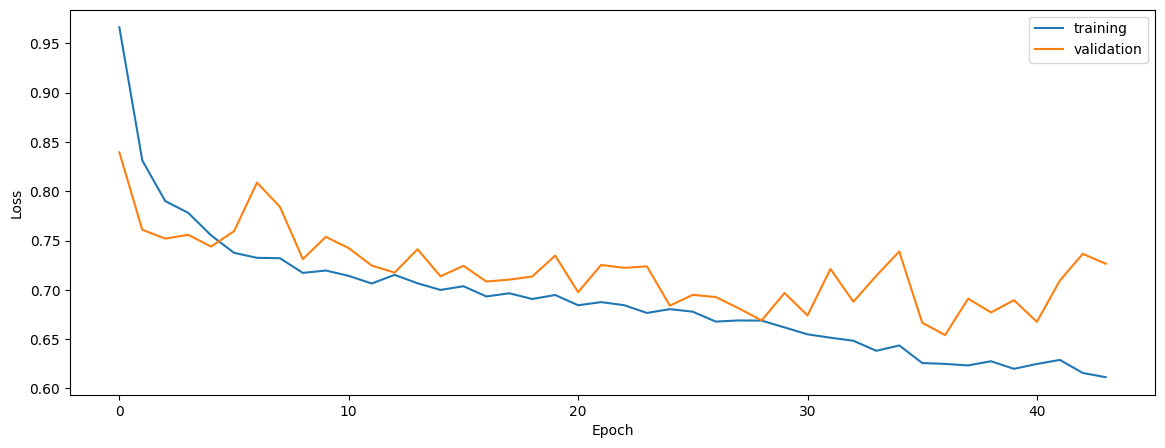

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.7221937800729356
0.7218345359296234
0.7218619016104125


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.7324223036158286
0.6887042649108022
0.7251842258376469


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.7468528018443151
0.7070344195058013
0.7327367151057467


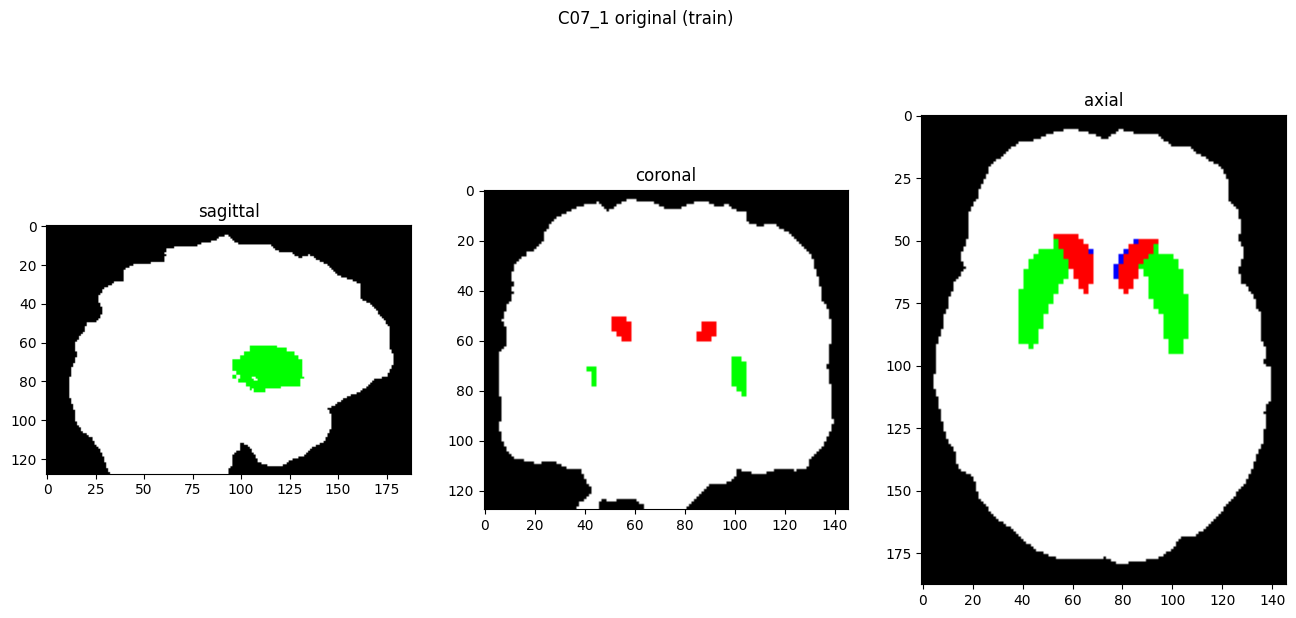

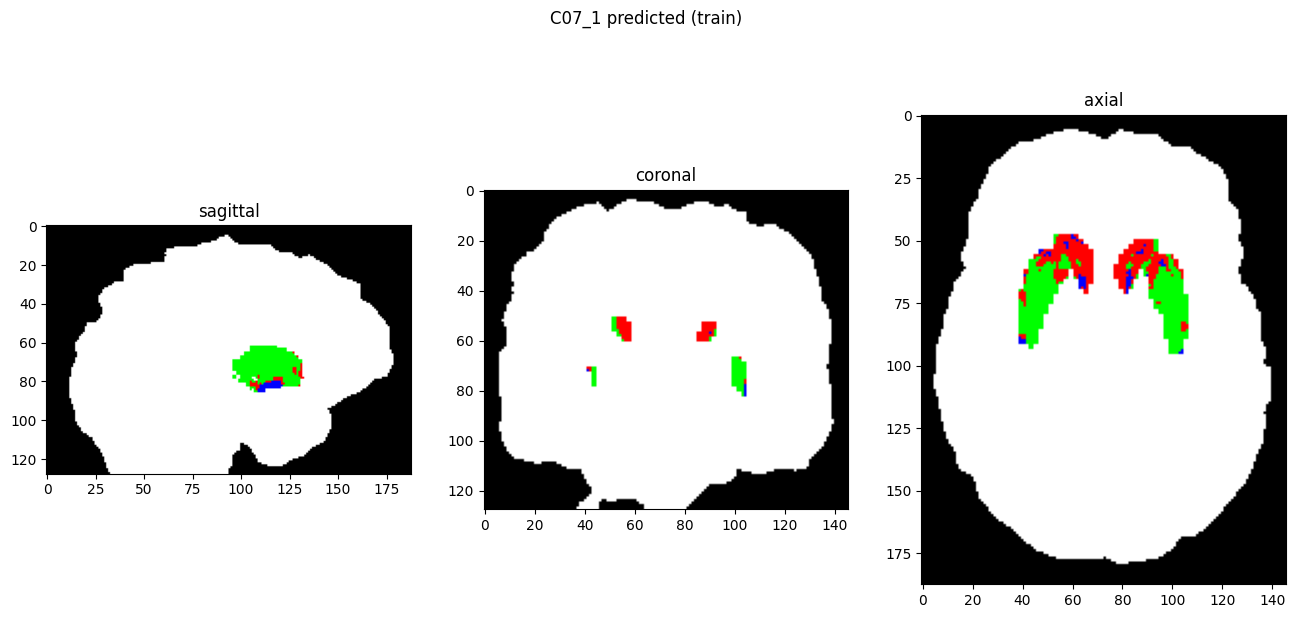

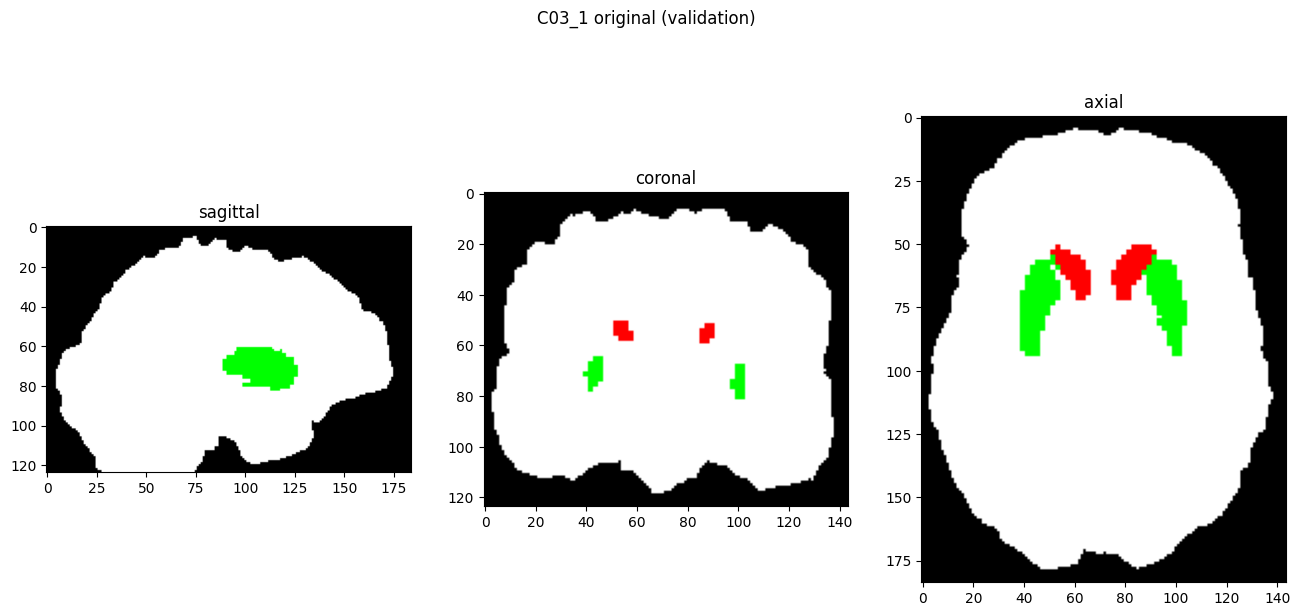

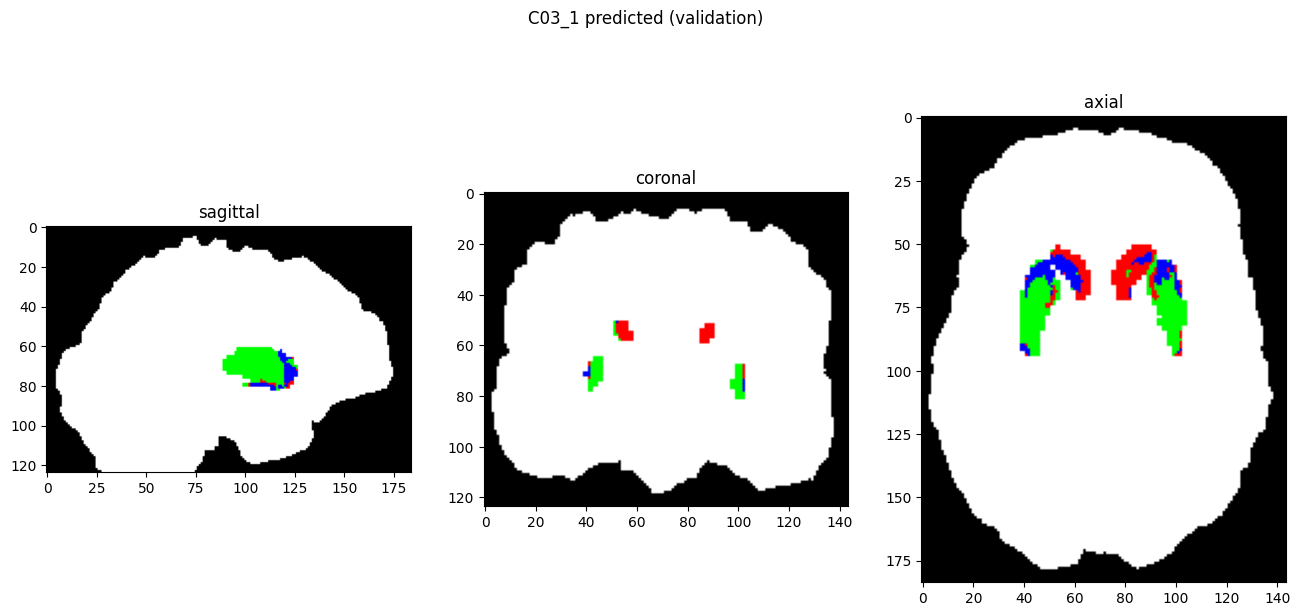

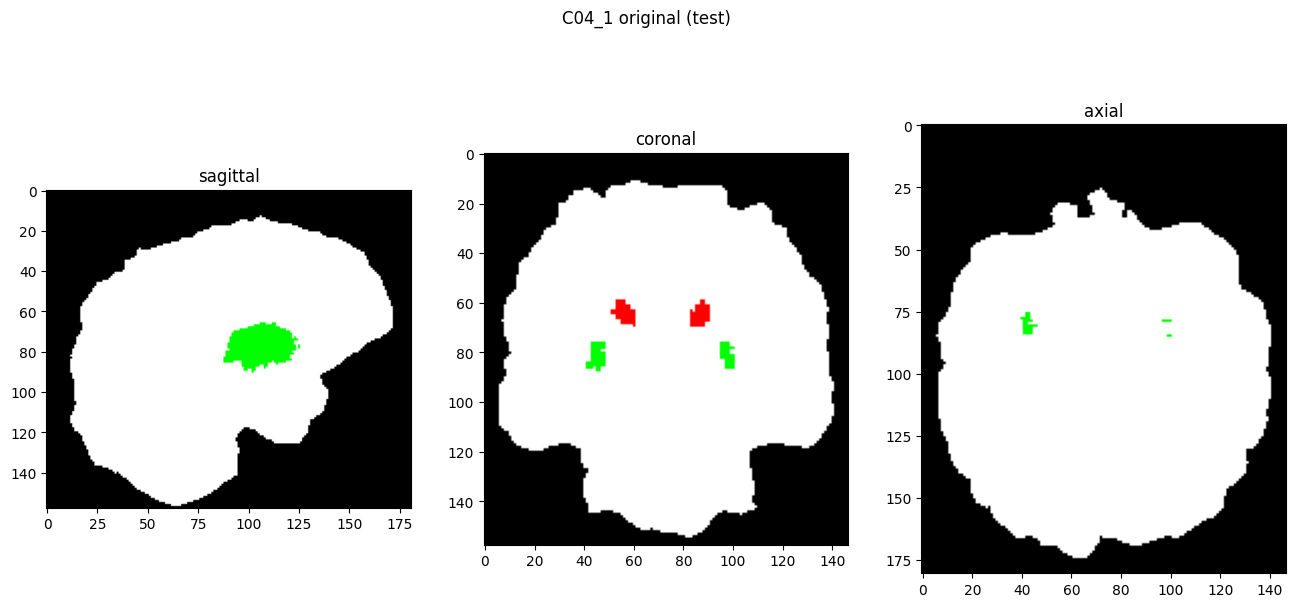

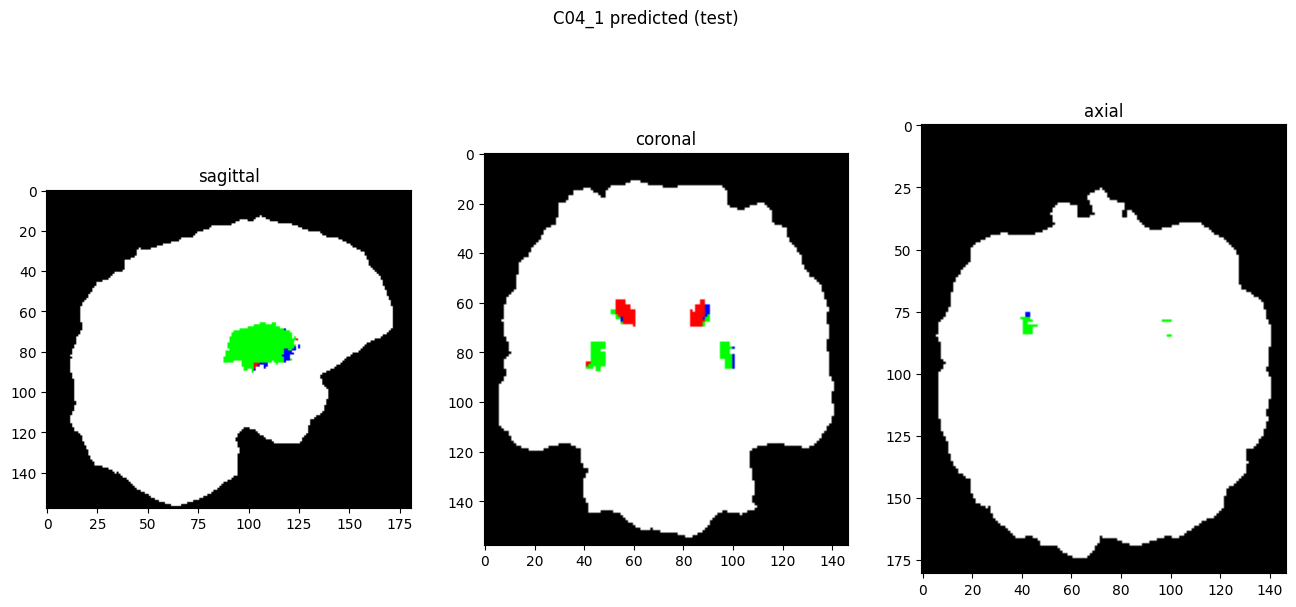

In [10]:
showResults(model, gen, threshold=0)